**Content** <a class="anchor" id="Content"></a>

1. [Reseach goal and data](#1)
2. [**BRCA** Data wrangling](#2)
    
    2.1 [TCGA data](#2.1)
    
    2.2 [IHC data](#2.2)
    
    2.3 [Annotated ABSOLUTE data](#2.3)
    
3. [Statistical testing](#3)
    
    3.1 [Mann-Whitney U test](#3.1)
4. [**BRCA** gene copy number](#4)
    
    4.1 [TCGA microarray](#4.1)
    
    4.2 [TCGA ABSOLUTE](#4.2)
5. [**BRCA** allele-specific copy numbers](#5)
    
    5.1 [TCGA microarray: Logistic regression & Random forest](#5.1)
    
    5.2 [TCGA ABSOLUTE: Logistic regression & random forest](#5.2)
6. [**BRCA** gene expression](#6)

    6.1 [New TCGA expression](#6.1)
    
    6.2 [Old TCGA expression](#6.2)

7. [All datatype integration](#7)

    7.1 [Binary data integration](#7.1)
    
    7.2 [Logistic regression data integration](#7.2)
    
    7.3 [PCA and subsequent visualizations](#7.3)

8. [BRCA comparison TCGA new vs TCGA ABSOLUTE](#8)

9. [HER2+ esophageal cancer MSK study](#9)

10. [**IO cohort** data wrangling](#10)

11. [**IO cohort** analysis](#11)

    11.1 [Total copy number](#11.1)
    
    11.2 [Allele-specific copy number](#11.2)
    
    11.3 [Gene expression](#11.3)
    
    11.4 [Integration all datatypes](#11.4)

*Note* Running "BRCA Data wrangling" with the option save == True will save files and not require to run this part again afterwards.

# 1 Research goal and data <a class="anchor" id="1"></a> [↑](#Content)

The overarching goal of this work is to integrate gene copy number profiles
and gene expression profiles to increase confidence in predictions of clinically
relevant genomic events. The focus is on the gene ERBB2, which is translated
into the protein HER2. The used data will be the allele-specific copy num-
ber profiles, gene level copy number and gene expression quantification from
breast and esophageal cancer patients obtained through The Cancer Genome
Atlas.

1. Import TCGA data (Gene Level Copy Number, Allele-specific Copy Number Segment Genotyping Array, Gene Expression Quantification)
2. Select a subset of 736 cancer relevant genes from TCGA data
3. Connect TCGA data with HER2 status by IHC from a [TCGA paper](https://www.nature.com/articles/nature11412).



## Data

The most recent analysis of The Cancer Genome Atlas (TCGA) was published in Cell in 2018 and is the recommended data source to use when working with data derived from TCGA. All data from these studies, among others, are available on the National Cancer Institute’s (NCI) Genomic Data Commons (GDC). Documentation of how these data were processed are also available on their webpage. Most relevant to this project are the copy number analysis and mRNA analysis pipelines.

For both esophageal carcinoma (ESCA) and breast invasive carcinoma (BRCA), the following data types were downloaded using the Genomic Data Commons’ data portal by selecting the cohort (project - TCGA-BRCA or TCGA-ESCA) and data type,

Gene Level Copy Number,
Allele-specific Copy Number Segment Genotyping Array,
Gene Expression Quantification:
All files were added to the “cart” and downloaded, along with the following files:

Sample sheet, “gdc_sample_sheet” (This sheet associates files and sample names), 
Biospecimen information (sample metadata), “biospecimen/”, 
Clinical variables for samples from TCGA, “clinical/”, 
File manifest from the data download, “MANIFEST.txt”.

**In a first part of this work, the focus will be the breast cancer subset for which we have the HER2 status by IHC.**

Following abbreviation are used: 
* acn : BRCA Allele-specific Copy Number Segment Genotyping Array
* ge : BRCA Gene Expression Quantification
* glcn : BRCA Gene Level Copy Number

### Cancer-related genes

[COSMIC](https://cancer.sanger.ac.uk/cosmic/download) provides a list of cancer related genes. Downloaded Jan 31st for this work (select 'Cancer Gene Census'). It contained a total of 736 genes. 
_Note_ It is a `.csv` file with the genes in a column called `Gene Symbol`. 

### HER2 status by IHC from [TCGA paper](https://www.nature.com/articles/nature11412)

The first column is `Complete TCGA ID` and the 6th is `HER2 Final Status` with the options `Positive`, `Negative` or `Not Available`. 
The used `.csv` has been modified from the original download: (1) only the first sheet has been kept and (2) the first row has been deleted. 




# 2 **BRCA** Data wrangling <a class="anchor" id="2"></a> [↑](#Content)

In a first step, the downloaded data is taken together into single dataframes for each datatypes. This dataframe include columns `Case ID`, `Sample ID`, `Sample Type`, `gene`, and the respective data, such as total copy number, allele-specific copy number or IHC status. 

Data is subsetted to cosmic list of gene to reduce computation requirements.

## 2.1 TCGA Data <a class="anchor" id="2.1"></a> [↑](#Content)

In [1]:
save = True  

# python version
# 3.9.7

# imports

import os 
import pandas as pd 
import numpy as np

# paths and files

# TCGA downloads

path_acn = 'C:\\Users\\User\\Desktop\\Big_files\\DATA\\TCGA mc3\\TCGA mc3\\BRCA Allele-specific Copy Number Segment Genotyping Array\\'
path_ge = 'C:\\Users\\User\\Desktop\\Big_files\\DATA\\TCGA mc3\\TCGA mc3\\BRCA Gene Expression Quantification\\'
path_gcn = 'C:\\Users\\User\\Desktop\\Big_files\\DATA\\TCGA mc3\\TCGA mc3\\BRCA Gene Level Copy Number\\'

# COSMIC list of cancer-related genes
cosmic_file = 'C:\\Users\\User\\Desktop\\Big_files\\DATA\\COSMIC\\cancer_gene_census.csv'

# directory for processed files
processed = 'C:\\Users\\User\\Desktop\\Big_files\\DATA\\processed_files\\'

# functions  

def open_df(file, sep = '\t', header = 0):
    '''
    Opens a file as pandas dataframe

    :param file: file path and name including extension 
    :return: pd.DataFrame()
    '''
    try:
        df = pd.read_csv(file, sep = sep, low_memory=False, header = header)
        return df
    except:
        print(f'Error opening {file}')

def column_to_list(file_path, column_name):
    '''
    Opens a .csv and puts a specific column in a list
    
    :param file_path: 
    :param column_name: 
    :return: list()
    '''
    df = pd.read_csv(file_path, sep=',', low_memory=False)
    new_list = df[column_name]
    return list(new_list)

def rows_select(df, col, lis):
    ''' 
    Select rows based on a column value being in a list and return new dataframe
    
    :param df: pandas dataframe object from which to select
    :param col: indicates which column of the dataframe should be used to select
    :param lis: list of items that are used to filter
    :return: new dataframe with selection applied
    '''
    df_new = df[df[col].isin(lis)]
    return df_new

def iterate_concatenate(sample_sheet, data_path, header = 0, subset_list = None):
    '''
    Iterate over rows of sample sheet for TCGA downloads and creates a master df 
    with 'Case ID', 'Sample ID', Sample Type' and then the downloaded data. 
    It is possible to directly subset to a list of genes. 
    
    :param sample_sheet: 
    :param data_path: path to the folder containing the folder metadata and data
    :param header: change if header is not in row[0] in data files
    :param subset_list: if a list, will just subset to these genes, 
                        if a list of list, will assume that genes need to be extracted from segments
    :return: df
    '''
    df = pd.DataFrame()
    for index, row in sample_sheet.iterrows():
        file_path = row['File ID']
        file_name = row ['File Name']
        metadata_col = {'case_id' : row['Case ID'],
                        'sample_id' : row['Sample ID'],
                        'sample_type' : row['Sample Type']}
        data = open_df(data_path + 'data\\' + file_path + '\\' + file_name, header = header)
        if all(isinstance(i, list) for i in subset_list):  # check if we have a list of list
            data = as_gene_extractor(data, subset_list)
        elif type(subset_list) == list:  
            subset_data = rows_select(data, 'gene_name', subset_list)
            data = subset_data.copy()  # for not raising the SettingWithCopyWarning error
        for i in metadata_col: data[i] = metadata_col[i]  # assigning the metadata       
        df = pd.concat([df, data], axis=0)
    return df

def as_gene_extractor(df, gene_list):
    '''
    From a TCGA data file containing allele-specific segment copy number
    extracts the copy numbers for the genes given in gene_list
    
    :param df:
    :param gene_list: list of list with 'gene', 'chr', start, end
    :return:
    '''
    result_list = []
    overlap_tracker = []
    for genes in gene_list:
        gene = genes[0]
        chromosome = genes[1]
        start = genes[2]
        end = genes[3]
        
        for index, rows in df.iterrows():
            if rows['Chromosome'] == chromosome:
                gene_length = end - start
                overlap = min(end, rows['End']) - max(start, rows['Start'])
                overlap_per = (overlap / gene_length) * 100
                
                if rows['Start'] <= start and rows['End'] >= end:
                    data = {'gene' : gene,
                            'total_cn' : rows['Copy_Number'],
                            'major_cn' : rows['Major_Copy_Number'],
                            'minor_cn' : rows['Minor_Copy_Number'], 
                            'segment_coverage' : round(overlap_per, 2)}
                    result_list.append(data)
                    
                elif overlap_per >= 50:
                    data = {'gene' : gene,
                            'total_cn' : rows['Copy_Number'],
                            'major_cn' : rows['Major_Copy_Number'],
                            'minor_cn' : rows['Minor_Copy_Number'], 
                            'segment_coverage' : round(overlap_per, 2)}
                    result_list.append(data)
                    overlap_tracker.append(data['segment_coverage'])
    
    return pd.DataFrame(result_list)


def counter(df, col1=None, col2=None):
    '''
    Counts how many rows the df has and what the columns are.
    If a col1 or col2 is specified, return what the values are
    :param df:
    :param col1: 
    :param col2:
    :return: printed statement
    '''
    for i in df:
        j = len(df[i])
        print(f'Column {i} has {j} values')
    if col1 is not None:
        val = df[col1].value_counts()
        print(f'Column {col1} has the following values \n {val}')
    if col2 is not None:
        val = df[col2].value_counts()
        print(f'Column {col2} has the following values \n {val}')
    print('-------------------------------------')
        
def save_csv(df, file_path):
    '''
    saves the df to a .csv file
    if save == True
    
    :param df:
    :param file_path: file name or path (without extension)
    :return: None
    '''
    if save == True:
        df.to_csv(f'{file_path}.csv', header = True, index = False)

def explode(df, col1, col2):
    '''
    Explodes the df based on two columns. Both must have 2 comma separated strings 
    in every row. 
    
    :param df: 
    :param col1: columns used for exploding, must two comma separated strings
    :param col2: same requirement as col1
    :return: exploded df
    '''
    n = len(df[col1])
    df = df.rename(columns={col1:'A', col2:'B'})
    df['A'] = df['A'].apply(lambda x: x.split(','))  # multiple explode accept only lists
    df['B'] = df['B'].apply(lambda x: x.split(','))
    df = df.explode(list('AB'))
    df['A'] = df['A'].apply(lambda x: x.strip())  # strip away space
    df['B'] = df['B'].apply(lambda x: x.strip()) 
    df = df.rename(columns={'A':col1, 'B':col2})
    m = len(df[col1])
    print(f'df exploded from {n} to {m} rows')    
    return df

In [2]:
# cosmic list of genes

cosmic_list = column_to_list(cosmic_file, 'Gene Symbol')

In [ ]:
# total gene copy numbers from TCGA

sample_sheet = open_df(path_gcn + 'metadata\\' + 'gdc_sample_sheet.tsv')
cn = iterate_concatenate(sample_sheet, path_gcn, subset_list = cosmic_list)
counter(cn) 
save_csv(cn, processed + 'total_gene_copy_numbers')

# subset copy numbers to ERBB2 gene and others
genes = ['ERBB2', 'CCND1', 'MYC']
cn = cn[cn['gene_name'].isin(genes)]

# reduce the case_id to the first one
cn['case_id'] = cn['case_id'].map(lambda x: x.split(',')[0])

# explode sample IDs and sample type 
cn = explode(cn, 'sample_id', 'sample_type')
save_csv(cn, processed + 'total_gene_copy_numbers_her2_exploded')
counter(cn, 'sample_type', 'case_id')

In [ ]:
# gene expression from TCGA
sample_sheet = open_df(path_ge + 'metadata\\' + 'gdc_sample_sheet.tsv')
gene_expression = iterate_concatenate(sample_sheet, path_ge, 1, cosmic_list)
counter(gene_expression)
save_csv(gene_expression, processed + 'gene_expression')

In [ ]:
# allele-specific copy number from TCGA
# since we have segments, we will directly extract the copy numbers for genes
# with a list of list containing 'gene', 'chr', start, end

genes = [['ERBB2', 'chr17', 39687914, 39730426]]  

sample_sheet = open_df(path_acn + 'metadata\\' + 'gdc_sample_sheet.tsv')
as_cn = iterate_concatenate(sample_sheet, path_acn, 0, genes)
counter(as_cn)
save_csv(as_cn, processed + 'allele_specific_copy_numbers')

# the used method takes the segment that have the highest coverage, it does not make any average
coverages = [cov for cov in as_cn['segment_coverage'] if cov < 100]
print(f'There are {len(coverages)} genes that had no matching segments of 100%.')
print(f'Here are the segment coverages: {coverages}')

# reduce the case_id to the first one
as_cn['case_id'] = as_cn['case_id'].map(lambda x: x.split(',')[0])

# explode sample IDs and sample type 
as_cn = explode(as_cn, 'sample_id', 'sample_type')
save_csv(as_cn, processed + 'allele_specific_copy_number_exploded')
counter(as_cn, 'sample_type', 'case_id')

## 2.2 IHC Data <a class="anchor" id="2.2"></a> [↑](#Content)

In [3]:
save = True  

# python version
# 3.9.7

# imports

import os 
import pandas as pd 
import numpy as np

# paths and files

# HER2 status by IHC from publication
her2_ihc = 'C:\\Users\\User\\Desktop\\Big_files\\DATA\\TCGA_paper_ihc\\Supplementary Tables 1.csv'

# directory for processed files
processed = 'C:\\Users\\User\\Desktop\\Big_files\\DATA\\processed_files\\'

# function

def open_df(file, sep = '\t', header = 0):
    '''
    Opens a file as pandas dataframe

    :param file: file path and name including extension 
    :return: pd.DataFrame()
    '''
    try:
        df = pd.read_csv(file, sep = sep, low_memory=False, header = header)
        return df
    except:
        print(f'Error opening {file}')

In [ ]:
# Status by IHC 

her2_status_ihc = open_df(her2_ihc, sep = ',')
counter(her2_status_ihc, 'HER2 Final Status')
save_csv(her2_status_ihc, processed + 'her2_status_ihc')

## 2.3 Annotated ABSOLUTE data <a class="anchor" id="2.3"></a> [↑](#Content)

---

The first part of the data wrangling with the ABSOLUTE data here is not used anymore since I got the data ready from my mentor. See [below](#rdy). 

---

This data is from a [TCGA publication](#https://gdc.cancer.gov/about-data/publications/PanCan-CellOfOrigin) where ABSOLUTE has been used to annotated many samples. 

Total rows in metadata = 79286, of which 2169 are for breast cancer (BRCA) SNP 6 arrays (`platform == 'Genome_Wide_SNP_6'`) and are `Do_not_use == False`. If we remove all samples having any annotations in `patient_annotation`, `sample_annotation`, or `aliquot_annotation`, we have 2115 rows.

In [4]:
save = True  

# python version
# 3.9.7

# imports

import os 
import pandas as pd 
import numpy as np

# paths and files

# ABSOLUTE annotated data
path_abs = 'C:\\Users\\User\\Desktop\\Big_files\\DATA\\david-tcga-abs-annotated\\david-tcga-abs-annotated'

# sample file for ABSOLUTE data
sample_file_path = 'C:\\Users\\User\\Desktop\\Big_files\\DATA\\david-tcga-abs-annotated\\merged_sample_quality_annotations.tsv'

# directory for processed files
processed = 'C:\\Users\\User\\Desktop\\Big_files\\DATA\\processed_files\\'

# functions 

def open_df(file, header = 0):
    '''
    Opens a file as pandas dataframe

    :param file: file path and name including extension 
    :return: pd.DataFrame()
    '''
    try:
        df = pd.read_csv(file, sep='\t', low_memory=False, header = header)
        return df
    except:
        print(f'Error opening {file}')

def iterate_conc_abs(folder):
    ''' 
    Iterates over a specific folder and combines all found files
    into a big dataframe
    '''
    df = pd.DataFrame()
    for filename in os.listdir(folder):
        file = os.path.join(folder, filename)
        data = open_df(file)
        df = pd.concat([df, data], axis=0)
    return df

def counter(df, col1=None, col2=None):
    '''
    Counts how many rows the df has and what the columns are.
    If a col1 or col2 is specified, return what the values are
    :param df:
    :param col1: 
    :param col2:
    :return: printed statement
    '''
    for i in df:
        j = len(df[i])
        print(f'Column {i} has {j} values')
    if col1 is not None:
        val = df[col1].value_counts()
        print(f'Column {col1} has the following values \n {val}')
    if col2 is not None:
        val = df[col2].value_counts()
        print(f'Column {col2} has the following values \n {val}')

def save_csv(df, file_path):
    '''
    saves the df to a .csv file
    if save == True
    
    :param df:
    :param file_path: file name or path (without extension)
    :return: None
    '''
    if save == True:
        df.to_csv(f'{file_path}.csv', header = True, index = False)

In [ ]:
# concatenate ABSOLUTE data
abs_data = iterate_conc_abs(path_abs)
counter(abs_data)
save_csv(abs_data, processed + 'abs_data')

In [ ]:
sample_sheet = open_df(sample_file_path)
sample_sheet = sample_sheet[sample_sheet['cancer type'] == 'BRCA']
print(len(set(sample_sheet['patient_barcode'].tolist())))
print(len(set(abs_data['patient'].tolist())))
print(len(set(abs_data['Sample'].tolist())))
counter(sample_sheet, 'patient_barcode')
counter(abs_data, 'patient')

---
<a class="anchor" id="rdy"></a>
**ABSOLUTE data** already wrangled for HER2, including gene expression. Everything here is from a [TCGA PanCancer publication](https://pubmed.ncbi.nlm.nih.gov/29625048/).

The data wrangling is documented in a separated notebook. 



In [5]:
save = True  

# python version
# 3.9.7

# imports

import os 
import pandas as pd 
import numpy as np

# paths and files

# ABSOLUTE aggregated data for gene ERBB2
aggregated_abs = 'C:\\Users\\User\\Desktop\\Big_files\\DATA\\david-tcga-abs-annotated\\aggregate_erbb2_data.with_erbb2_percentile.txt'

# metadata aggregated 
aggregated_metadata = 'C:\\Users\\User\\Desktop\\Big_files\\DATA\\david-tcga-abs-annotated\\aggregate_metadata.txt'

# directory for processed files
processed = 'C:\\Users\\User\\Desktop\\Big_files\\DATA\\processed_files\\'

# functions 

def open_df(file, sep = '\t', header = 0):
    '''
    Opens a file as pandas dataframe

    :param file: file path and name including extension 
    :param sep: change if sep is not tab (e..g for .csv)
    :param header: change if header not in first row
    :return: pd.DataFrame()
    '''
    try:
        df = pd.read_csv(file, sep=sep, low_memory=False, header=header)
        return df
    except:
        print(f'Error opening {file}')

def counter(df, col1=None, col2=None):
    '''
    Counts how many rows the df has and what the columns are.
    If a col1 or col2 is specified, return what the values are
    :param df:
    :param col1: 
    :param col2:
    :return: printed statement
    '''
    for i in df:
        j = len(df[i])
        print(f'Column {i} has {j} values')
    if col1 is not None:
        val = df[col1].value_counts()
        print(f'Column {col1} has the following values \n {val}')
    if col2 is not None:
        val = df[col2].value_counts()
        print(f'Column {col2} has the following values \n {val}')

def save_csv(df, file_path):
    '''
    saves the df to a .csv file
    if save == True
    
    :param df:
    :param file_path: file name or path (without extension)
    :return: None
    '''
    if save == True:
        df.to_csv(f'{file_path}.csv', header = True, index = False)
        
def division_norm(df, col1, col2, col3):
    '''
    Divides the values in df col1 by the values in df col2 and puts them in a column col3
    
    :param df: dataframe 
    :param col1: column of values to be divided
    :param col2: column of values to be divided by
    :param col3: name of the new columns with the new values
    :return: df with additional col (col3)
    '''
    df[col3] = np.where((df[col1] > 0) & (df[col2] > 0), df[col1]/(pow(2, df[col2])), df[col1])
    return df

In [ ]:
# open files
abs_data = open_df(aggregated_abs)
abs_metadata = open_df(aggregated_metadata)

# get IHC status and only take 'Positive' or 'Negative'
ihc = open_df(processed + 'her2_status_ihc.csv', sep = ',')

column = 'HER2 Final Status'
values = ['Negative', 'Positive']
ihc = ihc.loc[ihc[column].isin(values)]

print('IHC value counts \n', ihc[column].value_counts(), '\n')

# how is the overlap abs_data and ihc? 
ihc_patients = ihc['Complete TCGA ID'].drop_duplicates().tolist()

column = 'patient has IHC data' 
abs_metadata[column] = False
abs_metadata.loc[abs_metadata['patient_barcode'].isin(ihc_patients), column] = True

print('Matching IHC and ABS data counts \n', abs_metadata[column].value_counts())

# how many patient have more than one sample?
abs_patient = abs_data['patient_barcode'].tolist()

from collections import Counter
n = 0
for key in Counter(abs_patient): 
    if Counter(abs_patient)[key] > 1: 
        # print(key)
        n += 1
print(n)

# merge
abs_ihc = pd.merge(abs_data, ihc, how = 'inner', left_on = 'patient_barcode', right_on = 'Complete TCGA ID')
print(abs_ihc['Complete TCGA ID'].value_counts())

# add additional column for total and allele-specific copy numbers divided by genome doublings
abs_ihc_for_analysis = division_norm(abs_ihc, 'Modal_Total_CN', 'Genome doublings', 'Modal_Total_CN_divided')
abs_ihc_for_analysis = division_norm(abs_ihc, 'Modal_HSCN_1', 'Genome doublings', 'Modal_HSCN_1_divided')
abs_ihc_for_analysis = division_norm(abs_ihc, 'Modal_HSCN_2', 'Genome doublings', 'Modal_HSCN_2_divided')

# save
save_csv(abs_ihc_for_analysis, processed + 'abs_ihc_for_analysis')

In [6]:
# make lineage of samples and patients

# additional file with all clinical data for the TCGA BRCA project samples
path = 'C:\\Users\\User\\Desktop\\Big_files\\DATA\\sample.tsv'

# open files

sample = open_df(path)
meta = open_df(aggregated_metadata)
data = open_df(processed + 'abs_ihc_for_analysis.csv', sep = ',')
sample = sample[['sample_submitter_id', 'sample_type', 'is_ffpe']]
data['HER2 Final Status'].value_counts()

Negative    603
Positive     84
Name: HER2 Final Status, dtype: int64

In [7]:
df = data#[['patient_barcode', 'sample vial', 'sample']]
#df = df[df['patient_barcode'].duplicated(keep = False)][['patient_barcode', 'sample vial', 'sample']]
df = pd.merge(df, sample, left_on = 'sample vial', right_on = 'sample_submitter_id', how = 'left')
df = df[df['sample_type']=='Primary Tumor']
df['patient_barcode'].value_counts()

KeyError: 'sample_type'

In [ ]:
df = df[~(df.duplicated(subset=['patient_barcode'], keep='first')&(df['patient_barcode']=='TCGA-A2-A0YE'))]
df['patient_barcode'].value_counts()


In [ ]:
save_csv(df, processed + 'abs_ihc_for_analysis')

In [ ]:
# count the data
#ihc = open_df(processed+'abs_ihc_for_analysis.csv', sep=',')


ihc = open_df(processed + 'her2_status_ihc.csv', sep = ',')


column = 'HER2 Final Status'
values = ['Negative', 'Positive']
ihc = ihc.loc[ihc[column].isin(values)]

df = abs_data.copy()
merge = pd.merge(ihc, df, how='inner', left_on='Complete TCGA ID', right_on='patient_barcode')
merge['Complete TCGA ID'].value_counts()

# 3 Statistical testing <a class="anchor" id="3"></a> [↑](#Content)

# 4 BRCA gene copy number <a class="anchor" id="4"></a> [↑](#Content)

## 4.1 TCGA microarray <a class="anchor" id="4.1"></a> [↑](#Content)


We have the TCGA total copy gene numbers for all COSMIC genes. First, this is subsetted to the gene *ERBB2*, and then we remove the additional `case_id` that is added. This is because copy numbers are calculated with a tumor and a normal sample, which resulted in both patient IDs being mentionned (they are the same obviously). 

As a next step, the 

In [8]:
save = True  

# python version
# 3.9.7

# imports

import os 
import pandas as pd 
import numpy as np

# directory for processed files
processed = 'C:\\Users\\User\\Desktop\\Big_files\\DATA\\processed_files\\'

In [9]:
# functions

def open_df(file, sep = '\t', header = 0):
    '''
    Opens a file as pandas dataframe

    :param file: file path and name including extension 
    :return: pd.DataFrame()
    '''
    try:
        df = pd.read_csv(file, sep=sep, low_memory=False, header = header)
        return df
    except:
        print(f'Error opening {file}')

def counter(df, col1=None, col2=None):
    '''
    Counts how many rows the df has and what the columns are.
    If a col1 or col2 is specified, return what the values are
    :param df:
    :param col1: 
    :param col2:
    :return: printed statement
    '''
    for i in df:
        j = len(df[i])
        print(f'Column {i} has {j} values')
    if col1 is not None:
        val = df[col1].value_counts()
        print(f'Column {col1} has the following values \n {val}')
    if col2 is not None:
        val = df[col2].value_counts()
        print(f'Column {col2} has the following values \n {val}')
    print('-------------------------------------')

In [ ]:
# required data: copy number from TCGA
cn = open_df(processed + 'total_gene_copy_numbers_her2_exploded.csv', sep = ',')

# take only rows for ERBB2
cn = cn[cn['gene_name'].eq('ERBB2')]

# required data: HER2 status by IHC from TCGA
ihc = open_df(processed + 'her2_status_ihc.csv', sep = ',')

# subset total copy number data to primary tumors
cn_primary = cn[cn['sample_type'] == 'Primary Tumor'].copy()
print(f'df reduced from {len(cn["sample_type"])} to {len(cn_primary["sample_type"])} rows')

# add IHC data, matching on case_id (because IHC data has no information about sample)
# counter(ihc, 'HER2 Final Status')
cn_primary_ihc = pd.merge(cn_primary, ihc, left_on = 'case_id', right_on = 'Complete TCGA ID', how = 'left')
# counter(cn_primary_ihc, 'HER2 Final Status')

# keep only rows which have IHC status 'Positive' or 'Negative'
cn_ihc = cn_primary_ihc[cn_primary_ihc['HER2 Final Status'].str.contains('Positive|Negative', regex=True, na=False)]
print(f'by keeping only "Positive" and "Negative", the rows went from {len(cn_primary_ihc["HER2 Final Status"])} to {len(cn_ihc["HER2 Final Status"])}')

# check for patient that have two primary tumor samples
print(f'following case_id are present more than once: \n {cn_ihc[cn_ihc.duplicated(["case_id"])]["case_id"].tolist()}')

save_csv(cn_ihc, processed + 'cn_ihc')

**Handling of duplicate**


There is a list of 7 `case_id`s which have more than one primary tumor sample. Each has been checked manually. Some duplicate are FFPE. In the next step, we will add the sample information containing `True`or `False` for a column `is_ffpe` and remove samples that are FFPE. 



In [ ]:
# path to sample file 
sample_cn = 'C:\\Users\\User\\Desktop\\Big_files\\DATA\\TCGA mc3\\TCGA mc3\\BRCA Gene Level Copy Number\\metadata\\biospecimen\\sample.tsv'

# open sample file and subset it to the two relevant rows
samples = open_df(sample_cn)[['sample_submitter_id', 'is_ffpe']].copy()

# add ffpe information to dataframe cn_ihc
cn_ihc_ffpe = pd.merge(cn_ihc, samples, left_on = 'sample_id', right_on = 'sample_submitter_id', how = 'left')

# drop all rows where FFPE is true
cn_ihc_no_ffpe = cn_ihc_ffpe[cn_ihc_ffpe['is_ffpe'] == False].copy()
print(f'by keeping only "is_ffpe" = False, the rows went from {len(cn_ihc_ffpe["sample_id"])} to {len(cn_ihc_no_ffpe["sample_id"])}')

# check for patient that have two primary tumor samples
print(f'following case_id are present more than once: \n {cn_ihc_no_ffpe[cn_ihc_no_ffpe.duplicated(["case_id"])]["case_id"].tolist()}')

save_csv(cn_ihc_no_ffpe, processed + 'cn_ihc_no_ffpe')

**Handling of duplicates**

There are now still two duplicates, `TCGA-A7-A26E` and `TCGA-A7-A26J`. 

`TCGA-A7-A26E` is from the exact same samples but present different copy numbers. Not sure what to do here?

`TCGA-A7-A26J` is also from the same sample and the copy numbers are identical, the duplicate can be droppped.

In [ ]:
# drop one row for TCGA-A7-A26J
cn_ihc_clean = cn_ihc_no_ffpe[~(cn_ihc_no_ffpe.duplicated(subset = ['sample_id'], keep = 'first') & (cn_ihc_no_ffpe['case_id'] == 'TCGA-A7-A26J'))]

save_csv(cn_ihc_clean, processed + 'cn_ihc_clean')

**Adding genome duplication data**

The genome duplication numbers from [a cell publication](https://www.cell.com/cell/fulltext/S0092-8674(18)30302-7) can be downloaded from the TCGA [paper ressources website](https://gdc.cancer.gov/about-data/publications/PanCan-CellOfOrigin) (including purity and ploidy). 


In [10]:
gd_file = 'C:\\Users\\User\\Desktop\\Big_files\\DATA\\TCGA PanData\\TCGA_mastercalls.abs_tables_JSedit.fixed.txt'

# functions

def division_norm(df, col1, col2, col3):
    '''
    Divides the values in df col1 by the values in df col2 and puts them in a column col3
    
    :param df: dataframe 
    :param col1: column of values to be divided
    :param col2: column of values to be divided by
    :param col3: name of the new columns with the new values
    :return: df with additional col (col3)
    '''
    df[col3] = np.where((df[col1] > 0) & (df[col2] > 0), df[col1]/(pow(2, df[col2])), df[col1])
    return df

# get genome doublings from file 
gd = open_df(gd_file)[['sample', 'Genome doublings']]

# slice sample in genome doublings file 
gd['sample'] = gd['sample'].str.slice(0, 16)

# add genome doubling data 
cn_ihc_genome_doublings = pd.merge(cn_ihc_clean, gd, left_on = 'sample_id', right_on = 'sample', how = 'left')

# division of total gene copy numbers by genome doublings

total_cn_for_analysis = division_norm(cn_ihc_genome_doublings, 'copy_number', 'Genome doublings', 'copy_number_divided')

save_csv(total_cn_for_analysis, processed + 'total_cn_for_analysis')

NameError: name 'cn_ihc_clean' is not defined

**transformation to binary and confusion table**


In order to perform a similar analysis to the paper from [Stein _et al._](https://www.futuremedicine.com/doi/full/10.2217/fon-2021-0203), the data is transformed to binary data. This requires **exception handling** and **threshold setting**. Stein _et al._ decided that a copy number of $\geq$ 3 compared to the base ploidy of the tumor could be seen as HER2 positive. 

We have the total copy number in `copy_number` and the copy number divided by the genome doublings in `copy_number_divided`. 

The original supplementary data for the HER2 status by IHC contains four values: `Positive`, `Negative`, `Not Available` and `Equivocal`. In a previous step, only `Positive` and `Negative` were kept. 

*Threshold*

The copy number threshold can be changed when applying the function (set it below). It is not the same for total copy number and copy number divided by genome doublings. 

In [11]:
# imports

import os 
import pandas as pd 
import numpy as np

from sklearn import metrics

from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

from matplotlib.ticker import MaxNLocator

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# functions

def cn_converter(df, col, thr):
    '''
    Transforms the numbers in a choosen col to 1 or 0 
    depending on the choosen threshold. 
    
    :param df:
    :param col: column where threshold is applied
    :param thr: threshold. Note: threshold value and higher is positive
    :return: df with transformed col (rest stays the same)
    '''
    df = df.copy()
    df[col] = np.where(df[col] >= thr, 1, 0)
    return df

def ihc_converter(df, col, pos, neg):
    '''
    Modifies the status by IHC to binary based 
    on the two specified values (everything else = None)
    
    :param df: input df
    :param col: column where the IHC status is
    :param pos: values that are converted to 1
    :param neg: values that are converted to 0
    :return: df with transformed col (rest of df stays the same)
    '''
    rules = {pos:1, neg:0}
    rest = list(df[col].unique())
    rest.remove(pos)
    rest.remove(neg)
    for i in rest:
        rules[str(i)] = None
    return df.replace({col: rules})

def confusion(df, col1, col2):
    '''
    Calculates the confusion table from two specified columns
    
    :param df:
    :param col1: ground-truth
    :param col2: predicted values
    :return:
    '''
    truth = list(df[col1])
    predictions = list(df[col2])
    tn, fp, fn, tp = metrics.confusion_matrix(truth, predictions, normalize=None).ravel() # ravel() used as the functions returns an array
    return tn, fp, fn, tp

def confusion_plot(tn, fp, fn, tp, thr, x, y, x_label_true_neg, x_label_true_pos):
    '''
    Makes a plot with the binary confusion data
    
    :param tn:
    :param fp:
    :param fn:
    :param tp:
    :param thr: threshold used for correct annotation
    :param x: annotation of x-axis (predicted values)
    :param y: annotation of y-axis (true values)
    '''
    true_predictions_perc = round(100* (tp + tn)/(tn + fp + fn + tp), 2)  # used for putting in the title
    data = np.array([[tn, fp], [fn, tp]])  # array for plotting a heatmap 
    fig, ax = plt.subplots(figsize= (4,4))  # creates an empty canvas
    heatmap = ax.imshow(data, cmap='GnBu')  # makes the heatmap with the array and the specified colors 
    for (i, j), val in np.ndenumerate(data):  # goes throught the array and takes the values
        ax.text(j, i, val, ha="center", va="center", color="black")  # print the values in the specific cases
    cbar = fig.colorbar(heatmap)  # adds a colorbar for the heatmap
    cbar.ax.yaxis.label.set_fontfamily('sans-serif')
    ax.set_xticks([0, 1])  # sets a tick
    false = r'$<$'+str(thr)  # math mode + choosen threshold
    true = r'$\geq$'+str(thr)
    ax.set_xticklabels([false, true])
    ax.set_yticks([0, 1])
    ax.set_yticklabels([x_label_true_neg, x_label_true_pos])  # true labels
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_title(f'Correlation of the total gene copy number \n with the status by IHC \n', fontsize=10, loc='center')  #, pad=20)
    ax.text(0.5, 1.03, f'Accuracy = {true_predictions_perc}%, Threshold = {thr}', transform=ax.transAxes, fontsize=8, ha='center')
    fig.savefig(pictures+'confusion_plot_CN.png', dpi=500, bbox_inches='tight')
    plt.show()

    
def threshold_accuracy(df_in, col1, col2, min_thr, max_thr):
    '''
    Calculates the accuracy of copy numbers predictions for status 
    for several thresholds and returns the accuracy vs the threshold
    
    :param df: df with ground-truth and copy numbers 
    :param col1: gound-truth
    :param col2: copy numbers
    :param min_thr:
    :param max_thr: 
    :return: two lists of threshold and accuracies
    '''
    df_in = ihc_converter(df_in, col1, 'Positive', 'Negative')

    thresholds = list(range(min_thr, max_thr))
    accuracy_scores = []
    
    for thr in thresholds:

        df = df_in.copy()
        
        df[col2] = np.where(df[col2] >= thr, 1, 0)
        
        truth = list(df[col1])
        predictions = list(df[col2])
        acc = accuracy_score(truth, predictions)
        accuracy_scores.append(acc)
        
    return thresholds, accuracy_scores

def threshold_f1(df_in, col1, col2, min_thr, max_thr):
    '''
    Calculates the f1-scores of copy numbers predictions for status 
    for several thresholds and returns the f1 scores vs the threshold
    
    :param df: df with ground-truth and copy numbers 
    :param col1: gound-truth
    :param col2: copy numbers
    :param min_thr:
    :param max_thr: 
    :return: two lists of threshold and f1 scores
    '''
    df_in = ihc_converter(df_in, col1, 'Positive', 'Negative')

    thresholds = list(range(min_thr, max_thr))
    f1_scores = []
    
    for thr in thresholds:

        df = df_in.copy()
        
        df[col2] = np.where(df[col2] >= thr, 1, 0)
        
        truth = list(df[col1])
        predictions = list(df[col2])
        f1 = f1_score(truth, predictions)
        f1_scores.append(f1)
        
    return thresholds, f1_scores

def scatter_plot(list1, list2, title='title'): 
    '''
    Plots the two lists in a scatter plot
    
    :param lsit1:
    :param list2:
    :retunr:
    '''
    list_2_transformed = []
    for i in list2:
        j = round(i*100, 2)
        list_2_transformed.append(j)
    list2 = list_2_transformed

    fig, ax = plt.subplots()
    ax.scatter(list1, list2, color='green')
    ax.set_title(title)
    plt.xticks(range(min(list1),max(list1)+1,1))
    ax.set_xlabel('Threshold of total copy number for $ERBB2$')
    ax.set_ylabel('Prediction accuracy (%)')
    fig.savefig(pictures+'thrshold.png', dpi=500, bbox_inches='tight')
    plt.show()

def scatter_plot_f1(list1, list2, title='title'): 
    '''
    Plots the two lists in a scatter plot
    
    :param lsit1:
    :param list2:
    :retunr:
    '''


    fig, ax = plt.subplots()
    ax.scatter(list1, list2, color='green')
    ax.set_title(title)
    plt.xticks(range(min(list1),max(list1)+1,1))
    ax.set_xlabel('Threshold of total copy number for $ERBB2$')
    ax.set_ylabel('Prediction F1 score')
    fig.savefig(pictures+'thrshold_f1.png', dpi=500, bbox_inches='tight')
    plt.show()


In [12]:
pictures = 'C:\\Users\\User\\Desktop\\Big_files\\DATA\\figures\\'

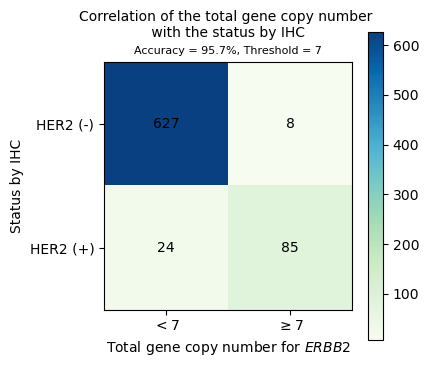

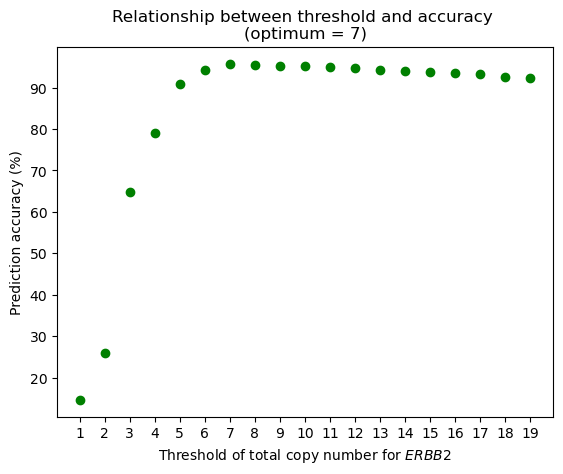

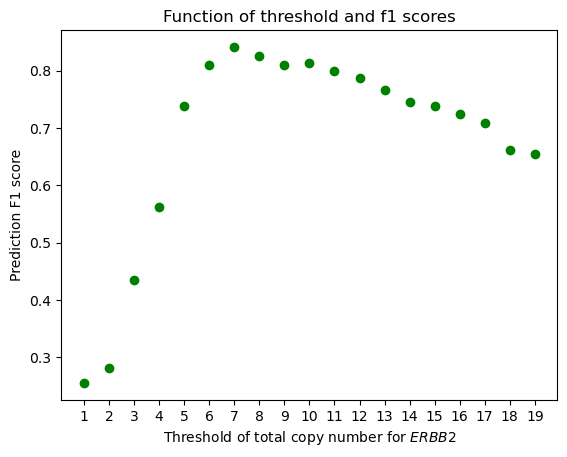

In [13]:
# analysis of the total cn not divided by gd

total_cn_for_analysis = open_df(processed + 'total_cn_for_analysis.csv', sep = ',')

# setting the threshold
threshold = 7

# tranforming the copy number to binary
total_cn_analysis = cn_converter(total_cn_for_analysis, 'copy_number', threshold)

# transforming the status by IHC
total_cn_analysis = ihc_converter(total_cn_analysis, 'HER2 Final Status', 'Positive', 'Negative')

# calculating confusion matrix
tn, fp, fn, tp = confusion(total_cn_analysis, 'HER2 Final Status', 'copy_number')

# making a plot
confusion_plot(tn, fp, fn, tp, threshold, 'Total gene copy number for $ERBB2$', 'Status by IHC', 'HER2 (-)', 'HER2 (+)')

# making a function of the threshold and the accuracy 
scatter_plot(*threshold_accuracy(total_cn_for_analysis, 'HER2 Final Status', 'copy_number', 1, 20), 
             title = 'Relationship between threshold and accuracy \n(optimum = 7)')
scatter_plot_f1(*threshold_f1(total_cn_for_analysis, 'HER2 Final Status', 'copy_number', 1, 20), title = 'Function of threshold and f1 scores')



There are cases that are impossible to predict, especially those having a low copy number with a HER2 positive status (by IHC). Breast cancer has different subtypes. This information is also present in the supplementary table, which contains the IHC data as well. 

In [14]:
df = open_df(processed + 'total_cn_for_analysis.csv', sep = ',')
difficult = df.loc[(df['copy_number'] >= 8) & (df['HER2 Final Status'].eq('Negative'))]
print(difficult['AJCC Stage'].value_counts())
print(difficult['PAM50 mRNA'].value_counts())
print(difficult['ER Status'].value_counts())
print(difficult['PR Status'].value_counts())

difficult.columns

Stage II      2
Stage IIA     1
Stage IA      1
Stage IV      1
Stage IIIA    1
Name: AJCC Stage, dtype: int64
Luminal A        1
Luminal B        1
HER2-enriched    1
Basal-like       1
Name: PAM50 mRNA, dtype: int64
Positive    5
Negative    1
Name: ER Status, dtype: int64
Negative    4
Positive    2
Name: PR Status, dtype: int64


Index(['gene_id', 'gene_name', 'chromosome', 'start', 'end', 'copy_number',
       'min_copy_number', 'max_copy_number', 'case_id', 'sample_id',
       'sample_type', 'Complete TCGA ID', 'Gender',
       'Age at Initial Pathologic Diagnosis', 'ER Status', 'PR Status',
       'HER2 Final Status', 'Tumor', 'Tumor--T1 Coded', 'Node', 'Node-Coded',
       'Metastasis', 'Metastasis-Coded', 'AJCC Stage', 'Converted Stage',
       'Survival Data Form', 'Vital Status', 'Days to Date of Last Contact',
       'Days to date of Death', 'OS event', 'OS Time', 'PAM50 mRNA',
       'SigClust Unsupervised mRNA', 'SigClust Intrinsic mRNA',
       'miRNA Clusters', 'methylation Clusters', 'RPPA Clusters',
       'CN Clusters', 'Integrated Clusters (with PAM50)',
       'Integrated Clusters (no exp)', 'Integrated Clusters (unsup exp)',
       'sample_submitter_id', 'is_ffpe', 'sample', 'Genome doublings',
       'copy_number_divided'],
      dtype='object')

In [ ]:
# analysis of the total cn divided by gd

total_cn_for_analysis = open_df(processed + 'total_cn_for_analysis.csv', sep = ',')

# setting the threshold
threshold = 2

# tranforming the copy number to binary
total_cn_analysis = cn_converter(total_cn_for_analysis, 'copy_number_divided', threshold)

# transforming the status by IHC
total_cn_analysis = ihc_converter(total_cn_analysis, 'HER2 Final Status', 'Positive', 'Negative')

# calculating confusion matrix
tn, fp, fn, tp = confusion(total_cn_analysis, 'HER2 Final Status', 'copy_number_divided')

# making a plot
confusion_plot(tn, fp, fn, tp, threshold, 'Predictions based on divided copy numbers', 'HER2 Status by IHC', 'HER2-', 'HER2+')

# making a function of the threshold and the accuracy 
scatter_plot(*threshold_accuracy(total_cn_for_analysis, 'HER2 Final Status', 'copy_number_divided', 1, 20), 
             title = 'Function of threshold and accuracy')
scatter_plot_f1(*threshold_f1(total_cn_for_analysis, 'HER2 Final Status', 'copy_number_divided', 1, 20), 
             title = 'Function of threshold and f1 scores')

## 4.2 TCGA ABSOLUTE <a class="anchor" id="4.2"></a> [↑](#Content)


Thresholding total copy number below<a class="anchor" id="total_cn"></a>.

2.0     295
3.0     104
1.0      98
4.0      85
9.0      26
8.0      25
5.0      22
6.0      18
7.0       6
10.0      4
11.0      2
14.0      1
12.0      1
Name: Total_CN, dtype: int64


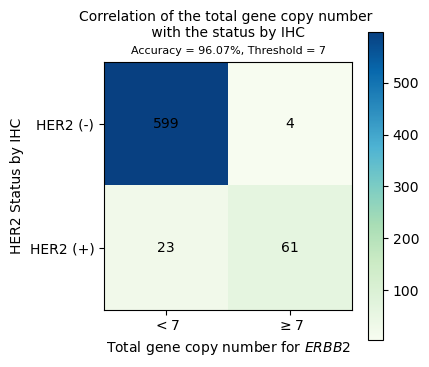

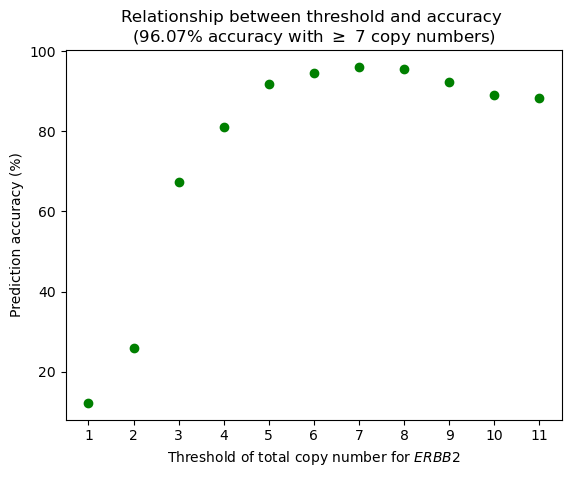

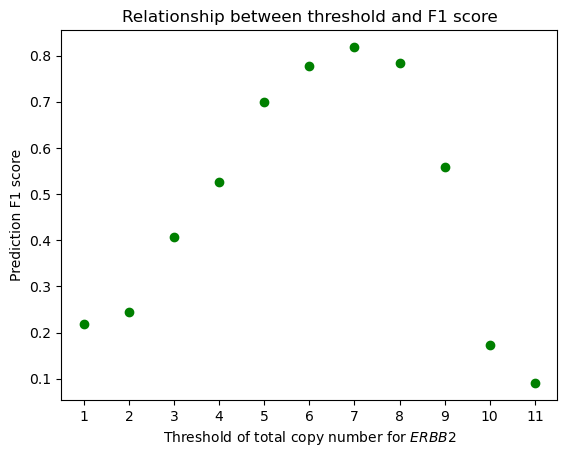

In [15]:
# analysis of the total cn not divided by gd
abs_ihc = open_df(processed + 'abs_ihc_for_analysis.csv', sep = ',')

# make additional column for the CN total based on the allele-specific CN
abs_ihc['Total_CN'] = abs_ihc['Modal_HSCN_1'].map(lambda x: x) + abs_ihc['Modal_HSCN_2'].map(lambda x: x)
print(abs_ihc['Total_CN'].value_counts(dropna=False))

# setting the threshold
threshold = 7

# tranforming the copy number to binary
abs_total_cn_analysis = cn_converter(abs_ihc, 'Total_CN', threshold)

# transforming the status by IHC
abs_total_cn_analysis = ihc_converter(abs_total_cn_analysis, 'HER2 Final Status', 'Positive', 'Negative')

# calculating confusion matrix
tn, fp, fn, tp = confusion(abs_total_cn_analysis, 'HER2 Final Status', 'Total_CN')

# making a plot
confusion_plot(tn, fp, fn, tp, threshold, 'Total gene copy number for $ERBB2$', 'HER2 Status by IHC', 'HER2 (-)', 'HER2 (+)')

# making a function of the threshold and the accuracy 
scatter_plot(*threshold_accuracy(abs_ihc, 'HER2 Final Status', 'Total_CN', 1, 12), 
             title = 'Relationship between threshold and accuracy \n(96.07% accuracy with $\geq$ 7 copy numbers)')
scatter_plot_f1(*threshold_f1(abs_ihc, 'HER2 Final Status', 'Total_CN', 1, 12), 
             title = 'Relationship between threshold and F1 score')

In [ ]:
# additional chunk for feedback from Martin Enge asking to do the thresholding approach with a 80:20 split to avoid overfitting


# open df
df = open_df(processed+'.csv', sep=',')

thresholds = []
f1_scores = []

# make splits 

for split in splits: 

    df_in = ihc_converter(df_in, col1, 'Positive', 'Negative')

    thresholds = list(range(min_thr, max_thr))
    f1_scores = []
    
    for thr in thresholds:

        df = df_in.copy()
        
        df[col2] = np.where(df[col2] >= thr, 1, 0)
        
        truth = list(df[col1])
        predictions = list(df[col2])
        f1 = f1_score(truth, predictions)
        f1_scores.append(f1)
        
    return thresholds, f1_scores


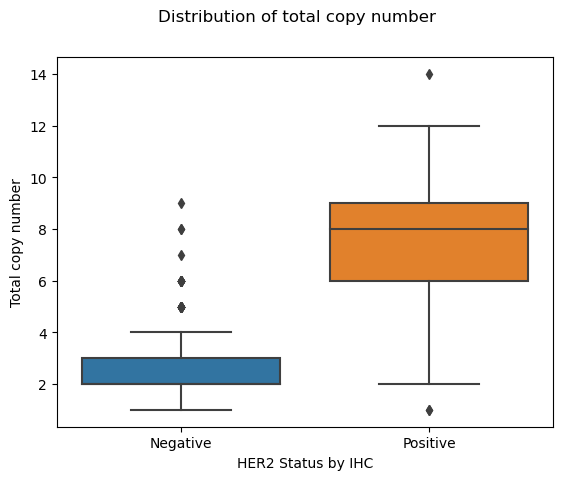

In [9]:
# looking at a boxplot of the total copy numbers

def box_plot(df, x, y, x_label, y_label, hue = None, title='Title'):
    '''
    Make a swarm plot with the gene expression data, separated by HER2 status by IHC
    
    :param df: input df, must be clean and tidy for seaborn (long format)
    :param x: x-axis, thought to be the HER2 status by IHC
    :param y: y-axis, thought to be the gene expression
    :param x_label:
    :param y_label: 
    :param title:
    :return: print the plots
    '''
    fig, ax = plt.subplots()
    
    sns.boxplot(data = df, x = x, y = y, hue = hue)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    fig.suptitle(title)
    plt.show()
    
box_plot(abs_ihc, 'HER2 Final Status', 'Total_CN', 'HER2 Status by IHC', 'Total copy number', title = 'Distribution of total copy number')

In [ ]:
# analysis of the total cn divided by gd

abs_ihc = open_df(processed + 'abs_ihc_for_analysis.csv', sep = ',')

# setting the threshold
threshold = 3

# tranforming the copy number to binary
abs_total_cn_analysis = cn_converter(abs_ihc, 'Modal_Total_CN_divided', threshold)

# transforming the status by IHC
abs_total_cn_analysis = ihc_converter(abs_total_cn_analysis, 'HER2 Final Status', 'Positive', 'Negative')

# calculating confusion matrix
tn, fp, fn, tp = confusion(abs_total_cn_analysis, 'HER2 Final Status', 'Modal_Total_CN_divided')

# making a plot
confusion_plot(tn, fp, fn, tp, threshold, 'Predictions based on divided copy numbers', 'HER2 Status by IHC', 'HER2-', 'HER2+')

# making a function of the threshold and the accuracy 
scatter_plot(*threshold_accuracy(abs_ihc, 'HER2 Final Status', 'Modal_Total_CN_divided', 1, 20), 
             title = 'Function of threshold and accuracy')
scatter_plot_f1(*threshold_f1(abs_ihc, 'HER2 Final Status', 'Modal_Total_CN_divided', 1, 20), 
             title = 'Function of threshold and f1 scores')

# 5 BRCA allele-specific copy numbers <a class="anchor" id="5"></a> [↑](#Content)

## 5.1 TCGA microarray: Logistic regression & Random forest <a class="anchor" id="5.1"></a> [↑](#Content)

In [10]:
save = True  

# python version
# 3.9.7

# imports

import os 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# directory for processed files
processed = 'C:\\Users\\User\\Desktop\\Big_files\\DATA\\processed_files\\'

In [11]:
# functions

def open_df(file, sep = '\t', header = 0):
    '''
    Opens a file as pandas dataframe

    :param file: file path and name including extension 
    :return: pd.DataFrame()
    '''
    try:
        df = pd.read_csv(file, sep=sep, low_memory=False, header = header)
        return df
    except:
        print(f'Error opening {file}')

def counter(df, col1=None, col2=None):
    '''
    Counts how many rows the df has and what the columns are.
    If a col1 or col2 is specified, return what the values are
    :param df:
    :param col1: 
    :param col2:
    :return: printed statement
    '''
    for i in df:
        j = len(df[i])
        print(f'Column {i} has {j} values')
    if col1 is not None:
        val = df[col1].value_counts()
        print(f'Column {col1} has the following values \n {val}')
    if col2 is not None:
        val = df[col2].value_counts()
        print(f'Column {col2} has the following values \n {val}')
    print('-------------------------------------')

def save_csv(df, file_path):
    '''
    saves the df to a .csv file
    if save == True
    
    :param df:
    :param file_path: file name or path (without extension)
    :return: None
    '''
    if save == True:
        df.to_csv(f'{file_path}.csv', header = True, index = False)

In [ ]:
# required data: allele-sepcific copy number from TCGA
as_cn = open_df(processed + 'allele_specific_copy_number_exploded.csv', sep = ',')

# required data: HER2 status by IHC from TCGA
ihc = open_df(processed + 'her2_status_ihc.csv', sep = ',')

# subset allele-specific copy number data to primary tumors
as_cn_primary = as_cn[as_cn['sample_type'] == 'Primary Tumor'].copy()
print(f'df reduced from {len(as_cn["sample_type"])} to {len(as_cn_primary["sample_type"])} rows')

# add IHC data, matching on case_id (because IHC data has no information about sample)
counter(ihc, 'HER2 Final Status')
as_cn_primary_ihc = pd.merge(as_cn_primary, ihc, left_on = 'case_id', right_on = 'Complete TCGA ID', how = 'left')
counter(as_cn_primary_ihc, 'HER2 Final Status')

# keep only rows which have IHC status 'Positive' or 'Negative'
as_cn_ihc = as_cn_primary_ihc[as_cn_primary_ihc['HER2 Final Status'].str.contains('Positive|Negative', regex=True, na=False)]
print(f'by keeping only "Positive" and "Negative", the rows went from {len(as_cn_primary_ihc["HER2 Final Status"])} to {len(as_cn_ihc["HER2 Final Status"])}')

# check for patients that have two primary tumor samples
print(f'following case_id are present more than once: \n {cn_ihc[cn_ihc.duplicated(["case_id"])]["case_id"].tolist()}')

save_csv(as_cn_ihc, processed + 'as_cn_ihc')

**Handling of duplicate**


There is a list of 7 `case_id`s which have more than one primary tumor sample. Each has been checked manually. Some duplicate are FFPE. In the next step, we will add the sample information containing `True`or `False` for a column `is_ffpe` and remove samples that are FFPE. 


In [ ]:
# path to sample file 
sample_as_cn = 'C:\\Users\\User\\Desktop\\Big_files\\DATA\\TCGA mc3\\TCGA mc3\\BRCA Allele-specific Copy Number Segment Genotyping Array\\metadata\\biospecimen\\sample.tsv'

# open sample file and subset it to the two relevant rows
samples = open_df(sample_as_cn)[['sample_submitter_id', 'is_ffpe']].copy()

# add ffpe information to dataframe cn_ihc
as_cn_ihc_ffpe = pd.merge(as_cn_ihc, samples, left_on = 'sample_id', right_on = 'sample_submitter_id', how = 'left')

# drop all rows where FFPE is true
as_cn_ihc_no_ffpe = as_cn_ihc_ffpe[as_cn_ihc_ffpe['is_ffpe'] == False].copy()
print(f'by keeping only "is_ffpe" = False, the rows went from {len(as_cn_ihc_ffpe["sample_id"])} to {len(as_cn_ihc_no_ffpe["sample_id"])}')

# check for patient that have two primary tumor samples
print(f'following case_id are present more than once: \n {as_cn_ihc_no_ffpe[as_cn_ihc_no_ffpe.duplicated(["case_id"])]["case_id"].tolist()}')

save_csv(as_cn_ihc_no_ffpe, processed + 'as_cn_ihc_no_ffpe')

**Handling of duplicates**

There are now still two duplicates, `TCGA-A7-A26E` and `TCGA-A7-A26J`. 

`TCGA-A7-A26E` is from the exact same samples but present different copy numbers. Not sure what to do here?

`TCGA-A7-A26J` is also from the same sample and the copy numbers are identical, the duplicate can be droppped.

In [ ]:
# drop one row for TCGA-A7-A26J
as_cn_ihc_clean = as_cn_ihc_no_ffpe[~(as_cn_ihc_no_ffpe.duplicated(subset = ['sample_id'], keep = 'first') & (as_cn_ihc_no_ffpe['case_id'] == 'TCGA-A7-A26J'))]

save_csv(as_cn_ihc_clean, processed + 'as_cn_ihc_clean')

**Adding genome duplication data**

The genome duplication numbers from [a cell publication](https://www.cell.com/cell/fulltext/S0092-8674(18)30302-7) can be downloaded from the TCGA [paper ressources website](https://gdc.cancer.gov/about-data/publications/PanCan-CellOfOrigin) (including purity and ploidy). 


In [ ]:
gd_file = 'C:\\Users\\User\\Desktop\\Big_files\\DATA\\TCGA PanData\\TCGA_mastercalls.abs_tables_JSedit.fixed.txt'

# functions

def division_norm(df, col1, col2, col3):
    '''
    Divides the values in df col1 by the values in df col2 and puts them in a column col3
    
    :param df: dataframe 
    :param col1: column of values to be divided
    :param col2: column of values to be divided by
    :param col3: name of the new columns with the new values
    :return: df with additional col (col3)
    '''
    df[col3] = np.where((df[col1] > 0) & (df[col2] > 0), df[col1]/(pow(2, df[col2])), df[col1])
    return df

# get genome doublings from file 
gd = open_df(gd_file)[['sample', 'Genome doublings']]

# slice sample in genome doublings file 
gd['sample'] = gd['sample'].str.slice(0, 16)

# add genome doubling data 
as_cn_ihc_genome_doublings = pd.merge(as_cn_ihc_clean, gd, left_on = 'sample_id', right_on = 'sample', how = 'left')

# division of allele-specific gene copy numbers by genome doublings
as_cn_for_analysis = division_norm(as_cn_ihc_genome_doublings, 'total_cn', 'Genome doublings', 'total_cn_divided')
as_cn_for_analysis = division_norm(as_cn_ihc_genome_doublings, 'major_cn', 'Genome doublings', 'major_cn_divided')
as_cn_for_analysis = division_norm(as_cn_ihc_genome_doublings, 'minor_cn', 'Genome doublings', 'minor_cn_divided')

save_csv(as_cn_for_analysis, processed + 'as_cn_for_analysis')

### Visualization

Here I would like to make three groups: 
* Group1: The copy numbers are the same for the major and the minor cn
* Group2: The major allele has more copies than the minor allele (except minor = 0)
* Group3: The copy number of the minor allele is 0 (there is a deletion)

For each group I will plot 4 whiskers, for the minor and major allele and separated by status by IHC. 

In [12]:
# functions

def grouping(df, minor, major):
    '''
    Makes an additional col with group 1-3:
    - major = minor -> grp. 1
    - major > minor, minor != 0 -> grp. 2
    - minor == 0 -> grp. 3
    
    :param df: 
    :param minor: col with minor cn
    :param major: col with major cn
    :return:
    '''
    for index, row in df.iterrows():
        if row[major] == row[minor]:
            df.loc[index, 'group'] = 'group1'
        elif row[minor] != 0:
            df.loc[index, 'group'] = 'group2'
        else:
            df.loc[index, 'group'] = 'group3'
    return df

def tidy(df, col1, col2, new_col1, new_col2):
    '''
    Tidies up two columns by putting the values in a single column
    and adds a column for the category
    
    :param df:
    :param col1: col 1 to be merged 
    :param col2: col 2 to be merged
    :param new_col1: name of the col with the merged values
    :param new_col2: name of the col with the new category
    :return: modified df
    '''
    untouched = df.columns.values.tolist()
    untouched = [element for element in untouched if element != col1]
    untouched = [element for element in untouched if element != col2]
    return df.melt(value_vars=[col1, col2], var_name=new_col2, value_name=new_col1, id_vars=untouched)
    
def binary_to_word(df, col, word1, word2):
    '''
    Transform binary column to words
    
    :param df:
    :param col:
    :param word1: this word replaces 0
    :param word2: this word replaces 1
    :return: modified df
    '''
    replacer = {0:word1, 1:word2}
    df[col] = df[col].map(replacer)
    return df

def remove_empty_rows(df, col1, col2):
    '''
    Removes the rows if col1 or col2 contains an empty space
    
    :param df:
    :param col1:
    :param col2:
    :return: df
    '''
    total_rows = len(df.index)
    df.dropna(subset=[col1], inplace=True)
    df.dropna(subset=[col2], inplace=True)
    kept_row = len(df.index)
    print('While removing rows with NaNs, the former total rows of ', total_rows, ' were reduced to ', kept_row)
    return df
    
def group_boxplots(df, group, values, allele, status, title='Title'):
    '''
    Make a figure with major and minor cn as whiskers, separated by ihc status and
    for each group a subplot
    
    :param df:
    :param group: col where the group for subplot are
    :param values: col where the values are
    :param allele: col where the category minor / major is
    :param status: col where the status by IHC is
    :param title:
    :return: 
    '''
    groups = list(df[group].unique())
    
    fig, axes = plt.subplots(figsize = (15,8), nrows=1, ncols = len(groups))
    for grp in groups:
        index = groups.index(grp)
        sel = (df[group] == grp) # selecting only the group specific data
        data = df[sel]
        data = data.copy()
        n_pos = int(len(data[(data[status]=='Positive')])/2) # division by 2 required as tidy
        n_neg = int(len(data[(data[status]=='Negative')])/2)
        sns.boxplot(data=data, orient='v', y=values, x=allele, 
                    hue=status, ax=axes[index], palette = 'pastel',
                   showmeans=True)
        
        axes[index].set_xlabel(f'{grp}, n = {int(len(data)/2)}, {n_neg} and {n_pos}')
        axes[index].set_ylim(0,80)
        
    fig.suptitle(title)
    plt.show()

def remove_empty_rows(df, col1, col2):
    '''
    Removes the rows if col1 or col2 contains an empty space
    
    :param df:
    :param col1:
    :param col2:
    :return: df
    '''
    total_rows = len(df.index)
    df.dropna(subset=[col1], inplace=True)
    df.dropna(subset=[col2], inplace=True)
    kept_row = len(df.index)
    print('While removing rows with NaNs, the former total rows of ', total_rows, ' were reduced to ', kept_row)
    return df

In [ ]:
# get saved file
as_cn_for_analysis = open_df(processed + 'as_cn_for_analysis.csv', sep = ',')

# grouping
as_cn_grouped = grouping(as_cn_for_analysis, 'minor_cn', 'major_cn')

# tidy copy numbers (major & minor)
as_cn_grouped_tidy = tidy(as_cn_grouped, 'minor_cn', 'major_cn', 'as_copy_number', 'allele')

as_cn_grouped_tidy_worded = as_cn_grouped_tidy[['HER2 Final Status', 'allele', 'as_copy_number', 'group']]

group_boxplots(as_cn_grouped_tidy_worded, 'group', 'as_copy_number', 'allele', 'HER2 Final Status', 'Graph 2')

Recap 3 groups: 
* Group1: The copy numbers are the same for the major and the minor cn
* Group2: The major allele has more copies than the minor allele (except minor = 0)
* Group3: The copy number of the minor allele is 0 (there is a deletion)

*Group 1* There is a slight difference in the mean, but the boxplots look the same. This explains a p value that indicates significance only if we set the threshold to 0.05 for significance. 
*Group 2* The boxplot all look very different but the p value for the minor allele is only 0.04. For the major allele, it is highly significant (3e-7). 
*Group 3* Similar distribution with p value that are not significant (one is 0.048). 

Overall, it shows how similar the distributions are. 

### Statistical testing

In [13]:
# imports

from scipy.stats import mannwhitneyu

# functions

def mannwhitneyu_test(df_o, values, gr1, gr2):
    '''
    Does a Mann Whitney U test for groups specified (each group can't have more than 2 cat)
    
    :param df_o: df with data
    :param values: column with values
    :param gr1: which two groups to compare for the test
    :param gr2: if differences in this column will initiate two tests
    :return: results are printed
    '''
    for i in list(df_o[gr2].unique()):
        sel = (df_o[gr2] == i)
        df = df_o[sel]
        cat = list(df[gr1].unique())
        sel_x = (df[gr1] == cat[0])
        sel_y = (df[gr1] == cat[1])
        df_x = df[sel_x][values]
        df_y = df[sel_y][values]
        s, p = mannwhitneyu(list(df_x), list(df_y))
        print(f'Mann Whitney U test comparing {values} (two categories: {cat[0]} and {cat[1]} for the {i} allele) results in a p-value of {p:.2e}.')
    return 
    
def iterate_apply_test(df, group, values, allele, status):
    '''
    Iterate over data and apply statistical test
    
    :param df:
    :param group: col where the group for subplot are
    :param values: col where the values are
    :param allele: col where the category minor / major is
    :param status: col where the status by IHC is
    :return: 
    '''
    
    groups = list(df[group].unique())
    for grp in groups:
        index = groups.index(grp)
        sel = (df[group] == grp) # selecting only the group specific data
        data = df[sel]
        data = data.copy()
        print(f'Statistical test for {grp}:')
        
        # statistical test
        
        mannwhitneyu_test(data, values, status, allele) 

In [ ]:
# statistical test
iterate_apply_test(as_cn_grouped_tidy_worded, 'group', 'as_copy_number', 'allele', 'HER2 Final Status')

### Logistic regression

Looking at graph 2 shows us that there are differences in the distributions. The question is how to take this into account for making a prediction about the HER2 status. The first option would be to (1) keep the 3 groups and do individual predictions for each of them. This could help in making the predictions more specific.  

*Note* The function `get_matrix()` can be summarized by `ret = [[a, b] for a, b in zip(a, b)]`.

In [14]:
# imports

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from tqdm import tqdm

# functions

def col_to_array(full_df, val1, val2=None, val3=None, mask=None):
    '''
    Returns an array with val1 and val2 (optional) 
    after applying a selection (mask)
    
    :param df: 
    :param val1: column to select
    :param val2: column to select (optional)
    :param mask: mask to subset df (optional)
    :return: np.array with the values
    '''
    if not (mask is None):
        df = full_df[mask]
        df = df.copy()
    else:
        df = full_df
    if val3 != None:
        return df[[val1, val2, val3]].to_numpy()
    elif val2 != None:
        return df[[val1, val2]].to_numpy()
    else:
        return df[[val1]].to_numpy()

def data_split(X, y):
    ''' 
    Splits the data in train and test set
    
    Test size can be change, 0.2 means that 20% is used for testing
    setting random_state results in constant results
    
    :param X: matrix for the x values
    :param y: true labels (list)
    :return: X_train, X_test, y_train, y_test
    '''
    sss = StratifiedShuffleSplit(test_size = 0.2, random_state = None, n_splits = 10)

    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    return X_train, X_test, y_train, y_test

def choose_function(fun_dict, name, *args, **kwargs):
    '''
    Based on the dictionnary and the name provided,
    a values will be returned
    
    :param fun_dict: dict containing the function description (key) and function (value)
    :param name: function to choose
    :return: function
    '''
    function = fun_dict[name]
    return function(*args, **kwargs)

def logistic_train_predict(X, y, test_set):
    '''
    uses the input for training and then predicts the values for the test set
    
    :param X: matrix of values for training
    :param y: true labels for training set
    :param test_set: test set (same structure as X) which will be used for the predictions
    :return: list of prediction based on the test_set
    '''
    model = LogisticRegression(random_state=None).fit(X, y)
    params = model.intercept_
    return model.predict(test_set)    

def confusion_table(truth, prediction):
    '''
    Calculates the confusion table from 2 lists
    
    :param truth: list 
    :param prediction: list
    :return: tn, fp, fn, tp
    '''
    return metrics.confusion_matrix(truth, prediction, normalize=None).ravel()

def confusion_plot_no_thr(tn, fp, fn, tp, x, y, x_label_true_neg, x_label_true_pos):
    '''
    Makes a plot with the binary confusion data
    
    :param tn:
    :param fp:
    :param fn:
    :param tp:
    :param x: annotation of x-axis (predicted values)
    :param y: annotation of y-axis (true values)
    :param x_label_true_neg: negative label (here applied to truth & predicted)
    :param x_label_true_pos: positive label
    :return: Show graph
    '''
    true_predictions_perc = round(100* (tp + tn)/(tn + fp + fn + tp), 1)
    data = np.array([[tn, fp], [fn, tp]]) 
    fig, ax = plt.subplots() 
    heatmap = ax.imshow(data, cmap='GnBu')  
    for (i, j), val in np.ndenumerate(data):  
        ax.text(j, i, val, ha="center", va="center", color="black")  
    cbar = fig.colorbar(heatmap) 
    ax.set_xticks([0, 1])
    false = x_label_true_neg
    true = x_label_true_pos
    ax.set_xticklabels([false, true])
    ax.set_yticks([0, 1])
    ax.set_yticklabels([x_label_true_neg, x_label_true_pos])  # true labels
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_title(f'Confusion Table\n{true_predictions_perc}% were correctly predicted')
    plt.show()
    
def get_metrics(y_true, y_pred):
    '''
    Calculates accuarcy, precision, recall and F1 score from two lists 
    
    
    :param truth:
    :param prediction:
    :return: accuracy, precision, recall, F1
    '''
    accuracy = accuracy_score(y_true, y_pred, normalize=True) 
    precision = precision_score(y_true, y_pred, average='binary', 
                                zero_division = 0, pos_label = 'Positive')  # there are zero division, which will result in 0
    recall = recall_score(y_true, y_pred, average='binary', 
                          pos_label = 'Positive')  # will result in a float, because avergae is not None (also for other set to binary)
    f1 = f1_score(y_true, y_pred, average='binary', pos_label = 'Positive')
    return accuracy, precision, recall, f1

def iterate_workflow(X, y, model_type, n_iterations=100, print_table=False, print_boxplot=True, title='Title'):
    '''
    Does n iteration of data splitting, training, predictions 
    with the option to plot confusion tables
    or plots accuracy, precision, recall and F1 as boxplots
    :param X:
    :param y:
    :param model_type:
    :param n_iterations:
    :param print_table:
    :param print_boxplot:
    :return:
    '''
    function_dict = {'logistic':logistic_train_predict}
    a_s = []  # lists of scores, accuracy
    p_s = list()  # precision
    r_s = list()  # recall
    f_s = list()  # F1
    
    for n in tqdm(range(n_iterations)):
        X_train, X_test, y_train, y_test = data_split(X, y)
        predictions = choose_function(function_dict, model_type, X_train, y_train, X_test)
        if print_table == True:
            tn, fp, fn, tp = confusion_table(y_test, predictions)
            confusion_plot(tn, fp, fn, tp, f'Predictions with {model_type}', 'Status by IHC', 'HER2-', 'HER2+')
        if print_boxplot == True:
            a_val, p_val, r_val, f_val = get_metrics(y_test, predictions)
            a_s.append(a_val)
            p_s.append(p_val)
            r_s.append(r_val)
            f_s.append(f_val)
    if print_boxplot == True:
        fig, axes = plt.subplots(figsize = (15,8), nrows=1, ncols = 4)
        data = pd.DataFrame({'Accuracy':a_s, 'Precision':p_s, 'Recall':r_s, 'F1-score':f_s})
        sns.boxplot(data=data, y = 'Accuracy', showmeans=True, ax=axes[0])
        sns.boxplot(data=data, y = 'Precision', palette = 'pastel', showmeans=True, ax=axes[1])
        sns.boxplot(data=data, y = 'Recall', palette = 'pastel', showmeans = True, ax=axes[2])
        sns.boxplot(data=data, y = 'F1-score', palette = 'pastel', showmeans = True, ax=axes[3])
        axes[0].set_ylim(0,1)
        axes[1].set_ylim(0,1)
        axes[2].set_ylim(0,1)
        axes[3].set_ylim(0,1)
        fig.suptitle(title)
        plt.show()

In [ ]:
# logistic regression for all data together 

# get arrays
X_total = col_to_array(as_cn_for_analysis, 'major_cn', 'minor_cn')
y_total = col_to_array(as_cn_for_analysis, 'HER2 Final Status').ravel()

# iterate a full workflow of data splitting, logistic regression, predictions, assessment and score tracking
iterate_workflow(X_total, y_total, 'logistic', n_iterations=500, print_table=False, print_boxplot=True, 
                 title='Logistic regression with all groups together')

# logistic regression sorted by group

mask_1 = (as_cn_for_analysis['group'] == 'group1')
mask_2 = (as_cn_for_analysis['group'] == 'group2')
mask_3 = (as_cn_for_analysis['group'] == 'group3')

# get arrays
X_group1 = col_to_array(as_cn_for_analysis, 'major_cn', 'minor_cn', mask=mask_1)
X_group2 = col_to_array(as_cn_for_analysis, 'major_cn', 'minor_cn', mask=mask_2)
X_group3 = col_to_array(as_cn_for_analysis, 'major_cn', 'minor_cn', mask=mask_3)

y_group1 = col_to_array(as_cn_for_analysis, 'HER2 Final Status', mask=mask_1).ravel()
y_group2 = col_to_array(as_cn_for_analysis, 'HER2 Final Status', mask=mask_2).ravel()
y_group3 = col_to_array(as_cn_for_analysis, 'HER2 Final Status', mask=mask_3).ravel()

iterate_workflow(X_group1, y_group1, 'logistic', n_iterations=100, print_table=False, print_boxplot=True, 
                 title='Logistic regression for group1')
iterate_workflow(X_group2, y_group2, 'logistic', n_iterations=500, print_table=False, print_boxplot=True, 
                 title='Logistic regression for group 2')
iterate_workflow(X_group3, y_group3, 'logistic', n_iterations=500, print_table=False, print_boxplot=True, 
                 title='Logistic regression for group 3')

### Random forest

In [15]:
# functions

def random_forest_train_predict(X, y, test_set):
    '''
    uses the input for training and then predicts the values for the test set
    
    :param X: matrix of values for training
    :param y: true labels for training set
    :param test_set: test set (same structure as X) which will be used for the predictions
    :return: list of prediction based on the test_set
    '''
    model = RandomForestClassifier(random_state=None).fit(X, y)
    return model.predict(test_set) 

def iterate_workflow(X, y, model_type, n_iterations=100, print_table=False, print_boxplot=True, title='Title'):
    '''
    Does n iteration of data splitting, training, predictions 
    with the option to plot confusion tables
    or plots accuracy, precision, recall and F1 as boxplots
    :param X:
    :param y:
    :param model_type:
    :param n_iterations:
    :param print_table:
    :param print_boxplot:
    :return:
    '''
    function_dict = {'logistic':logistic_train_predict,
                     'forest':random_forest_train_predict}
    a_s = []  # lists of scores, accuracy
    p_s = list()  # precision
    r_s = list()  # recall
    f_s = list()  # F1
    for n in tqdm(range(n_iterations)):
        X_train, X_test, y_train, y_test = data_split(X, y)
        predictions = choose_function(function_dict, model_type, X_train, y_train, X_test)
        if print_table == True:
            tn, fp, fn, tp = confusion_table(y_test, predictions)
            confusion_plot(tn, fp, fn, tp, f'Predictions with {model_type}', 'Status by IHC', 'HER2-', 'HER2+')
        if print_boxplot == True:
            a_val, p_val, r_val, f_val = get_metrics(y_test, predictions)
            a_s.append(a_val)
            p_s.append(p_val)
            r_s.append(r_val)
            f_s.append(f_val)
    if print_boxplot == True:
        fig, axes = plt.subplots(figsize = (15,8), nrows=1, ncols = 4)
        data = pd.DataFrame({'Accuracy':a_s, 'Precision':p_s, 'Recall':r_s, 'F1-score':f_s})
        sns.boxplot(data=data, y = 'Accuracy', showmeans=True, ax=axes[0])
        sns.boxplot(data=data, y = 'Precision', palette = 'pastel', showmeans=True, ax=axes[1])
        sns.boxplot(data=data, y = 'Recall', palette = 'pastel', showmeans = True, ax=axes[2])
        sns.boxplot(data=data, y = 'F1-score', palette = 'pastel', showmeans = True, ax=axes[3])
        axes[0].set_ylim(0,1)
        axes[1].set_ylim(0,1)
        axes[2].set_ylim(0,1)
        axes[3].set_ylim(0,1)
        fig.suptitle(title)
        plt.show()

In [ ]:
# random forest for all data together 

# get arrays
X_total = col_to_array(as_cn_for_analysis, 'major_cn', 'minor_cn')
y_total = col_to_array(as_cn_for_analysis, 'HER2 Final Status').ravel()

# iterate a full workflow of data splitting, logistic regression, predictions, assessment and score tracking
iterate_workflow(X_total, y_total, 'forest', n_iterations=500, print_table=False, print_boxplot=True, 
                 title='Random forest with all groups together')

# random forest sorted by group

mask_1 = (as_cn_for_analysis['group'] == 'group1')
mask_2 = (as_cn_for_analysis['group'] == 'group2')
mask_3 = (as_cn_for_analysis['group'] == 'group3')

# get arrays
X_group1 = col_to_array(as_cn_for_analysis, 'major_cn', 'minor_cn', mask=mask_1)
X_group2 = col_to_array(as_cn_for_analysis, 'major_cn', 'minor_cn', mask=mask_2)
X_group3 = col_to_array(as_cn_for_analysis, 'major_cn', 'minor_cn', mask=mask_3)

y_group1 = col_to_array(as_cn_for_analysis, 'HER2 Final Status', mask=mask_1).ravel()
y_group2 = col_to_array(as_cn_for_analysis, 'HER2 Final Status', mask=mask_2).ravel()
y_group3 = col_to_array(as_cn_for_analysis, 'HER2 Final Status', mask=mask_3).ravel()

iterate_workflow(X_group1, y_group1, 'forest', n_iterations=500, print_table=False, print_boxplot=True,
                 title='Random forest for group1')
iterate_workflow(X_group2, y_group2, 'forest', n_iterations=500, print_table=False, print_boxplot=True, 
                 title='Random forest for group 2')
iterate_workflow(X_group3, y_group3, 'forest', n_iterations=500, print_table=False, print_boxplot=True, 
                 title='Random forest for group 3')

### Model visualization (for linear regression)

In [16]:
# functions

def grouper(df, col1, col2, col3, col_sum):
    '''
    Groups rows with identical values for three columns together 
    and indicates how many have been merged by making the sum
    in the column with col_sum
    (the best is to have 1 in all col_sum)
    
    :param df:
    :param col1: group by this column
    :param col2:
    :param col3:
    :param col_sum: values in this col will be summed after merging
    :return: new df
    '''
    functions = {col_sum:'sum'} 
    new_df = df.groupby([col1, col2, col3]).aggregate(functions).reset_index()
    return new_df

def bubble_scatter(df, x, y, x_label, y_label, hue, size, title='Title', model=None):
    '''
    
    :param df:
    :param x:
    :param y:
    :param x_label:
    :param y_label:
    :param hue:
    :param title:
    :param model:
    :return:
    '''
    
    fig, axes = plt.subplots(figsize = (8,8), nrows=1, ncols = 1)
    
    sns.scatterplot(data=df, x=x, y=y, size=size, hue=hue, ax=axes, alpha = 0.5, sizes = (20,2000))
    if model is not None:
        beta_0, beta_1, beta_2 = model_betas(model)
        x_vals = np.arange(0.6, 17.5, 0.1)
        y_vals = list(map(lambda i: (np.log(1)+ beta_0 + beta_1*i)/(-beta_2),x_vals))
        axes.plot(x_vals, y_vals, '-', c="red")
    axes.set_xlabel(x_label)
    axes.set_ylabel(y_label)
    axes.set_xlim(0.5,70)
    axes.set_ylim(-0.5,8)
    fig.suptitle(title)
    plt.show()

def model_betas(model):
    '''
    Calculates the decision formula based on the model coefficients and model intercept
    :param model:
    :return: betas of the model
    '''
    coefficients = model.coef_
    intercept = model.intercept_
    beta_1 = coefficients[0,0]
    beta_2 = coefficients[0,1]
    beta_0 = intercept
    # p = (1/(1+pow(e,-(beta_0+beta_1*x_1+beta_2*x_2))))  # get x_1 and x_2 from X_test
    # y = (0.5-beta_0 - beta_1*x)/(beta_2)  # formula to draw the line at p = 0.5
    return beta_0, beta_1, beta_2

In [ ]:
# subset 
as_ihc_subset = as_cn_for_analysis[['HER2 Final Status', 'major_cn', 'minor_cn']]

# for subsequent counting, add a column with 1s
as_ihc_subset.insert(3,'number',1)

# group, merge and sum n
as_ihc_subset_counted = grouper(as_ihc_subset, 'HER2 Final Status', 'major_cn', 'minor_cn', 'number')

# make a bubble plot
bubble_scatter(as_ihc_subset_counted, x = 'major_cn', y = 'minor_cn', 
               x_label = 'Major Copy Number', y_label = 'Minor Copy Number', hue = 'HER2 Final Status', 
               size = 'number', title='Title', model=None)

# make a logistic regression model
X_total = col_to_array(as_cn_for_analysis, 'major_cn', 'minor_cn')
y_total = col_to_array(as_cn_for_analysis, 'HER2 Final Status').ravel()
X_train, X_test, y_train, y_test = data_split(X_total, y_total)
regression_model = LogisticRegression(random_state=None).fit(X_train, y_train)
y_predict = regression_model.predict(X_test)

# make a confusion plot
tn, fp, fn, tp = confusion_table(y_test, y_predict)
confusion_plot(tn, fp, fn, tp, 'predictions', 'status by IHC', 'HER2-', 'HER2+')

# plot the predictions with a bubble plot (first get the X_test and y_predict into df)
array = np.column_stack((X_test, y_test))
df_predictions = pd.DataFrame(array, columns=['major_cn', 'minor_cn', 'HER2 Final Status'])

df_predictions.insert(3,'number',1)
df_predictions_merged = grouper(df_predictions, 'HER2 Final Status', 'major_cn', 'minor_cn', 'number')
bubble_scatter(df_predictions_merged, x = 'major_cn', y = 'minor_cn', 
               x_label = 'Major Copy Number', y_label = 'Minor Copy Number', hue = 'HER2 Final Status', 
               size = 'number', title='Title', model=regression_model)

**Summary thoughts from these graphs and informal discussion about these preliminary results**

Overall, neither logistic regression nor random forest are suitable for this task, as they both tend to put everything in the 'negative' bucket. 

There are many datapoints in the lower left that are not separable with only the minor and major allelic copy number. How could total gene copy number have a precision of over 95% ? 

In general, the idea is to go forward with gene expression data. Of course, we can expect to have a better prediction with more data. But the thought is that we want ot keep it as patient centered as possible, meaning that the interpretation would be feasible with data coming from the clinic in a normal scenario. However, currently not even allele-specific data is available. With our findings, we could not motivate to collect that data, suggesting that it is not a loss. 
Gene expression is also not routinely collected. 

## 5.2 TCGA ABSOLUTE: Logistic regression & Random forest <a class="anchor" id="5.2"></a> [↑](#Content)

### Visualization

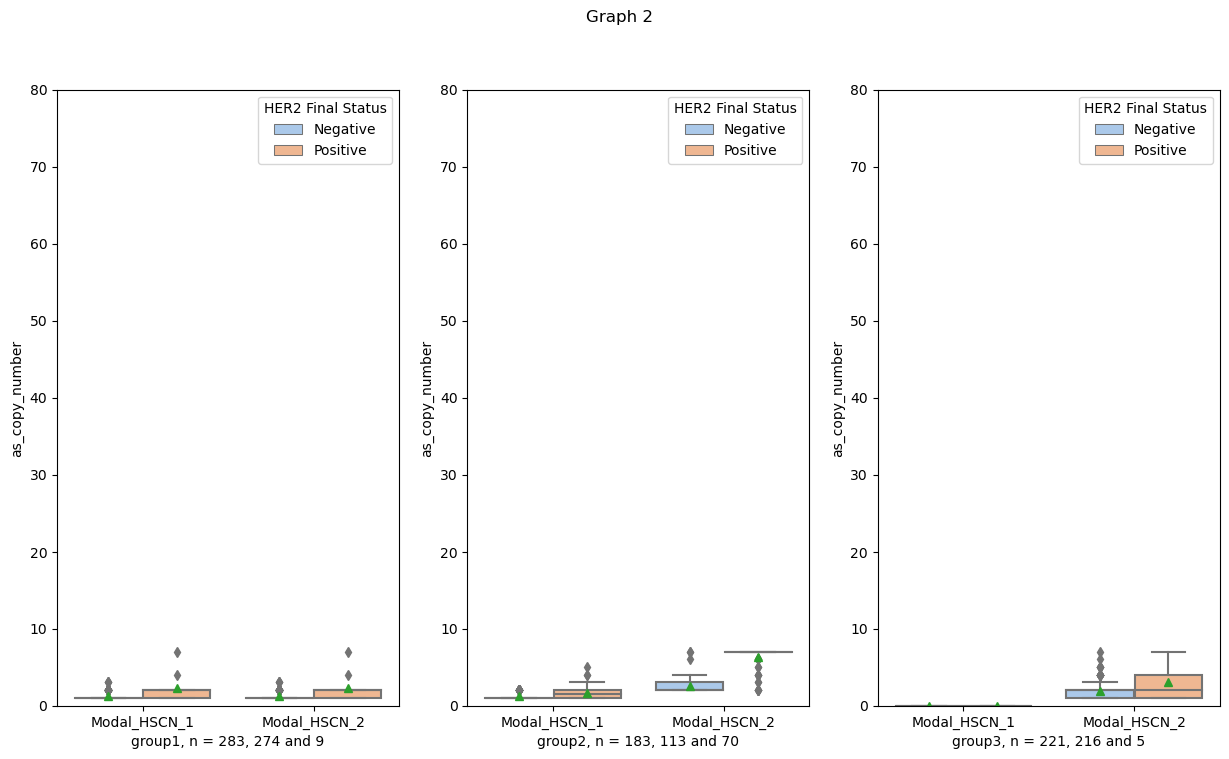

In [17]:
# get saved file
abs_ihc = open_df(processed + 'abs_ihc_for_analysis.csv', sep = ',')

# grouping
as_cn_grouped = grouping(abs_ihc, 'Modal_HSCN_1', 'Modal_HSCN_2')

# tidy copy numbers (major & minor)
as_cn_grouped_tidy = tidy(as_cn_grouped, 'Modal_HSCN_1', 'Modal_HSCN_2', 'as_copy_number', 'allele')

as_cn_grouped_tidy_worded = as_cn_grouped_tidy[['HER2 Final Status', 'allele', 'as_copy_number', 'group']]

group_boxplots(as_cn_grouped_tidy_worded, 'group', 'as_copy_number', 'allele', 'HER2 Final Status', 'Graph 2')

### Statistical testing


In [18]:
# statistical test
iterate_apply_test(as_cn_grouped_tidy_worded, 'group', 'as_copy_number', 'allele', 'HER2 Final Status')

Statistical test for group1:
Mann Whitney U test comparing as_copy_number (two categories: Negative and Positive for the Modal_HSCN_1 allele) results in a p-value of 5.61e-03.
Mann Whitney U test comparing as_copy_number (two categories: Negative and Positive for the Modal_HSCN_2 allele) results in a p-value of 5.61e-03.
Statistical test for group2:
Mann Whitney U test comparing as_copy_number (two categories: Negative and Positive for the Modal_HSCN_1 allele) results in a p-value of 4.52e-05.
Mann Whitney U test comparing as_copy_number (two categories: Negative and Positive for the Modal_HSCN_2 allele) results in a p-value of 4.70e-25.
Statistical test for group3:
Mann Whitney U test comparing as_copy_number (two categories: Negative and Positive for the Modal_HSCN_1 allele) results in a p-value of 1.00e+00.
Mann Whitney U test comparing as_copy_number (two categories: Negative and Positive for the Modal_HSCN_2 allele) results in a p-value of 4.20e-01.


### Logistic regression


---
The two chunks below are for figure making purposes, see [here](#logistic) for the logistic regression analysis of the allele-specific copy numbers.

---

In [19]:
def iterate_workflow(X, y, n_iterations=100, title='Title'):
    '''
    Does n iteration of data splitting, training, predictions 
    with the option to plot confusion tables
    or plots accuracy, precision, recall and F1 as boxplots
    :param X:
    :param y:
    :param n_iterations:
    :return:
    '''
    function_dict = {'logistic':logistic_train_predict, 'forest':random_forest_train_predict}
    
    a_s_lr = [] 
    f_s_lr = []
    a_s_rf = []
    f_s_rf = []
    
    X_test_lr = []
    y_test_lr = []
    predictions_lr = []
    
    coefficients_lr = []
    intercepts_lr = []
    
    
    # logistic regression 
    for n in tqdm(range(n_iterations)):
        X_train, X_test, y_train, y_test = data_split(X, y)
        predictions, model = choose_function(function_dict, 'logistic', X_train, y_train, X_test)
        a_val, p_val, r_val, f_val = get_metrics(y_test, predictions)
        
        coefficients = model.coef_
        intercepts = model.intercept_
        
        a_s_lr.append(a_val)
        f_s_lr.append(f_val)
        
        X_test_lr.append(X_test)
        y_test_lr.append(y_test)
        predictions_lr.append(predictions)
        
        coefficients_lr.append(coefficients)
        intercepts_lr.append(intercepts)
        
    # random forest
    n_iterations = 1
    for n in tqdm(range(n_iterations)):
        X_train, X_test, y_train, y_test = data_split(X, y)
        predictions = choose_function(function_dict, 'forest', X_train, y_train, X_test)
        a_val, p_val, r_val, f_val = get_metrics(y_test, predictions)
        a_s_rf.append(a_val)
        f_s_rf.append(f_val)
    
    # make data frames
    data = pd.DataFrame({'Accuracy_lr':a_s_lr, 
                         'F1-score_lr':f_s_lr, 
                         'X_test_lr':X_test_lr,
                         'y_test_lr':y_test_lr,
                         'predictions_lr':predictions_lr, 
                         'coefficients_lr':coefficients_lr, 
                         'intercepts_lr':intercepts_lr})
    
    data_rf = pd.DataFrame({'Accuracy_rf':a_s_rf, 'F1-score_rf':f_s_rf})
    
    data['Accuracy_lr'] = data['Accuracy_lr']*100
    data_rf['Accuracy_rf'] = data_rf['Accuracy_rf']*100
    
    mean_a_lr = data['Accuracy_lr'].mean()
    mean_f_lr = data['F1-score_lr'].mean()
    mean_a_rf = data_rf['Accuracy_rf'].mean()
    mean_f_rf = data_rf['F1-score_rf'].mean()
    
    fig, axes = plt.subplots(figsize = (12,5), nrows=1, ncols = 4)
    fig.subplots_adjust(wspace=0.5)
    
    sns.boxplot(data=data, y = 'Accuracy_lr', showmeans=True, ax=axes[0], color='red', 
                meanprops={"markerfacecolor":"blue", "markeredgecolor":"black"})
    sns.boxplot(data=data, y = 'F1-score_lr', showmeans=True, ax=axes[1], color='blue', 
               meanprops={"markerfacecolor":"red", "markeredgecolor":"black"})
    sns.boxplot(data=data_rf, y = 'Accuracy_rf', showmeans=True, ax=axes[2], color='red', 
               meanprops={"markerfacecolor":"blue", "markeredgecolor":"black"})
    sns.boxplot(data=data_rf, y = 'F1-score_rf', showmeans=True, ax=axes[3], color='blue', 
               meanprops={"markerfacecolor":"red", "markeredgecolor":"black"})
    
    axes[0].set_ylim(80,100)
    axes[1].set_ylim(0.2,1)
    axes[2].set_ylim(80,100)
    axes[3].set_ylim(0.2,1)
    
    axes[0].set_ylabel('Accuracy (%)')
    axes[1].set_ylabel('F1 score')
    axes[2].set_ylabel('Accuracy (%)')
    axes[3].set_ylabel('F1 score')
    
    
    axes[0].text(1.28, 1.1, 'Logistic regression', horizontalalignment='center', verticalalignment='center', 
                 transform=axes[0].transAxes, fontsize=12)
    axes[2].text(4.25, 1.1, 'Random forest', horizontalalignment='center', verticalalignment='center', 
                 transform=axes[0].transAxes, fontsize=12)
    
    axes[0].set_title(f'x\u0304 = {round(mean_a_lr, 2)}%', fontsize=10)
    axes[1].set_title(f'x\u0304 = {round(mean_f_lr, 2)}', fontsize=10)
    axes[2].set_title(f'x\u0304 = {round(mean_a_rf, 2)}%', fontsize=10)
    axes[3].set_title(f'x\u0304 = {round(mean_f_rf, 2)}', fontsize=10)
    
    fig.suptitle(title, y=1.05)
    fig.savefig(pictures+'boxplots.png', dpi=500, bbox_inches='tight')
    plt.show()
    return data


def model_betas(model):
    '''
    Calculates the decision formula based on the model coefficients and model intercept
    :param model:
    :return: betas of the model
    '''
    coefficients = model.coef_
    intercept = model.intercept_
    beta_1 = coefficients[0,0]
    beta_2 = coefficients[0,1]
    beta_0 = intercept
    # p = (1/(1+pow(e,-(beta_0+beta_1*x_1+beta_2*x_2))))  # get x_1 and x_2 from X_test
    # y = (0.5-beta_0 - beta_1*x)/(beta_2)  # formula to draw the line at p = 0.5
    return beta_0, beta_1, beta_2

In [20]:
def iterate_workflow_all(X, y, n_iterations=100, title='Title'):
    '''
    Does n iteration of data splitting, training, predictions 
    with the option to plot confusion tables
    or plots accuracy, precision, recall and F1 as boxplots
    :param X:
    :param y:
    :param n_iterations:
    :return:
    '''
    function_dict = {'logistic':logistic_train_predict, 'forest':random_forest_train_predict}
    a_s_lr = [] 
    f_s_lr = []
    a_s_rf = []
    f_s_rf = []
    for n in tqdm(range(n_iterations)):
        X_train, X_test, y_train, y_test = data_split(X, y)
        predictions, model = choose_function(function_dict, 'logistic', X_train, y_train, X_test)
        a_val, p_val, r_val, f_val = get_metrics(y_test, predictions)
        a_s_lr.append(a_val)
        f_s_lr.append(f_val)
    for n in tqdm(range(n_iterations)):
        X_train, X_test, y_train, y_test = data_split(X, y)
        predictions = choose_function(function_dict, 'forest', X_train, y_train, X_test)
        a_val, p_val, r_val, f_val = get_metrics(y_test, predictions)
        a_s_rf.append(a_val)
        f_s_rf.append(f_val)
    
    data = pd.DataFrame({'Accuracy_lr':a_s_lr, 'F1-score_lr':f_s_lr, 'Accuracy_rf':a_s_rf, 'F1-score_rf':f_s_rf})
    
    data['Accuracy_lr'] = data['Accuracy_lr']*100
    data['Accuracy_rf'] = data['Accuracy_rf']*100
    
    mean_a_lr = data['Accuracy_lr'].mean()
    mean_f_lr = data['F1-score_lr'].mean()
    mean_a_rf = data['Accuracy_rf'].mean()
    mean_f_rf = data['F1-score_rf'].mean()
    
    fig, axes = plt.subplots(figsize = (12,5), nrows=1, ncols = 4)
    fig.subplots_adjust(wspace=0.5)
    
    sns.boxplot(data=data, y = 'Accuracy_lr', showmeans=True, ax=axes[0], color='red', 
                meanprops={"markerfacecolor":"blue", "markeredgecolor":"black"})
    sns.boxplot(data=data, y = 'F1-score_lr', showmeans=True, ax=axes[1], color='blue', 
               meanprops={"markerfacecolor":"red", "markeredgecolor":"black"})
    sns.boxplot(data=data, y = 'Accuracy_rf', showmeans=True, ax=axes[2], color='red', 
               meanprops={"markerfacecolor":"blue", "markeredgecolor":"black"})
    sns.boxplot(data=data, y = 'F1-score_rf', showmeans=True, ax=axes[3], color='blue', 
               meanprops={"markerfacecolor":"red", "markeredgecolor":"black"})
    
    axes[0].set_ylim(80,100)
    axes[1].set_ylim(0.2,1)
    axes[2].set_ylim(80,100)
    axes[3].set_ylim(0.2,1)
    
    axes[0].set_ylabel('Accuracy (%)')
    axes[1].set_ylabel('F1 score')
    axes[2].set_ylabel('Accuracy (%)')
    axes[3].set_ylabel('F1 score')
    
    
    axes[0].text(1.28, 1.1, 'Logistic regression', horizontalalignment='center', verticalalignment='center', 
                 transform=axes[0].transAxes, fontsize=12)
    axes[2].text(4.25, 1.1, 'Random forest', horizontalalignment='center', verticalalignment='center', 
                 transform=axes[0].transAxes, fontsize=12)
    
    axes[0].set_title(f'x\u0304 = {round(mean_a_lr, 2)}%', fontsize=10)
    axes[1].set_title(f'x\u0304 = {round(mean_f_lr, 2)}', fontsize=10)
    axes[2].set_title(f'x\u0304 = {round(mean_a_rf, 2)}%', fontsize=10)
    axes[3].set_title(f'x\u0304 = {round(mean_f_rf, 2)}', fontsize=10)
    
    fig.suptitle(title, y=1.05)
    fig.savefig(pictures+'boxplots_all.png', dpi=500, bbox_inches='tight')
    plt.show()

def logistic_train_predict(X, y, test_set):
    '''
    uses the input for training and then predicts the values for the test set
    
    :param X: matrix of values for training
    :param y: true labels for training set
    :param test_set: test set (same structure as X) which will be used for the predictions
    :return: list of prediction based on the test_set
    '''
    model = LogisticRegression(random_state=None, max_iter=1000).fit(X, y)
    # print(f'n iterations = {model.n_iter_}')  # prints the number of used iteration until convergence
    
    import math
    params = model.intercept_
    coefficient_a = model.coef_[0,0]
    coefficient_b = model.coef_[0,1]
    intercept = model.intercept_
    
    # print(coefficient_a, coefficient_b, intercept)
    
    return model.predict(test_set), model  

100%|██████████| 1/1 [00:00<00:00,  2.02it/s]


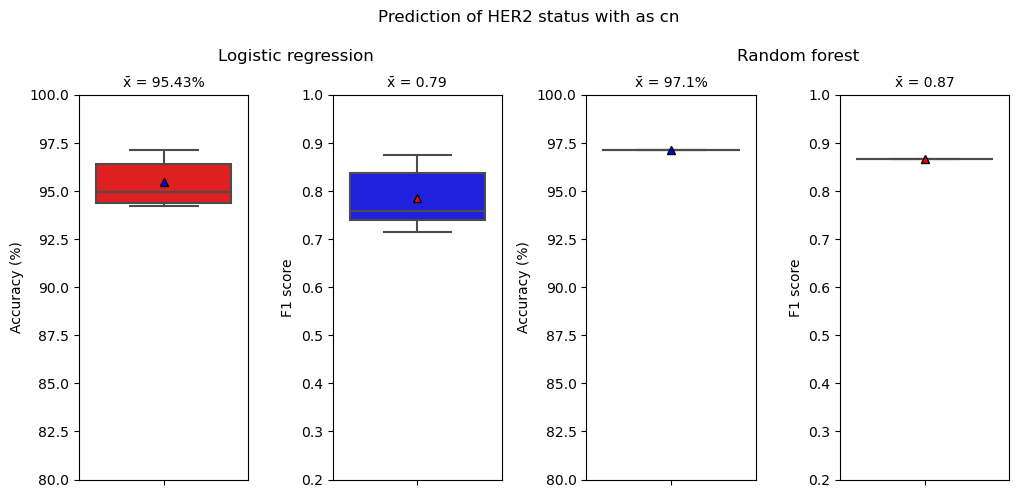

In [22]:
# make a boxplot with logistic regression and random forest

# get saved file
abs_ihc = open_df(processed + 'abs_ihc_for_analysis.csv', sep = ',')

# optional part to normalize the data 
df = abs_ihc.copy()
columns = ['Modal_HSCN_2', 'Modal_HSCN_1', 'ERBB2 exp', 'Modal_Total_CN']
#for column in columns:
#    df[column] = (df[column]-df[column].mean())/df[column].std()
#abs_ihc = df.copy()

# get arrays
X_total = col_to_array(abs_ihc, 'Modal_HSCN_2', 'Modal_HSCN_1')
#X_total = abs_ihc[['Modal_Total_CN', 'Modal_HSCN_1', 'Modal_HSCN_2', 'ERBB2 exp']].to_numpy()
y_total = col_to_array(abs_ihc, 'HER2 Final Status').ravel()

# iterate a full workflow of data splitting, logistic regression, predictions, assessment and score tracking
df = iterate_workflow(X_total, y_total, n_iterations=10,  
                 title='Prediction of HER2 status with as cn')

save_csv(df, processed+'lr_res_10000')



The mean of the F1 score is 0.8045% and the median is 0.8%.


C:\Users\User\anaconda3\lib\site-packages\plotnine\ggplot.py:718: PlotnineWarning: Saving 5 x 5 in image.
C:\Users\User\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Filename: C:\Users\User\Desktop\Big_files\DATA\figures\bubbleplot_high.png


None


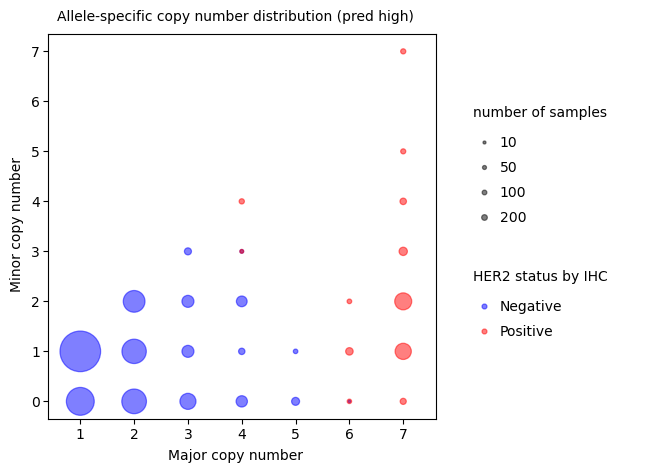

C:\Users\User\anaconda3\lib\site-packages\plotnine\ggplot.py:718: PlotnineWarning: Saving 5 x 5 in image.
C:\Users\User\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Filename: C:\Users\User\Desktop\Big_files\DATA\figures\bubbleplot_low.png


None


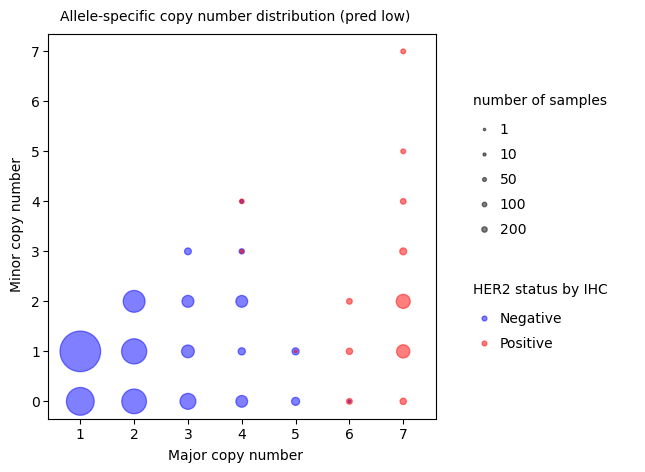

In [23]:
import re

df = open_df(processed+'lr_10000_1.csv', sep=',')
#df = df_subset.copy()
abs_ihc = open_df(processed + 'abs_ihc_for_analysis.csv', sep = ',')

print(f'The mean of the F1 score is {round(df["F1-score_lr"].mean(),4)}% and the median is {round(df["F1-score_lr"].median(),4)}%.')

l = df['F1-score_lr'].to_list()
l = sorted(l)
mi = l[500] # 95% of F1 score are higher than this
ma = l[9500]   # 95% of F1 score are lower than this

df_high = df[df['F1-score_lr']>=ma]
df_low = df[df['F1-score_lr']<=mi]


# df_high

data = dict({'major_cn':[], 
             'minor_cn':[],
             'status':[],
             'predict_status':[]})

for index, row in df_high.iterrows():
    as_cn = row['X_test_lr']
    as_cn = as_cn.replace('\n ', ',')
    as_cn = re.sub(r'(\d+)\s', r'\1,', as_cn)
    array = np.array(eval(as_cn))
    data['major_cn'].append(list(array[:,0]))
    data['minor_cn'].append(list(array[:,1]))
    status_string = row['y_test_lr']
    status = []
    for i in range(len(status_string)):
        if status_string[i] == 'P': status.append('Positive')
        if status_string[i] == 'N': status.append('Negative')
        
    data['status'].append(list(status))
    
    predict_status_string = row['predictions_lr']
    predict_status = []
    for i in range(len(predict_status_string)):
        if predict_status_string[i] == 'P': predict_status.append('Positive')
        if predict_status_string[i] == 'N': predict_status.append('Negative')
        
    data['predict_status'].append(list(predict_status))

data['major_cn'] = [item for sublist in data['major_cn'] for item in sublist]
data['minor_cn'] = [item for sublist in data['minor_cn'] for item in sublist]
data['status'] = [item for sublist in data['status'] for item in sublist]
data['predict_status'] = [item for sublist in data['predict_status'] for item in sublist]

data = pd.DataFrame(data)

data['status'] = data['status'].astype(str)
data['predict_status'] = data['predict_status'].astype(str)

major_mean = abs_ihc['Modal_HSCN_2'].mean()
major_std = abs_ihc['Modal_HSCN_2'].std()
minor_mean = abs_ihc['Modal_HSCN_1'].mean()
minor_std = abs_ihc['Modal_HSCN_1'].std()

data['major_cn'] = round(data['major_cn']*major_std+major_mean,1)
data['minor_cn'] = round(data['minor_cn']*minor_std+minor_mean,1)

data_high = data.copy()

# make figures

df = data.copy()
df.insert(2,'number',1)
df_counted = grouper(df, 'status', 'major_cn', 'minor_cn', 'number')


from plotnine import *

p = (ggplot(df_counted, aes(x='major_cn', y='minor_cn', size='number', color='status')) 
     + geom_point(alpha=0.5) 
     + labs(x='Major copy number', y='Minor copy number', size='number', color='HER2 status by IHC', 
            title='Allele-specific copy numbers from the top 5% iterations based on the F1 score \n (test sets from 500 iterations)')
     + theme_matplotlib()
     + theme(figure_size=(5,5))
     + scale_size_continuous(breaks=[5000, 20000], range = (0.5, 16), name='number of samples')
     + scale_color_manual(values={'Positive': 'red', 'Negative': 'blue'})
     + scale_x_continuous(breaks=[1,2,3,4,5,6,7], minor_breaks=None, expand=(0.1,0))
     + scale_y_continuous(breaks=[0,1,2,3,4,5,6,7], minor_breaks=None)
     
)\
.save(pictures+"bubbleplot_high.png", dpi=500)

print(p)


df = data.copy()
df.insert(2,'number',1)
df_counted = grouper(df, 'predict_status', 'major_cn', 'minor_cn', 'number')

q = (ggplot(df_counted, aes(x='major_cn', y='minor_cn', size='number', color='predict_status')) 
     + geom_point(alpha=0.5) 
     + labs(x='Major copy number', y='Minor copy number', size='number', color='HER2 status by IHC', 
            title='Allele-specific copy number distribution (pred high)')
     + theme_matplotlib()
     + theme(figure_size=(5,5))
     + scale_size_continuous(breaks=[1, 10, 50, 100, 200], range = (0.5, 16), name='number of samples')
     + scale_color_manual(values={'Positive': 'red', 'Negative': 'blue'})
     + scale_x_continuous(breaks=[1,2,3,4,5,6,7], minor_breaks=None, expand=(0.1,0))
     + scale_y_continuous(breaks=[0,1,2,3,4,5,6,7], minor_breaks=None)
     
)

print(q)

# df_low

data = dict({'major_cn':[], 
             'minor_cn':[],
             'status':[],
             'predict_status':[]})

for index, row in df_low.iterrows():
    as_cn = row['X_test_lr']
    as_cn = as_cn.replace('\n ', ',')
    as_cn = re.sub(r'(\d+)\s', r'\1,', as_cn)
    array = np.array(eval(as_cn))
    data['major_cn'].append(list(array[:,0]))
    data['minor_cn'].append(list(array[:,1]))
    status_string = row['y_test_lr']
    status = []
    for i in range(len(status_string)):
        if status_string[i] == 'P': status.append('Positive')
        if status_string[i] == 'N': status.append('Negative')
        
    data['status'].append(list(status))
    
    predict_status_string = row['predictions_lr']
    predict_status = []
    for i in range(len(predict_status_string)):
        if predict_status_string[i] == 'P': predict_status.append('Positive')
        if predict_status_string[i] == 'N': predict_status.append('Negative')
        
    data['predict_status'].append(list(predict_status))

data['major_cn'] = [item for sublist in data['major_cn'] for item in sublist]
data['minor_cn'] = [item for sublist in data['minor_cn'] for item in sublist]
data['status'] = [item for sublist in data['status'] for item in sublist]
data['predict_status'] = [item for sublist in data['predict_status'] for item in sublist]

data = pd.DataFrame(data)

data['status'] = data['status'].astype(str)
data['predict_status'] = data['predict_status'].astype(str)

major_mean = abs_ihc['Modal_HSCN_2'].mean()
major_std = abs_ihc['Modal_HSCN_2'].std()
minor_mean = abs_ihc['Modal_HSCN_1'].mean()
minor_std = abs_ihc['Modal_HSCN_1'].std()

data['major_cn'] = round(data['major_cn']*major_std+major_mean,0)
data['minor_cn'] = round(data['minor_cn']*minor_std+minor_mean,0)

data_low = data.copy()
df = data.copy()
df.insert(2,'number',1)
df_counted = grouper(df, 'status', 'major_cn', 'minor_cn', 'number')


from plotnine import *

p = (ggplot(df_counted, aes(x='major_cn', y='minor_cn', size='number', color='status')) 
     + geom_point(alpha=0.5) 
     + labs(x='Major copy number', y='Minor copy number', size='number', color='HER2 status by IHC', 
            title='Allele-specific copy numbers from the lowest 5% iterations based on the F1 score \n (test sets from 500 iterations)')
     + theme_matplotlib()
     + theme(figure_size=(5,5))
     + scale_size_continuous(breaks=[5000, 20000], range = (0.5, 16), name='number of samples')
     + scale_color_manual(values={'Positive': 'red', 'Negative': 'blue'})
     + scale_x_continuous(breaks=[1,2,3,4,5,6,7], minor_breaks=None, expand=(0.1,0))
     + scale_y_continuous(breaks=[0,1,2,3,4,5,6,7], minor_breaks=None)
     
)\
.save(pictures+"bubbleplot_low.png", dpi=500)
print(p)

df = data.copy()
df.insert(2,'number',1)
df_counted = grouper(df, 'predict_status', 'major_cn', 'minor_cn', 'number')

q = (ggplot(df_counted, aes(x='major_cn', y='minor_cn', size='number', color='predict_status')) 
     + geom_point(alpha=0.5) 
     + labs(x='Major copy number', y='Minor copy number', size='number', color='HER2 status by IHC', 
            title='Allele-specific copy number distribution (pred low)')
     + theme_matplotlib()
     + theme(figure_size=(5,5))
     + scale_size_continuous(breaks=[1, 10, 50, 100, 200], range = (0.5, 16), name='number of samples')
     + scale_color_manual(values={'Positive': 'red', 'Negative': 'blue'})
     + scale_x_continuous(breaks=[1,2,3,4,5,6,7], minor_breaks=None, expand=(0.1,0))
     + scale_y_continuous(breaks=[0,1,2,3,4,5,6,7], minor_breaks=None)
     
)
print(q)



In [ ]:
df = open_df(processed+'lr_10000_1.csv', sep=',')
l = df['F1-score_lr'].to_list()
l = sorted(l)
mi = l[500]
ma = l[9500]
print(mi, ma)
# 10 highest % start at 0.9032258064516128
# 10 lowest percent end at 0.7142857142857143

In [ ]:
df = open_df(processed+'lr_10000_1.csv', sep=',')


li = df['predictions_lr'].to_list()

ratios = []
accs = []

for index, row in df.iterrows():
    li = row['predictions_lr']
    acc = row['F1-score_lr']
    p = 0
    n = 0
    for c in range(len(li)):
        if li[c] == 'P': p += 1
        if li[c] == 'N': n += 1
    ratio = 1/(p+n)*p
    m += 1
    ratios.append(ratio)
    accs.append(acc)
    
plt.hist(accs, bins=30)

# make a figure with the accuracy of the predictions and the ratios of predicted positive

fig, ax = plt.subplots()
ax.scatter(accs, ratios)
plt.show()

# select all rows that have an a ratio as filtered above
index = []
for i in range(len(ratios)):
    if ratios[i] == 0.12318840579710146:
        index.append(i)
df_subset = df.iloc[index]

In [ ]:
data_high

In [ ]:
# make a plot with plotnine

from plotnine import *

df = as_ihc_subset_counted.copy()

p = (ggplot(df, aes(x='Modal_HSCN_2', y='Modal_HSCN_1', size='number', color='HER2 Final Status')) 
     + geom_point(alpha=0.5) 
     + labs(x='Major copy number', y='Minor copy number', size='number', color='HER2 status by IHC', title='Allele-specific copy number distribution')
     + theme_matplotlib()
     + theme(figure_size=(5,5))
     + scale_size_continuous(breaks=[1, 10, 50, 100, 200], range = (0.5, 16), name='number of samples')
     + scale_color_manual(values={'Positive': 'red', 'Negative': 'blue'})
     + scale_x_continuous(breaks=[1,2,3,4,5,6,7], minor_breaks=None, expand=(0.1,0))
     + scale_y_continuous(breaks=[0,1,2,3,4,5,6,7], minor_breaks=None)
     
)\
.save(pictures+"bubbleplot.png", dpi=500)

print(p)

In [ ]:
# make a boxplot with logistic regression and random forest

# get saved file
abs_ihc = open_df(processed + 'abs_ihc_for_analysis.csv', sep = ',')

# optional part to normalize the data 
df = abs_ihc.copy()
columns = ['Modal_Total_CN', 'Modal_HSCN_1', 'Modal_HSCN_2', 'ERBB2 exp']
for column in columns:
    df[column] = (df[column]-df[column].mean())/df[column].std()


fig, axs = plt.subplots(2, 2, figsize=(10, 5))

axs[0,0].hist(df[columns[0]], bins=50)
axs[0,1].hist(df[columns[1]], bins=50)
axs[1,0].hist(df[columns[2]], bins=50)
axs[1,1].hist(df[columns[3]], bins=50)
plt.show()

abs_ihc = df.copy()

In [ ]:

# get arrays
X_total = abs_ihc[['Modal_Total_CN', 'Modal_HSCN_1', 'Modal_HSCN_2', 'ERBB2 exp']].to_numpy()
y_total = col_to_array(abs_ihc, 'HER2 Final Status').ravel()

# iterate a full workflow of data splitting, logistic regression, predictions, assessment and score tracking
lr_4_mod = iterate_workflow(X_total, y_total, n_iterations=10000,  
                 title='Prediction of HER2 status with allele-specific copy numbers')

In [ ]:
beta_0 = lr_res['intercept'].mean()
beta_1 = lr_res['b1'].mean()
beta_2 = lr_res['b2'].mean()

x_vals = np.arange(1.6, 6, 0.1)
y_vals = list(map(lambda i: (np.log(1)+ beta_0 + beta_1*i)/(-beta_2),x_vals))
points = pd.DataFrame({'x':x_vals, 'y':y_vals})


In [ ]:
i = 2
df = lr_res
l = df['F1-score_lr'].to_list()
l = sorted(l)
mi = l[500] # 95% of F1 score are higher than this
ma = l[9500]

lr_res_high = lr_res[lr_res['F1-score_lr']>ma]
lr_res_low = lr_res[lr_res['F1-score_lr']<mi]

df = lr_res_high

beta_0 = df['intercept'].mean()
beta_1 = df['b1'].mean()
beta_2 = df['b2'].mean()

x_vals = np.arange(1.6, 6, 0.1)
y_vals = list(map(lambda i: (np.log(1)+ beta_0 + beta_1*i)/(-beta_2),x_vals))
points = pd.DataFrame({'x':x_vals, 'y':y_vals})

df = open_df(processed+'abs_ihc_for_analysis.csv', sep=',')
df.insert(2,'number',1)
df_counted = grouper(df, 'HER2 Final Status', 'Modal_HSCN_2', 'Modal_HSCN_1', 'number')

p = (ggplot() 
     + geom_point(df_counted, aes(x='Modal_HSCN_2', y='Modal_HSCN_1', size='number', color='HER2 Final Status'), alpha=0.5) 
     + labs(x='Major copy number', y='Minor copy number', size='number', color='HER2 status by IHC', 
            title='Decision line from logistic regression on allele-specific copy numbers')
     + theme_matplotlib()
     + theme(figure_size=(5,5))
     + scale_size_continuous(breaks=[1,10, 50, 200], range = (0.5, 16), name='number of samples')
     + scale_color_manual(values={'Positive': 'red', 'Negative': 'blue'})
     + scale_x_continuous(breaks=[1,2,3,4,5,6,7], minor_breaks=None, expand=(0.1,0))
     + scale_y_continuous(breaks=[0,1,2,3,4,5,6,7], minor_breaks=None)
     + geom_line(points, aes(x='x', y='y'), color='grey')
    
)\
#.save(pictures+"bubbleplot_func_high.png", dpi=500)

print(p)

In [ ]:
from plotnine import *

p = ggplot() + \
    geom_point(df_counted, aes(x='Modal_HSCN_2', y='Modal_HSCN_1', size='number', color='HER2 Final Status'), alpha=0.5) + \
    geom_line(df2, aes(x='x', y='y'), color='red')


print(p)

In [ ]:
from plotnine import *

# create two data frames with x and y values for each line
df1 = pd.DataFrame({'x': [1, 2, 3, 4, 5], 'y': [2, 4, 6, 8, 10]})
df2 = pd.DataFrame({'x': [1, 2, 3, 4, 5], 'y': [1, 3, 5, 7, 9]})

# create the plot using ggplot() and geom_line() for each line
p = ggplot() + \
    geom_line(df1, aes(x='x', y='y'), color='blue') + \
    geom_line(df2, aes(x='x', y='y'), color='red')

# display the plot
print(p)


In [ ]:
lr_res

In [ ]:
lr_res['coefficients_lr'][0]

columns = ['b1', 'b2', 'b3', 'b4']
for i in range(len(columns)):
    column = columns[i]
    df[column] = df['coefficients_lr'].apply(lambda x: x[0][i])

df

In [ ]:
df = lr_res.copy()

fig, axs = plt.subplots(2, 2, figsize=(10, 5))

axs[0,0].hist(df['b1'], bins=50)
axs[0,1].hist(df['b2'], bins=50)
axs[1,0].hist(df['intercept'], bins=50)
axs[1,1].hist(df['intercept'], bins=50)
plt.show()

# we see that the total copy number has coefficients around -0.1
# minor as cn has coeff of about 0.45
# major as cn has coeff of about 1.3 
# gene expression has dimodal distribution, that can probably be separated at 1.6

In [ ]:
df = lr_4_mod_1.copy()

x = df['F1-score_lr'].to_list()
y = df['b4'].to_list()
plt.scatter(x,y)
plt.show()

In [ ]:
df

**logitsic regression anaylsis** <a class="anchor" id="logistic"></a>

In [ ]:
# logistic regression for all data together 

# get arrays
X_total = col_to_array(abs_ihc, 'Modal_HSCN_2', 'Modal_HSCN_1')
y_total = col_to_array(abs_ihc, 'HER2 Final Status').ravel()

# iterate a full workflow of data splitting, logistic regression, predictions, assessment and score tracking
iterate_workflow(X_total, y_total, 'logistic', n_iterations=300, print_table=False, print_boxplot=True, 
                 title='Logistic regression with all groups together')

# logistic regression sorted by group

mask_1 = (abs_ihc['group'] == 'group1')
mask_2 = (abs_ihc['group'] == 'group2')
mask_3 = (abs_ihc['group'] == 'group3')

# get arrays
X_group1 = col_to_array(abs_ihc, 'Modal_HSCN_2', 'Modal_HSCN_1', mask=mask_1)
X_group2 = col_to_array(abs_ihc, 'Modal_HSCN_2', 'Modal_HSCN_1', mask=mask_2)
X_group3 = col_to_array(abs_ihc, 'Modal_HSCN_2', 'Modal_HSCN_1', mask=mask_3)

y_group1 = col_to_array(abs_ihc, 'HER2 Final Status', mask=mask_1).ravel()
y_group2 = col_to_array(abs_ihc, 'HER2 Final Status', mask=mask_2).ravel()
y_group3 = col_to_array(abs_ihc, 'HER2 Final Status', mask=mask_3).ravel()

iterate_workflow(X_group1, y_group1, 'logistic', n_iterations=300, print_table=False, print_boxplot=True, 
                 title='Logistic regression for group1')
iterate_workflow(X_group2, y_group2, 'logistic', n_iterations=300, print_table=False, print_boxplot=True, 
                 title='Logistic regression for group 2')
iterate_workflow(X_group3, y_group3, 'logistic', n_iterations=300, print_table=False, print_boxplot=True, 
                 title='Logistic regression for group 3')

### Random forest

In [ ]:
# random forest for all data together 

# get arrays
X_total = col_to_array(abs_ihc, 'Modal_HSCN_2', 'Modal_HSCN_1')
y_total = col_to_array(abs_ihc, 'HER2 Final Status').ravel()

# iterate a full workflow of data splitting, logistic regression, predictions, assessment and score tracking
iterate_workflow(X_total, y_total, 'logistic', n_iterations=300, print_table=False, print_boxplot=True, 
                 title='Random forest regression with all groups together')

# random forest sorted by group

mask_1 = (abs_ihc['group'] == 'group1')
mask_2 = (abs_ihc['group'] == 'group2')
mask_3 = (abs_ihc['group'] == 'group3')

# get arrays
X_group1 = col_to_array(abs_ihc, 'Modal_HSCN_2', 'Modal_HSCN_1', mask=mask_1)
X_group2 = col_to_array(abs_ihc, 'Modal_HSCN_2', 'Modal_HSCN_1', mask=mask_2)
X_group3 = col_to_array(abs_ihc, 'Modal_HSCN_2', 'Modal_HSCN_1', mask=mask_3)

y_group1 = col_to_array(abs_ihc, 'HER2 Final Status', mask=mask_1).ravel()
y_group2 = col_to_array(abs_ihc, 'HER2 Final Status', mask=mask_2).ravel()
y_group3 = col_to_array(abs_ihc, 'HER2 Final Status', mask=mask_3).ravel()

iterate_workflow(X_group1, y_group1, 'forest', n_iterations=300, print_table=False, print_boxplot=True, 
                 title='Random forest for group1')
iterate_workflow(X_group2, y_group2, 'forest', n_iterations=300, print_table=False, print_boxplot=True, 
                 title='Random forest for group 2')
iterate_workflow(X_group3, y_group3, 'forest', n_iterations=300, print_table=False, print_boxplot=True, 
                 title='Random forest for group 3')

### Model visualization (for linear regression)

In [ ]:
def bubble_scatter(df, x, y, x_label, y_label, hue, size, title='Title', model=None):
    '''
    
    :param df:
    :param x:
    :param y:
    :param x_label:
    :param y_label:
    :param hue:
    :param title:
    :param model:
    :return:
    '''
    
    fig, axes = plt.subplots(figsize = (8,8), nrows=1, ncols = 1)
    
    sns.scatterplot(data=df, x=x, y=y, size=size, hue=hue, ax=axes, alpha = 0.5, sizes = (20,2000))
    if model is not None:
        beta_0, beta_1, beta_2 = model_betas(model)
        x_vals = np.arange(0.6, 17.5, 0.1)
        y_vals = list(map(lambda i: (np.log(1)+ beta_0 + beta_1*i)/(-beta_2),x_vals))
        axes.plot(x_vals, y_vals, '-', c="red")
    axes.set_xlabel(x_label)
    axes.set_ylabel(y_label)
    axes.set_xlim(0.5,10)
    axes.set_ylim(-0.5,8)
    fig.suptitle(title)
    plt.show()
    
def confusion_plot(tn, fp, fn, tp, thr, x, y, x_label_true_neg, x_label_true_pos):
    '''
    Makes a plot with the binary confusion data
    
    :param tn:
    :param fp:
    :param fn:
    :param tp:
    :param thr: threshold used for correct annotation
    :param x: annotation of x-axis (predicted values)
    :param y: annotation of y-axis (true values)
    '''
    true_predictions_perc = round(100* (tp + tn)/(tn + fp + fn + tp), 1)  # used for putting in the title
    data = np.array([[tn, fp], [fn, tp]])  # array for plotting a heatmap 
    fig, ax = plt.subplots()  # creates an empty canvas
    heatmap = ax.imshow(data, cmap='GnBu')  # makes the heatmap with the array and the specified colors 
    for (i, j), val in np.ndenumerate(data):  # goes throught the array and takes the values
        ax.text(j, i, val, ha="center", va="center", color="black")  # print the values in the specific cases
    cbar = fig.colorbar(heatmap)  # adds a colorbar for the heatmap
    ax.set_xticks([0, 1])  # sets a tick
    false = r'$<$'+str(thr)  # math mode + choosen threshold
    true = r'$\geq$'+str(thr)
    ax.set_xticklabels([false, true])
    ax.set_yticks([0, 1])
    ax.set_yticklabels([x_label_true_neg, x_label_true_pos])  # true labels
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_title(f'Confusion Table\n{true_predictions_perc}% were correctly predicted')
    plt.show()

In [ ]:
# subset 
as_ihc_subset = abs_ihc[['HER2 Final Status', 'Modal_HSCN_2', 'Modal_HSCN_1']].copy()

# for subsequent counting, add a column with 1s
as_ihc_subset.insert(3,'number',1)

# group, merge and sum n
as_ihc_subset_counted = grouper(as_ihc_subset, 'HER2 Final Status', 'Modal_HSCN_2', 'Modal_HSCN_1', 'number')
save_csv(as_ihc_subset_counted, processed+'df.csv')

# make a bubble plot
bubble_scatter(as_ihc_subset_counted, x = 'Modal_HSCN_2', y = 'Modal_HSCN_1', 
               x_label = 'Major copy number', y_label = 'Minor copy number', hue = 'HER2 Final Status', 
               size = 'number', title='Allele-specific copy number distribution', model=None)

# make a logistic regression model
X_total = col_to_array(abs_ihc, 'Modal_HSCN_2', 'Modal_HSCN_1')
y_total = col_to_array(abs_ihc, 'HER2 Final Status').ravel()
X_train, X_test, y_train, y_test = data_split(X_total, y_total)
regression_model = LogisticRegression(random_state=None).fit(X_train, y_train)
y_predict = regression_model.predict(X_test)

# make a confusion plot
tn, fp, fn, tp = confusion_table(y_test, y_predict)
confusion_plot_no_thr(tn, fp, fn, tp, 'predictions', 'status by IHC', 'HER2-', 'HER2+')

# plot the predictions with a bubble plot (first get the X_test and y_predict into df)
array = np.column_stack((X_test, y_test))
df_predictions = pd.DataFrame(array, columns=['Modal_HSCN_2', 'Modal_HSCN_1', 'HER2 Final Status'])

df_predictions.insert(3,'number',1)
df_predictions_merged = grouper(df_predictions, 'HER2 Final Status', 'Modal_HSCN_2', 'Modal_HSCN_1', 'number')
bubble_scatter(df_predictions_merged, x = 'Modal_HSCN_2', y = 'Modal_HSCN_1', 
               x_label = 'Major copy number', y_label = 'Minor copy number', hue = 'HER2 Final Status', 
               size = 'number', title='Title', 
               model=regression_model)

**Plot with plotnine**

Making a nice bubble plot with matplotlib was not possible for me. The problem was the legend: I was not able to keep the big bubbles (size) but not having them overlap in the legend. I switched to plotnine, which is a copy of ggplot from R, with limited documentation, but nnonetheless everything I needed. The plot is very customizable, and there is a theme called matplotlib() which makes it look like from matplotlib.

In [ ]:
# make a plot with plotnine

from plotnine import *

df = as_ihc_subset_counted.copy()

p = (ggplot(df, aes(x='Modal_HSCN_2', y='Modal_HSCN_1', size='number', color='HER2 Final Status')) 
     + geom_point(alpha=0.5) 
     + labs(x='Major copy number', y='Minor copy number', size='number', color='HER2 status by IHC', title='Allele-specific copy number distribution')
     + theme_matplotlib()
     + theme(figure_size=(5,5))
     + scale_size_continuous(breaks=[1, 10, 50, 100, 200], range = (0.5, 16), name='number of samples')
     + scale_color_manual(values={'Positive': 'red', 'Negative': 'blue'})
     + scale_x_continuous(breaks=[1,2,3,4,5,6,7], minor_breaks=None, expand=(0.1,0))
     + scale_y_continuous(breaks=[0,1,2,3,4,5,6,7], minor_breaks=None)
     
)\
#.save(pictures+"bubbleplot.png", dpi=500)

print(p)

df

In [ ]:
tp = 0
fp = 0
tn = 0
fn = 0

for index, row in df.iterrows():
    minor = row['Modal_HSCN_1']
    major = row['Modal_HSCN_2']
    m = row['number']
    s = row['HER2 Final Status']
    if minor == 0 and major <= 7: # predicted negative
        if s == 'Negative': tn += m
        else: fn += m
    elif 1 <= minor <= 2 and major <= 4: # predicted negative
        if s == 'Negative': tn += m
        else: fn += m
    elif minor == 3 and major == 3: # predicted negative
        if s == 'Negative': tn += m
        else: fn += m
    else: # predicted positive
        if s == 'Positive': tp += m
        else: fp += m

acc = round(100*((tp + tn) / (tp+tn+fp+fn)), 2)
print(acc)

# 6 BRCA gene expression <a class="anchor" id="6"></a> [↑](#Content)

## 6.1 New TCGA expression <a class="anchor" id="6.1"></a> [↑](#Content)

In [ ]:
save = True  

# python version
# 3.9.7

# imports

import os 
import pandas as pd 
import numpy as np

# directory for processed files
processed = 'C:\\Users\\User\\Desktop\\Big_files\\DATA\\processed_files\\'

In [24]:
# functions

def open_df(file, sep = '\t', header = 0):
    '''
    Opens a file as pandas dataframe

    :param file: file path and name including extension 
    :return: pd.DataFrame()
    '''
    try:
        df = pd.read_csv(file, sep=sep, low_memory=False, header = header)
        return df
    except:
        print(f'Error opening {file}')

def counter(df, col1=None, col2=None):
    '''
    Counts how many rows the df has and what the columns are.
    If a col1 or col2 is specified, return what the values are
    :param df:
    :param col1: 
    :param col2:
    :return: printed statement
    '''
    for i in df:
        j = len(df[i])
        print(f'Column {i} has {j} values')
    if col1 is not None:
        val = df[col1].value_counts()
        print(f'Column {col1} has the following values \n {val}')
    if col2 is not None:
        val = df[col2].value_counts()
        print(f'Column {col2} has the following values \n {val}')
    print('-------------------------------------')
    
def save_csv(df, file_path):
    '''
    saves the df to a .csv file
    if save == True
    
    :param df:
    :param file_path: file name or path (without extension)
    :return: None
    '''
    if save == True:
        df.to_csv(f'{file_path}.csv', header = True, index = False)

In [ ]:
# required data: gene expression from TCGA for ERBB2 only
ge = open_df(processed + 'gene_expression.csv', sep=',')
ge = ge[ge['gene_name'] == 'ERBB2']

# required data: HER2 status by IHC from TCGA
ihc = open_df(processed + 'her2_status_ihc.csv', sep = ',')

# subset gene expression to primary tumors
ge_primary = ge[ge['sample_type'] == 'Primary Tumor'].copy()
print(f'df reduced from {len(ge["sample_type"])} to {len(ge_primary["sample_type"])} rows')

# add IHC data, matching on case_id (because IHC data has no information about sample)
counter(ihc, 'HER2 Final Status')
ge_primary_ihc = pd.merge(ge_primary, ihc, left_on = 'case_id', right_on = 'Complete TCGA ID', how = 'left')
counter(ge_primary_ihc, 'HER2 Final Status')

# keep only rows which have IHC status 'Positive' or 'Negative'
ge_ihc = ge_primary_ihc[ge_primary_ihc['HER2 Final Status'].str.contains('Positive|Negative', regex=True, na=False)]
print(f'by keeping only "Positive" and "Negative", the rows went from {len(ge_primary_ihc["HER2 Final Status"])} to {len(ge_ihc["HER2 Final Status"])}')

# check for patients that have more than one primary tumor samples
print(f'following case_id are present more than once: \n {ge_ihc[ge_ihc.duplicated(["case_id"])]["case_id"].tolist()}')

# adding the information if FFPE
sample_ge = 'C:\\Users\\User\\Desktop\\Big_files\\DATA\\TCGA mc3\\TCGA mc3\\BRCA Gene Expression Quantification\\metadata\\biospecimen\\sample.tsv'
samples = open_df(sample_ge)[['sample_submitter_id', 'is_ffpe']].copy()
ge_ihc_ffpe = pd.merge(ge_ihc, samples, left_on = 'sample_id', right_on = 'sample_submitter_id', how = 'left')

# drop all rows where FFPE is true
ge_ihc_no_ffpe = ge_ihc_ffpe[ge_ihc_ffpe['is_ffpe'] == False].copy()
print(f'by keeping only "is_ffpe" = False, the rows went from {len(ge_ihc_ffpe["sample_id"])} to {len(ge_ihc_no_ffpe["sample_id"])}')

# check for patient that have more than one primary tumor samples
print(f'following case_id are present more than once: \n {ge_ihc_no_ffpe[ge_ihc_no_ffpe.duplicated(["case_id"])]["case_id"].tolist()}')

save_csv(ge_ihc_no_ffpe, processed + 'ge_ihc_no_ffpe')

**Handling of duplicates**

There are now still two duplicates, `TCGA-A7-A26E` and `TCGA-A7-A26J`. Both present different gene expression data. For the moment, they are kept. 

### Visualization



In [25]:
# imports
import seaborn as sns
import matplotlib.pyplot as plt

# functions

def violin_plot(df, x, y, x_label, y_label, hue = None, title='Title'):
    '''
    Make a violin plot with the gene expression data, separated by HER2 status by IHC
    
    :param df: input df, must be clean and tidy for seaborn (long format)
    :param x: x-axis, thought to be the HER2 status by IHC
    :param y: y-axis, thought to be the gene expression
    :param x_label:
    :param y_label: 
    :param title:
    :return: print the plots
    '''
    fig, ax = plt.subplots()
    
    sns.violinplot(data = df, x = x, y = y, hue = hue, split = True)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    fig.suptitle(title)
    plt.show()
    
def swarm_plot(df, x, y, x_label, y_label, hue = None, title='Title'):
    '''
    Make a swarm plot with the gene expression data, separated by HER2 status by IHC
    
    :param df: input df, must be clean and tidy for seaborn (long format)
    :param x: x-axis, thought to be the HER2 status by IHC
    :param y: y-axis, thought to be the gene expression
    :param x_label:
    :param y_label: 
    :param title:
    :return: print the plots
    '''
    fig, ax = plt.subplots()
    
    sns.swarmplot(data = df, x = x, y = y, hue = hue)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_yscale('log')
    fig.suptitle(title)
    plt.show()

def box_plot(df, x, y, x_label, y_label, hue = None, title='Title'):
    '''
    Make a swarm plot with the gene expression data, separated by HER2 status by IHC
    
    :param df: input df, must be clean and tidy for seaborn (long format)
    :param x: x-axis, thought to be the HER2 status by IHC
    :param y: y-axis, thought to be the gene expression
    :param x_label:
    :param y_label: 
    :param title:
    :return: print the plots
    '''
    fig, ax = plt.subplots()
    
    sns.boxplot(data = df, x = x, y = y, hue = hue)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_yscale('log')
    fig.suptitle(title)
    plt.show()

In [ ]:
# prepare data ? 


# make a plot with the tpm_unstranded
violin_plot(ge_ihc_no_ffpe, x = 'HER2 Final Status', y = 'tpm_unstranded', 
            x_label = 'HER2 Status by IHC', y_label = 'TPM (unstranded)', title='Gene expression')

## 6.2 Old TCGA expression <a class="anchor" id="6.2"></a> [↑](#Content)

We have the TPM and the percentiles. The first visualization represents the TPM followed by the percentiles.

### Visualization

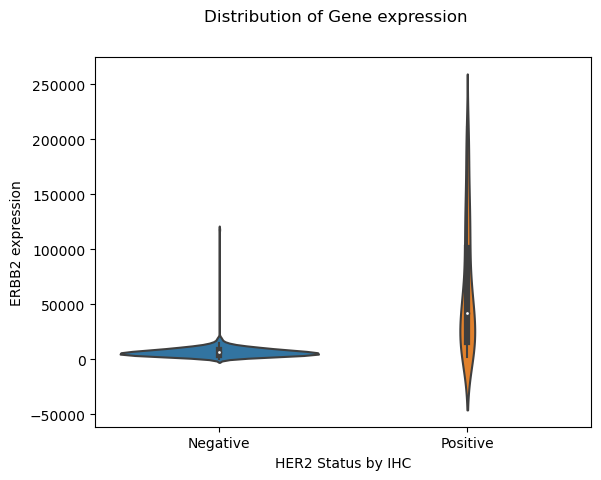

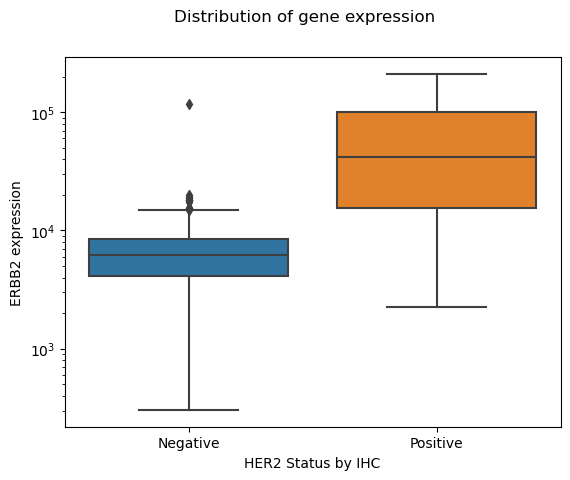

C:\Users\User\anaconda3\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 69.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
C:\Users\User\anaconda3\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 33.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


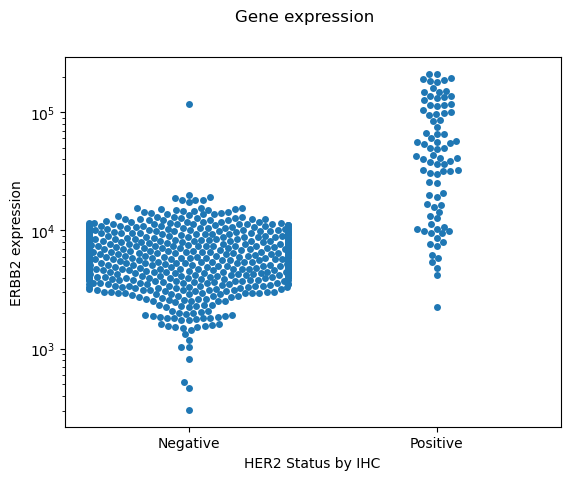

In [26]:
# get file in
abs_ge = open_df(processed + 'abs_ihc_for_analysis.csv', sep = ',')

# make a plot with ERBB2 expression
violin_plot(abs_ge, x = 'HER2 Final Status', y = 'ERBB2 exp', 
            x_label = 'HER2 Status by IHC', y_label = 'ERBB2 expression', title='Distribution of Gene expression')

box_plot(abs_ge, x = 'HER2 Final Status', y = 'ERBB2 exp', 
            x_label = 'HER2 Status by IHC', y_label = 'ERBB2 expression', title='Distribution of gene expression')

swarm_plot(abs_ge, x = 'HER2 Final Status', y = 'ERBB2 exp', 
            x_label = 'HER2 Status by IHC', y_label = 'ERBB2 expression', title='Gene expression')

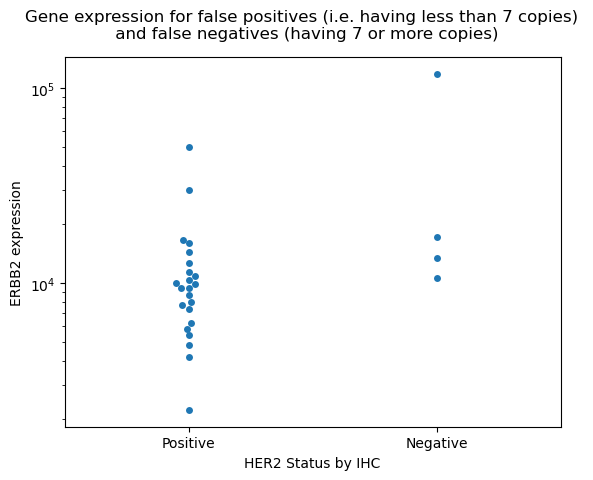

In [27]:
# look only at cases that can't be separated with copy numbers
def false_neg(df):
    return (df['HER2 Final Status'] == 'Positive') & (df['Modal_Total_CN'] < 7) 

def false_pos(df):
    return (df['HER2 Final Status'] == 'Negative') & (df['Modal_Total_CN'] >= 7) 

df = abs_ge.loc[false_neg(abs_ge) + false_pos(abs_ge)]
#print(df.loc[:, ['HER2 Final Status', 'Modal_Total_CN', 'ERBB2 exp']])

swarm_plot(df, x = 'HER2 Final Status', y = 'ERBB2 exp', 
            x_label = 'HER2 Status by IHC', y_label = 'ERBB2 expression', 
            title='Gene expression for false positives (i.e. having less than 7 copies) \n and false negatives (having 7 or more copies)')


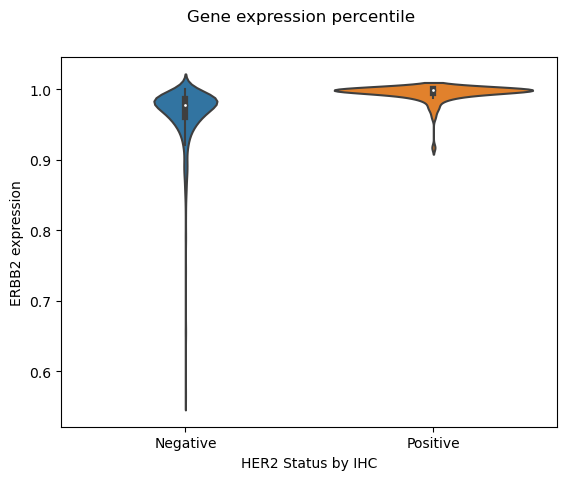

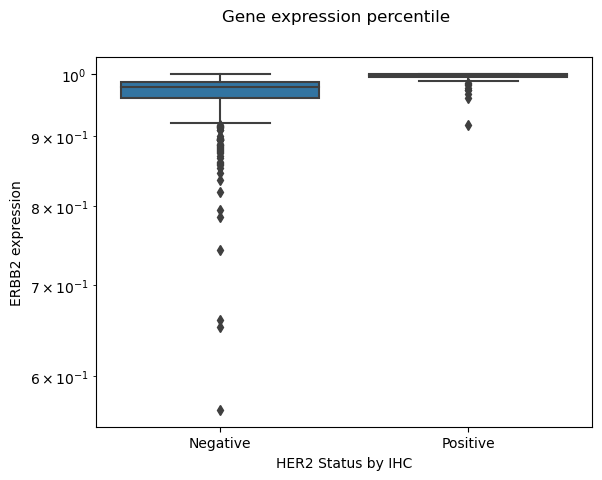

C:\Users\User\anaconda3\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 37.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
C:\Users\User\anaconda3\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 20.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
C:\Users\User\anaconda3\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 63.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
C:\Users\User\anaconda3\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 52.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


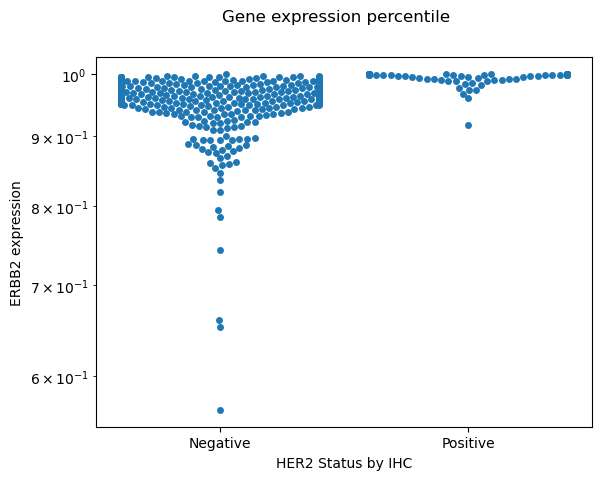

In [28]:
# expression percentiles 
violin_plot(abs_ge, x = 'HER2 Final Status', y = 'ERBB2 exp percentile', 
            x_label = 'HER2 Status by IHC', y_label = 'ERBB2 expression', title='Gene expression percentile')

box_plot(abs_ge, x = 'HER2 Final Status', y = 'ERBB2 exp percentile', 
            x_label = 'HER2 Status by IHC', y_label = 'ERBB2 expression', title='Gene expression percentile')

swarm_plot(abs_ge, x = 'HER2 Final Status', y = 'ERBB2 exp percentile', 
            x_label = 'HER2 Status by IHC', y_label = 'ERBB2 expression', title='Gene expression percentile')

### Thresholding

In [29]:
# imports

import os 
import pandas as pd 
import numpy as np

from sklearn import metrics

from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

from matplotlib.ticker import MaxNLocator

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from tqdm import tqdm

# functions

def cn_converter(df, col, thr):
    '''
    Transforms the numbers in a choosen col to 1 or 0 
    depending on the choosen threshold. 
    
    :param df:
    :param col: column where threshold is applied
    :param thr: threshold. Note: threshold value and higher is positive
    :return: df with transformed col (rest stays the same)
    '''
    df = df.copy()
    df[col] = np.where(df[col] >= thr, 1, 0)
    return df

def ihc_converter(df, col, pos, neg):
    '''
    Modifies the status by IHC to binary based 
    on the two specified values (everything else = None)
    
    :param df: input df
    :param col: column where the IHC status is
    :param pos: values that are converted to 1
    :param neg: values that are converted to 0
    :return: df with transformed col (rest of df stays the same)
    '''
    rules = {pos:1, neg:0}
    rest = list(df[col].unique())
    rest.remove(pos)
    rest.remove(neg)
    for i in rest:
        rules[str(i)] = None
    return df.replace({col: rules})

def confusion(df, col1, col2):
    '''
    Calculates the confusion table from two specified columns
    
    :param df:
    :param col1: ground-truth
    :param col2: predicted values
    :return:
    '''
    truth = list(df[col1])
    predictions = list(df[col2])
    tn, fp, fn, tp = metrics.confusion_matrix(truth, predictions, normalize=None).ravel() # ravel() used as the functions returns an array
    return tn, fp, fn, tp

def confusion_plot(tn, fp, fn, tp, thr, x, y, x_label_true_neg, x_label_true_pos):
    '''
    Makes a plot with the binary confusion data
    
    :param tn:
    :param fp:
    :param fn:
    :param tp:
    :param thr: threshold used for correct annotation
    :param x: annotation of x-axis (predicted values)
    :param y: annotation of y-axis (true values)
    '''
    true_predictions_perc = round(100* (tp + tn)/(tn + fp + fn + tp), 2)  # used for putting in the title
    data = np.array([[tn, fp], [fn, tp]])  # array for plotting a heatmap 
    fig, ax = plt.subplots(figsize= (4,4))  # creates an empty canvas
    heatmap = ax.imshow(data, cmap='PuBuGn')  # makes the heatmap with the array and the specified colors 
    for (i, j), val in np.ndenumerate(data):  # goes throught the array and takes the values
        ax.text(j, i, val, ha="center", va="center", color="black")  # print the values in the specific cases
    cbar = fig.colorbar(heatmap)  # adds a colorbar for the heatmap
    cbar.ax.yaxis.label.set_fontfamily('sans-serif')
    ax.set_xticks([0, 1])  # sets a tick
    false = r'$<$'+str(thr)  # math mode + choosen threshold
    true = r'$\geq$'+str(thr)
    ax.set_xticklabels([false, true])
    ax.set_yticks([0, 1])
    ax.set_yticklabels([x_label_true_neg, x_label_true_pos])  # true labels
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_title(f'Correlation of the gene expression \n with the status by IHC \n', fontsize=10, loc='center')  #, pad=20)
    ax.text(0.5, 1.03, f'Accuracy = {true_predictions_perc}%, Threshold = {thr} TPM', transform=ax.transAxes, fontsize=8, ha='center')
    fig.savefig(pictures+'confusion_plot_TPM.png', dpi=500, bbox_inches='tight')
    plt.show()
    
def threshold_accuracy(df_in, col1, col2, min_thr, max_thr):
    '''
    Calculates the accuracy of copy numbers predictions for status 
    for several thresholds and returns the accuracy vs the threshold
    
    :param df: df with ground-truth and copy numbers 
    :param col1: gound-truth
    :param col2: copy numbers
    :param min_thr:
    :param max_thr: 
    :return: two lists of threshold and accuracies
    '''
    df_in = ihc_converter(df_in, col1, 'Positive', 'Negative')

    thresholds = list(range(min_thr, max_thr, 100))
    accuracy_scores = []
    
    for thr in thresholds:
        df = df_in.copy()
        
        df[col2] = np.where(df[col2] >= thr, 1, 0)
        
        truth = list(df[col1])
        predictions = list(df[col2])
        acc = accuracy_score(truth, predictions)
        accuracy_scores.append(acc)
    return thresholds, accuracy_scores

def threshold_f1(df_in, col1, col2, min_thr, max_thr):
    '''
    Calculates the f1-scores of copy numbers predictions for status 
    for several thresholds and returns the f1 scores vs the threshold
    
    :param df: df with ground-truth and copy numbers 
    :param col1: gound-truth
    :param col2: copy numbers
    :param min_thr:
    :param max_thr: 
    :return: two lists of threshold and f1 scores
    '''
    df_in = ihc_converter(df_in, col1, 'Positive', 'Negative')

    thresholds = list(range(min_thr, max_thr, 100))
    f1_scores = []
    
    for thr in thresholds:
        df = df_in.copy()
        
        df[col2] = np.where(df[col2] >= thr, 1, 0)
        
        truth = list(df[col1])
        predictions = list(df[col2])
        f1 = f1_score(truth, predictions)
        f1_scores.append(f1)
        
    return thresholds, f1_scores

def scatter_plot(list1, list2, title='title'): 
    '''
    Plots the two lists in a scatter plot 
    and indicate which threshold led to the 
    highest value
    
    :param lsit1: x-axis, list of thresholds
    :param list2: y-axis, accuracy or other score
    :return:
    '''
    index = max(enumerate(list2),key=lambda x: x[1])[0]
    best_thr = round(list1[index],2)

    list_2_transformed = []
    for i in list2:
        j = round(i*100, 2)
        list_2_transformed.append(j)
    list2 = list_2_transformed
    
    fig, ax = plt.subplots()
    ax.scatter(list1, list2, color='mediumseagreen', marker='.')
    ax.set_title(title)
    # plt.xticks(range(min(list1),max(list1),2))
    ax.set_xlabel('Threshold of $ERBB2$ gene expression (TPM)')
    ax.set_ylabel('Prediction accuracy %')
    fig.savefig(pictures+'thrshold.png', dpi=500, bbox_inches='tight')
    plt.show()
    
def scatter_plot_f1(list1, list2, title='title'): 
    '''
    Plots the two lists in a scatter plot
    
    :param lsit1:
    :param list2:
    :retunr:
    '''
    index = max(enumerate(list2),key=lambda x: x[1])[0]
    best_thr = round(list1[index],2)
    
    print(list2[index])
    
    fig, ax = plt.subplots()
    ax.scatter(list1, list2, color='mediumseagreen', marker='.')
    ax.set_title(title)
    # plt.xticks(range(min(list1),max(list1)+1,1))
    ax.set_xlabel('Threshold of $ERBB2$ gene expression (TPM)')
    ax.set_ylabel('Prediction F1 score')
    fig.savefig(pictures+'thrshold_f1.png', dpi=500, bbox_inches='tight')
    plt.show()

Threshold gene expression below<a class="anchor" id="exp"></a>.

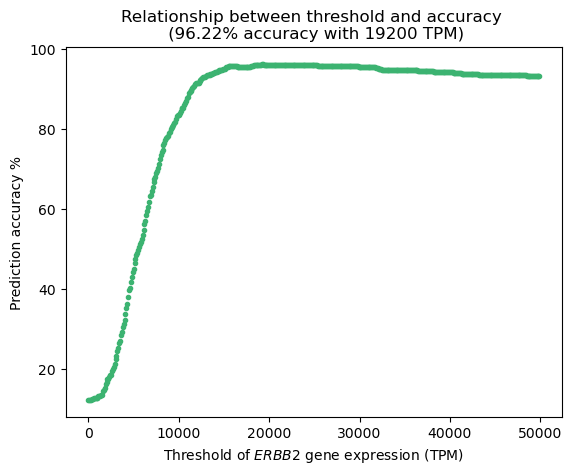

0.821917808219178


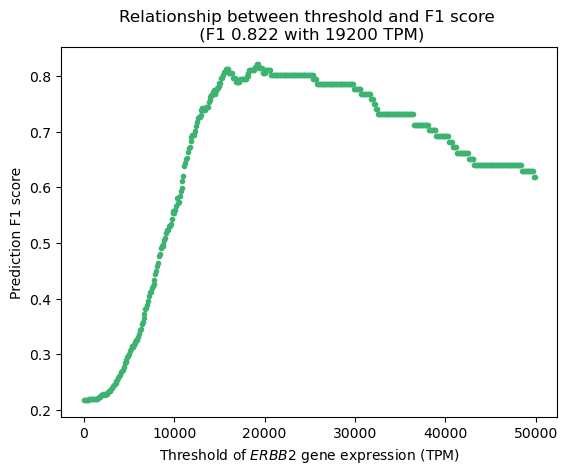

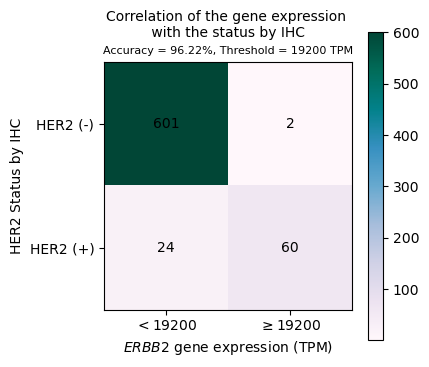

In [30]:
# get file in
abs_ge = open_df(processed + 'abs_ihc_for_analysis.csv', sep = ',')

# making a function of the threshold and the accuracy and f1 score
scatter_plot(*threshold_accuracy(abs_ge, 'HER2 Final Status', 'ERBB2 exp', 0, 50000), 
             title = 'Relationship between threshold and accuracy \n (96.22% accuracy with 19200 TPM)')
scatter_plot_f1(*threshold_f1(abs_ge, 'HER2 Final Status', 'ERBB2 exp', 0, 50000), 
             title = 'Relationship between threshold and F1 score \n (F1 0.822 with 19200 TPM)')

# making a confusion plot with the gene expression set to a threshold

# setting the threshold
threshold = 19200

# tranforming the copy number to binary
abs_ge_converted = cn_converter(abs_ge, 'ERBB2 exp', threshold)

# transforming the status by IHC
abs_ge_converted = ihc_converter(abs_ge_converted, 'HER2 Final Status', 'Positive', 'Negative')

# calculating confusion matrix
tn, fp, fn, tp = confusion(abs_ge_converted, 'HER2 Final Status', 'ERBB2 exp')

# making a plot
confusion_plot(tn, fp, fn, tp, threshold, '$ERBB2$ gene expression (TPM)', 'HER2 Status by IHC', 'HER2 (-)', 'HER2 (+)')

In [32]:
def threshold_accuracy(df_in, col1, col2, min_thr, max_thr):
    '''
    Calculates the accuracy of copy numbers predictions for status 
    for several thresholds and returns the accuracy vs the threshold
    
    :param df: df with ground-truth and copy numbers 
    :param col1: gound-truth
    :param col2: copy numbers
    :param min_thr:
    :param max_thr: 
    :return: two lists of threshold and accuracies
    '''
    df_in = ihc_converter(df_in, col1, 'Positive', 'Negative')

    thresholds = list(np.arange(min_thr, max_thr, 0.01))
    accuracy_scores = []
    
    for thr in thresholds:
        df = df_in.copy()
        
        df[col2] = np.where(df[col2] >= thr, 1, 0)
        
        truth = list(df[col1])
        predictions = list(df[col2])
        acc = accuracy_score(truth, predictions)
        accuracy_scores.append(acc)
    return thresholds, accuracy_scores

def threshold_f1(df_in, col1, col2, min_thr, max_thr):
    '''
    Calculates the f1-scores of copy numbers predictions for status 
    for several thresholds and returns the f1 scores vs the threshold
    
    :param df: df with ground-truth and copy numbers 
    :param col1: gound-truth
    :param col2: copy numbers
    :param min_thr:
    :param max_thr: 
    :return: two lists of threshold and f1 scores
    '''
    df_in = ihc_converter(df_in, col1, 'Positive', 'Negative')

    thresholds = list(np.arange(min_thr, max_thr, 0.01))
    f1_scores = []
    
    for thr in thresholds:
        df = df_in.copy()
        
        df[col2] = np.where(df[col2] >= thr, 1, 0)
        
        truth = list(df[col1])
        predictions = list(df[col2])
        f1 = f1_score(truth, predictions)
        f1_scores.append(f1)
        
    return thresholds, f1_scores

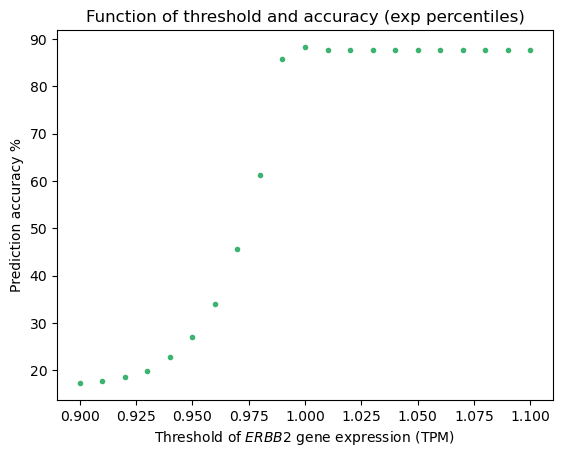

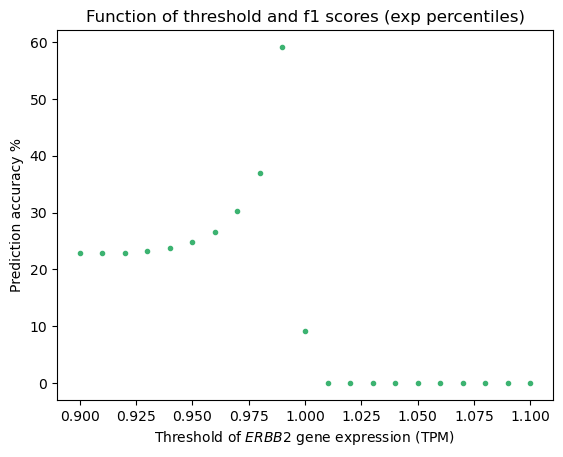

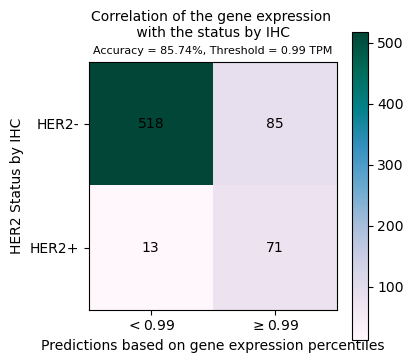

In [33]:
# making a function of the threshold and the accuracy and f1 score
scatter_plot(*threshold_accuracy(abs_ge, 'HER2 Final Status', 'ERBB2 exp percentile', 0.9, 1.1), 
             title = 'Function of threshold and accuracy (exp percentiles)')
scatter_plot(*threshold_f1(abs_ge, 'HER2 Final Status', 'ERBB2 exp percentile', 0.9, 1.1), 
             title = 'Function of threshold and f1 scores (exp percentiles)')

# making a confusion plot with the gene expression percentile set to a threshold

# setting the threshold
threshold = 0.99

# tranforming the copy number to binary
abs_ge_converted = cn_converter(abs_ge, 'ERBB2 exp percentile', threshold)

# transforming the status by IHC
abs_ge_converted = ihc_converter(abs_ge_converted, 'HER2 Final Status', 'Positive', 'Negative')

# calculating confusion matrix
tn, fp, fn, tp = confusion(abs_ge_converted, 'HER2 Final Status', 'ERBB2 exp percentile')

# making a plot
confusion_plot(tn, fp, fn, tp, threshold, 'Predictions based on gene expression percentiles', 'HER2 Status by IHC', 'HER2-', 'HER2+')

## 6.3 Protein expression <a class="anchor" id="6.3"></a> [↑](#Content)

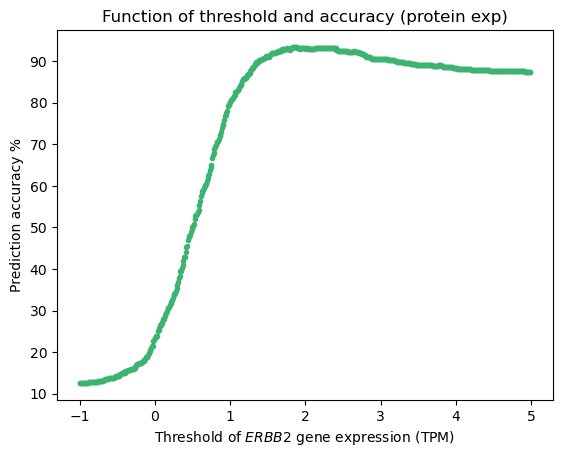

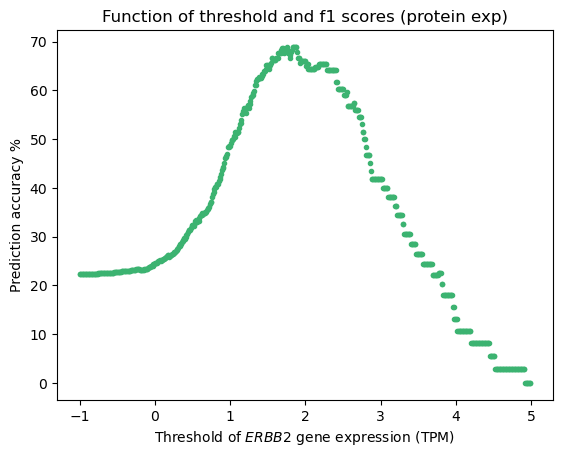

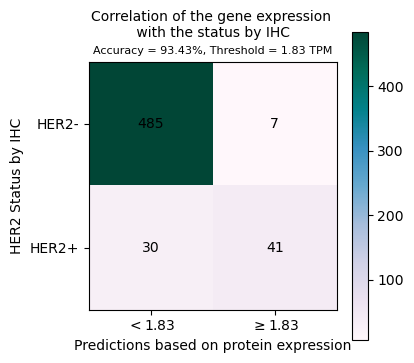

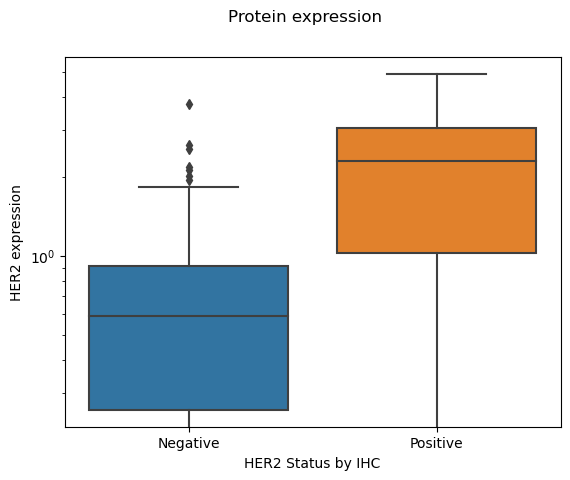

C:\Users\User\anaconda3\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 8.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


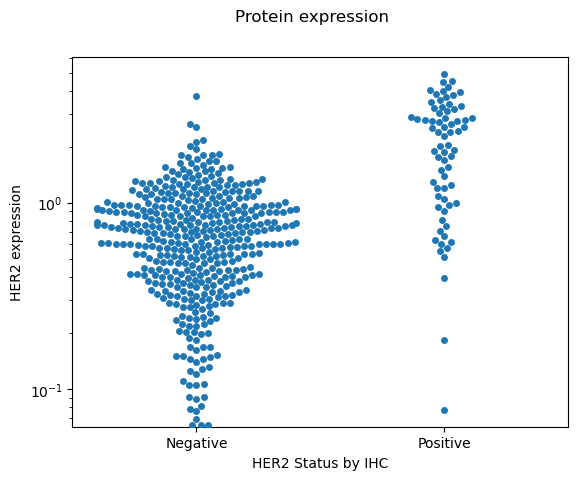

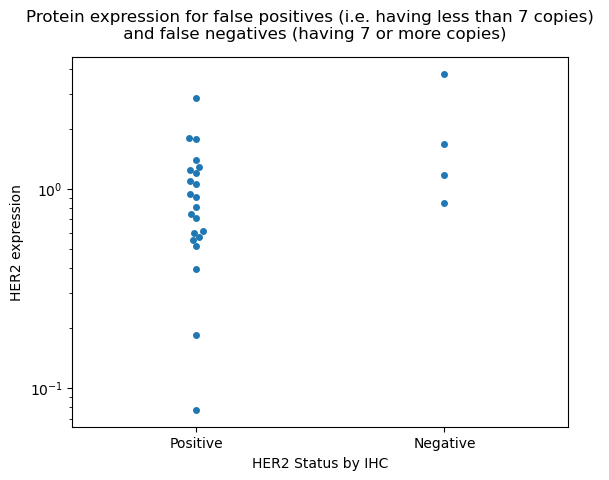

In [34]:
protein = 'C:\\Users\\User\\Desktop\\Big_files\\DATA\\david-tcga-abs-annotated\\TCGA-RPPA-pancan-clean.txt'

# directory for processed files
processed = 'C:\\Users\\User\\Desktop\\Big_files\\DATA\\processed_files\\'

abs_ihc = open_df(processed + 'abs_ihc_for_analysis.csv', sep = ',')

df = open_df(protein)
df = df[df['TumorType'].eq('BRCA')][['SampleID', 'HER2']]
#print(df['SampleID'].value_counts())
#print(abs_ihc['sample vial'].value_counts())

df['SampleID'] = df['SampleID'].str[0:16]

df = pd.merge(abs_ihc, df, left_on = 'sample vial', right_on = 'SampleID', how = 'inner')
df.rename(columns={'HER2':'HER2_protein'})
save_csv(df, processed + 'abs_ihc_with_protein')

# making a function of the threshold and the accuracy and f1 score
scatter_plot(*threshold_accuracy(df, 'HER2 Final Status', 'HER2', -1, 5), 
             title = 'Function of threshold and accuracy (protein exp)')
scatter_plot(*threshold_f1(df, 'HER2 Final Status', 'HER2', -1, 5), 
             title = 'Function of threshold and f1 scores (protein exp)')

# making a confusion plot with the protein expression set to a threshold

# setting the threshold
threshold = 1.83

# tranforming the copy number to binary
df_converted = cn_converter(df, 'HER2', threshold)

# transforming the status by IHC
df_converted = ihc_converter(df_converted, 'HER2 Final Status', 'Positive', 'Negative')

# calculating confusion matrix
tn, fp, fn, tp = confusion(df_converted, 'HER2 Final Status', 'HER2')

# making a plot
confusion_plot(tn, fp, fn, tp, threshold, 'Predictions based on protein expression', 'HER2 Status by IHC', 'HER2-', 'HER2+')

box_plot(df, x = 'HER2 Final Status', y = 'HER2', 
            x_label = 'HER2 Status by IHC', y_label = 'HER2 expression', title='Protein expression')

swarm_plot(df, x = 'HER2 Final Status', y = 'HER2', 
            x_label = 'HER2 Status by IHC', y_label = 'HER2 expression', title='Protein expression')

# look only at cases that can't be separated with total copy numbers
def false_neg(df):
    return (df['HER2 Final Status'] == 'Positive') & (df['Modal_Total_CN'] < 7) 

def false_pos(df):
    return (df['HER2 Final Status'] == 'Negative') & (df['Modal_Total_CN'] >= 7) 

df = df.loc[false_neg(df) + false_pos(df)]
#print(df.loc[:, ['HER2 Final Status', 'Modal_Total_CN', 'ERBB2 exp']])

swarm_plot(df, x = 'HER2 Final Status', y = 'HER2', 
            x_label = 'HER2 Status by IHC', y_label = 'HER2 expression', 
            title='Protein expression for false positives (i.e. having less than 7 copies) \n and false negatives (having 7 or more copies)')


# 7 All datatype integration <a class="anchor" id="7"></a> [↑](#Content)

With the plots above, we know that the total copy numbers can help us be over [96.1%](#total_cn) predictive for the HER2 status. It looks like the allele-specific copy numbers were not able to further refine this. Also the gene expression has a similar power of separation as the total copy number does ([95.7%](#exp)).

The integration of both data modalities could help us improve this. There are several options we could do that:

* Set a threshold for total copy numbers and gene expression and combine the two. There are three sensible ways to combine them: 
    * Both modalities are 1, therefore we predict the status as 1
    * Total copy number is 1 and gene expression is 0, therefore we predict the status as 1
    * The opposite, only the gene expression is 1, and we say the status is 1

This would mean that the thresholds may need to be adjusted. We could represent this in a heatmap, where the x-axis is the copy number threshold and the y-axis is the expression threshold, and the color represent the F1 score. 

* Logistic regression or random forest with the raw numbers:
    * Total copy number and gene expression (TPM or percentiles)
    * Allele-specific copy numbers and gene expression (TPM or percentiles)
    
A next step would be to integrate more than one gene in the expression profile, meaning we could have the status by IHC vs the status predicted with total copy numbers and compare how the gene expression is for a few genes in the *ERBB2* pathway. Look at this [KEGG pathway](https://www.genome.jp/pathway/map04012+K05083) for example.

* Logistic regression or random forest on 5 *ERBB2* related genes:
    * A first step could be to plot the expression levels and visually check 
    
    


## 7.1 Binary data integration <a class="anchor" id="7.1"></a> [↑](#Content)

Make both total copy number and gene expression binary, but find the best threshold for that. Visualize it by making a graph, x-axis: threshold copy number and y-axis threshold gene expression (TPM) resulting in a heatmap of the F1 score. 

In [35]:
# imports

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from tqdm import tqdm

# functions

def heatmap(score, df, cn_col, exp_col, status_col, x_label, y_label, x_min, x_max, y_min, y_max, title='title'):
    ''' 
    Results in a heatmap with the threshold of the copy numbers on the x axis and the one of 
    the gene expression on the y axis and the F1 score as a heatmap. 
    
    :param df:
    :param cn_col: col with the copy numbers
    :param exp_col: col with the gene expression
    :param status_col: col with the HER2 status by IHC
    :param x_label: label x axis on heatmap
    :param y_label:
    :param x_min: lowest threshold for copy numbers (x axis)
    :param x_max: 
    :param y_min: lowest threshold for gene expression (y axis)
    :param y_max:
    :param title:
    :return: prints the heatmap
    '''
    
    df = ihc_converter(df, status_col, 'Positive', 'Negative')
    
    range_cn = list(np.linspace(start=x_min, stop=x_max, num=28))
    range_exp = list(np.linspace(start=y_max, stop=y_min, num=300))
    
    list_lists = []
    
    for i in tqdm(range_exp):
        single_list = []
        for j in range_cn:
            if score == 'f1':
                single_list.append(get_f1_score(df, cn_col, exp_col, status_col, j, i))
            if score == 'acc':
                single_list.append(get_acc_score(df, cn_col, exp_col, status_col, j, i))
        list_lists.append(single_list)
    
    scores = np.array(list_lists)
    
    # X, Y = np.meshgrid(range_cn, range_exp)  # creates a grid of all possible values
    # Z = get_f1_score(df, cn_col, exp_col, status_col, X, Y)
    
    # input_combinations = [(x, y) for x in range_cn for y in range_exp]
    # Z = [get_f1_score(df, cn_col, exp_col, status_col, cn, exp) for cn, exp in input_combinations]
    
    # make the heatmap
    fig, ax = plt.subplots()
    im = ax.imshow(scores, cmap='RdBu', interpolation='nearest', 
                   extent=[range_cn[0], range_cn[-1], range_exp[-1], range_exp[0]], 
                   aspect = 'auto')
    x_min_int = int(x_min)
    x_max_int = int(x_max)
    
    ax.set_xticks(np.arange(len(range(x_min_int+1, x_max_int+1)))+x_min_int+0.5)
    ax.set_xticklabels(range(x_min_int+1, x_max_int+1))
    
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_xlim(x_min ,x_max)
    ax.set_ylim(y_min, y_max)
    fig.colorbar(im, ax=ax, label='F1 score') 
    fig.savefig(pictures+'heatmap_OR.png', dpi=500, bbox_inches='tight')
    plt.show()
    
def combinator(value1, value2):
    ''' 
    Combines two binary values (0 or 1) to one binary value
    
    :param value1:
    :param value2:
    :return:
    '''
    #if (value1 + value2) == 2:  # AND
    if value1 == 1 or value2 == 1:  # OR
        return 1
    else:
        return 0
    
def get_f1_score(df, cn_col, exp_col, status_col, cn_thr, exp_thr):
    '''
    Transforms the copy number and the gene expression to binary
    based on set threshold. 
    Converts both binary to a single binary value, see combinator()
    Calculate the f1 score for the set thresholds
    
    :param df:
    :param cn_col: col with the copy numbers
    :param exp_col: col with the expression data
    :param cn_thr: threshold for copy number
    :param exp_thr: threshold for expression
    :return: f1 score
    '''
    
    df = df.copy()
    df[cn_col] = np.where(df[cn_col] >= cn_thr, 1, 0)  # make values binary
    df[exp_col] = np.where(df[exp_col] >= exp_thr, 1, 0)
            
    # concatenate the two binary values
    df['combination'] = df.apply(lambda x: combinator(x[cn_col], x[exp_col]), axis=1)  
    score = f1_score(list(df[status_col]), list(df['combination']))
    return score

def get_acc_score(df, cn_col, exp_col, status_col, cn_thr, exp_thr):
    '''
    Transforms the copy number and the gene expression to binary
    based on set threshold. 
    Converts both binary to a single binary value, see combinator()
    Calculate the f1 score for the set thresholds
    
    :param df:
    :param cn_col: col with the copy numbers
    :param exp_col: col with the expression data
    :param cn_thr: threshold for copy number
    :param exp_thr: threshold for expression
    :return: f1 score
    '''
    
    df = df.copy()
    df[cn_col] = np.where(df[cn_col] >= cn_thr, 1, 0)  # make values binary
    df[exp_col] = np.where(df[exp_col] >= exp_thr, 1, 0)
            
    # concatenate the two binary values
    df['combination'] = df.apply(lambda x: combinator(x[cn_col], x[exp_col]), axis=1)  
    score = accuracy_score(list(df[status_col]), list(df['combination']), normalize=True)
    return score

In [36]:
# get file
processed = 'C:\\Users\\User\\Desktop\\Big_files\\DATA\\processed_files\\'
df = open_df(processed + 'abs_ihc_for_analysis.csv', sep = ',')
# make additional column for the CN total based on the allele-specific CN
df['Total_CN'] = df['Modal_HSCN_1'].map(lambda x: x) + df['Modal_HSCN_2'].map(lambda x: x)

df[df['Total_CN']==0]['HER2 Final Status'].value_counts()

Series([], Name: HER2 Final Status, dtype: int64)

In [37]:
# get file
processed = 'C:\\Users\\User\\Desktop\\Big_files\\DATA\\processed_files\\'
df = open_df(processed + 'abs_ihc_for_analysis.csv', sep = ',')
# make additional column for the CN total based on the allele-specific CN
df['Total_CN'] = df['Modal_HSCN_1'].map(lambda x: x) + df['Modal_HSCN_2'].map(lambda x: x)

df['sample'].value_counts()


TCGA-A1-A0SB-01    1
TCGA-C8-A133-01    1
TCGA-C8-A12P-01    1
TCGA-C8-A12T-01    1
TCGA-C8-A12U-01    1
                  ..
TCGA-AO-A0JJ-01    1
TCGA-AO-A0JM-01    1
TCGA-AO-A124-01    1
TCGA-AO-A125-01    1
TCGA-EW-A1PG-01    1
Name: sample, Length: 687, dtype: int64

100%|██████████| 300/300 [03:14<00:00,  1.55it/s]


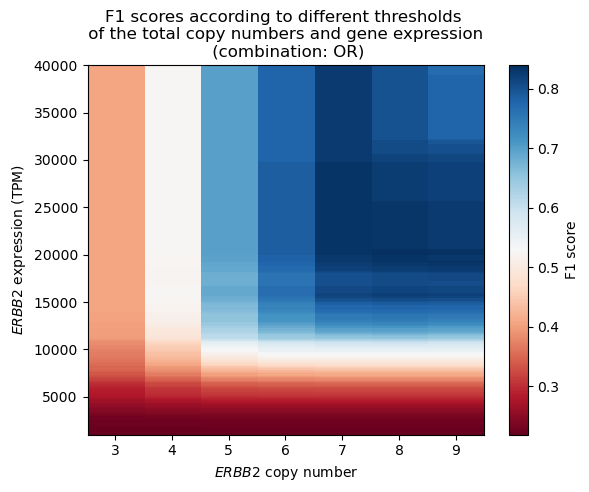

In [38]:
heatmap('f1', df, 'Total_CN', 'ERBB2 exp', 'HER2 Final Status', '$ERBB2$ copy number', '$ERBB2$ expression (TPM)', 2.02, 9, 1000, 40000, 
           title='F1 scores according to different thresholds \n of the total copy numbers and gene expression \n (combination: OR)')

In [ ]:
np.arange(len(range(2, 9)))+2+0.5

In [39]:
df = open_df(processed + 'abs_ihc_for_analysis.csv', sep = ',')
df = ihc_converter(df, 'HER2 Final Status', 'Positive', 'Negative')
print(get_f1_score(df, 'Modal_Total_CN', 'ERBB2 exp', 'HER2 Final Status', 7, 21000))

0.8344370860927153


100%|██████████| 300/300 [03:14<00:00,  1.54it/s]


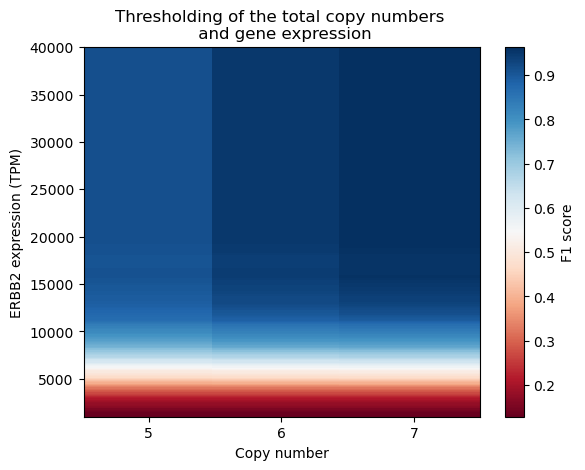

In [40]:
processed = 'C:\\Users\\User\\Desktop\\Big_files\\DATA\\processed_files\\'
df = open_df(processed + 'abs_ihc_for_analysis.csv', sep = ',')
heatmap('acc', df, 'Modal_Total_CN', 'ERBB2 exp', 'HER2 Final Status', 'Copy number', 'ERBB2 expression (TPM)', 4.01, 7, 1000, 40000, 
           title='Thresholding of the total copy numbers \n and gene expression')

In [41]:
df = open_df(processed + 'abs_ihc_for_analysis.csv', sep = ',')
#df['Modal_Total_CN'] = df['Modal_HSCN_1'].map(lambda x: x) + df['Modal_HSCN_2'].map(lambda x: x)

df = ihc_converter(df, 'HER2 Final Status', 'Positive', 'Negative')
print(get_acc_score(df, 'Modal_Total_CN', 'ERBB2 exp', 'HER2 Final Status', 7, 21000))

0.9636098981077147


2.0     295
3.0     104
1.0      98
4.0      85
9.0      26
8.0      25
5.0      22
6.0      18
7.0       6
10.0      4
11.0      2
14.0      1
12.0      1
Name: Total_CN, dtype: int64


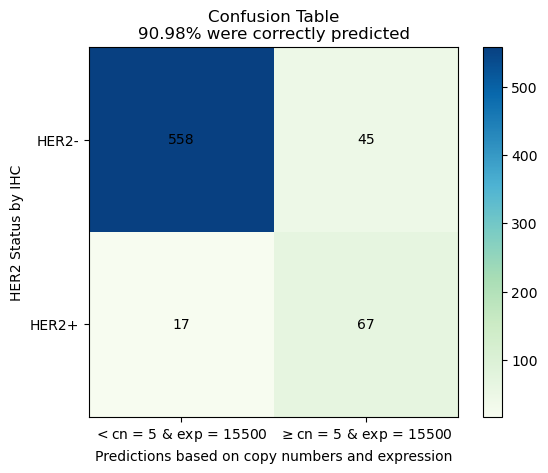

In [42]:
# make a confusion table with the double binary thresholds

# function

def confusion_plot(tn, fp, fn, tp, thr, x, y, x_label_true_neg, x_label_true_pos):
    '''
    Makes a plot with the binary confusion data
    
    :param tn:
    :param fp:
    :param fn:
    :param tp:
    :param thr: threshold used for correct annotation
    :param x: annotation of x-axis (predicted values)
    :param y: annotation of y-axis (true values)
    '''
    true_predictions_perc = round(100* (tp + tn)/(tn + fp + fn + tp), 2)  # used for putting in the title
    data = np.array([[tn, fp], [fn, tp]])  # array for plotting a heatmap 
    fig, ax = plt.subplots()  # creates an empty canvas
    heatmap = ax.imshow(data, cmap='GnBu')  # makes the heatmap with the array and the specified colors 
    for (i, j), val in np.ndenumerate(data):  # goes throught the array and takes the values
        ax.text(j, i, val, ha="center", va="center", color="black")  # print the values in the specific cases
    cbar = fig.colorbar(heatmap)  # adds a colorbar for the heatmap
    ax.set_xticks([0, 1])  # sets a tick
    false = r'$<$'+str(thr)  # math mode + choosen threshold
    true = r'$\geq$'+str(thr)
    ax.set_xticklabels([false, true])
    ax.set_yticks([0, 1])
    ax.set_yticklabels([x_label_true_neg, x_label_true_pos])  # true labels
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_title(f'Confusion Table\n{true_predictions_perc}% were correctly predicted')
    plt.show()

# analysis of the total cn not divided by gd
df = open_df(processed + 'abs_ihc_for_analysis.csv', sep = ',')
df['Total_CN'] = df['Modal_HSCN_1'].map(lambda x: x) + abs_ihc['Modal_HSCN_2'].map(lambda x: x)
print(df['Total_CN'].value_counts(dropna=False))

# setting the thresholds
threshold_cn = 5
threshold_exp = 15500

# tranforming the copy number to binary and the expression data to binary
df['Total_CN'] = np.where(df['Total_CN'] >= threshold_cn, 1, 0) 
df['ERBB2 exp'] = np.where(df['ERBB2 exp'] >= threshold_exp, 1, 0)

# combining the two binary values
df['combination'] = df.apply(lambda x: combinator(x['Total_CN'], x['ERBB2 exp']), axis=1)

# transforming the status by IHC
df = ihc_converter(df, 'HER2 Final Status', 'Positive', 'Negative')

# calculating confusion matrix
tn, fp, fn, tp = confusion(df, 'HER2 Final Status', 'combination')

# making a plot
confusion_plot(tn, fp, fn, tp, f'cn = {threshold_cn} & exp = {threshold_exp}', 
               'Predictions based on copy numbers and expression', 'HER2 Status by IHC', 'HER2-', 'HER2+')

## 7.2 Logistic regression data integration <a class="anchor" id="7.2"></a> [↑](#Content)

In [152]:
# imports

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from tqdm import tqdm

import statistics as stat

from collections import Counter

# functions

def col_to_array(full_df, val1, val2=None, val3=None, mask=None):
    '''
    Returns an array with val1, val2 (optional) and val3 (optional)
    after applying a selection (mask)
    
    :param df: 
    :param val1: column to select
    :param val2: column to select (optional)
    :param mask: mask to subset df (optional)
    :return: np.array with the values
    '''
    if not (mask is None):
        df = full_df[mask]
        df = df.copy()
    else:
        df = full_df
    if val3 != None:
        return df[[val1, val2, val3]].to_numpy()
    elif val2 != None:
        return df[[val1, val2]].to_numpy()
    else:
        return df[[val1]].to_numpy()

def data_split(X, y):
    ''' 
    Splits the data in train and test set
    
    Test size can be changed, 0.2 means that 20% is used for testing
    setting random_state results in constant results
    
    :param X: matrix for the x values
    :param y: true labels (list)
    :return: X_train, X_test, y_train, y_test
    '''
    sss = StratifiedShuffleSplit(test_size = 0.4, random_state = None, n_splits = 10)

    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    return X_train, X_test, y_train, y_test

def choose_function(fun_dict, name, *args, **kwargs):
    '''
    Based on the dictionnary and the name provided,
    a values will be returned
    
    :param fun_dict: dict containing the function description (key) and function (value)
    :param name: function to choose
    :return: function
    '''
    function = fun_dict[name]
    return function(*args, **kwargs)

def logistic_train_predict(X, y, test_set):
    '''
    uses the input for training and then predicts the values for the test set
    
    :param X: matrix of values for training
    :param y: true labels for training set
    :param test_set: test set (same structure as X) which will be used for the predictions
    :return: list of prediction based on the test_set
    '''
    model = LogisticRegression(random_state=None, max_iter=1000).fit(X, y)
    # print(f'n iterations = {model.n_iter_}')  # prints the number of used iteration until convergence
    
    import math
    params = model.intercept_
    coefficient_a = model.coef_[0,0]
    #coefficient_b = model.coef_[0,1]
    intercept = model.intercept_
    
    # print(coefficient_a, coefficient_b, intercept)
    thrs = [7,8]
    return model.predict(test_set), thrs

def random_forest_train_predict(X, y, test_set):
    '''
    uses the input for training and then predicts the values for the test set
    
    :param X: matrix of values for training
    :param y: true labels for training set
    :param test_set: test set (same structure as X) which will be used for the predictions
    :return: list of prediction based on the test_set
    '''
    model = RandomForestClassifier(random_state=None).fit(X, y)
    imp = model.feature_importances_
    thrs = [9,9,9]
    return model.predict(test_set), imp

def thresholding_train_predict(X_1, y, test_set):
    #X = ihc_converter(X, 'Final HER2 Status', 'Positive', 'Negative')
    thresholds = list(range(10000,45000, 100))
    f1_scores = []
    thrs = []
    for thr in thresholds:
        X = X_1.copy()
        #print(X[:20])
        
        #X[X < thr] = 0
        #X[X >= thr] = 1
        #print(X[:20])
        X = np.where(X >= thr, 1, 0)
        #if thr == 6:
        #    print(X)
            
        truth = y
        predictions = X
        f1 = f1_score(truth, predictions)
        f1_scores.append(f1)
    index = max(enumerate(f1_scores),key=lambda x: x[1])[0]
    best_thr = thresholds[index]
    #print(best_thr, f1_scores[index])
    if best_thr != 7:
        thrs.append(best_thr)
    predictions = np.where(test_set >= best_thr, 1, 0)
    return predictions, thrs
    
    
    
    
    

    
    

def confusion_table(truth, prediction):
    '''
    Calculates the confusion table from 2 lists
    
    :param truth: list 
    :param prediction: list
    :return: tn, fp, fn, tp
    '''
    return metrics.confusion_matrix(truth, prediction, normalize=None).ravel()

def confusion_plot(tn, fp, fn, tp, x, y, x_label_true_neg, x_label_true_pos):
    '''
    Makes a plot with the binary confusion data
    
    :param tn:
    :param fp:
    :param fn:
    :param tp:
    :param x: annotation of x-axis (predicted values)
    :param y: annotation of y-axis (true values)
    :param x_label_true_neg: negative label (here applied to truth & predicted)
    :param x_label_true_pos: positive label
    :return: Show graph
    '''
    true_predictions_perc = round(100* (tp + tn)/(tn + fp + fn + tp), 1)
    data = np.array([[tn, fp], [fn, tp]]) 
    fig, ax = plt.subplots() 
    heatmap = ax.imshow(data, cmap='GnBu')  
    for (i, j), val in np.ndenumerate(data):  
        ax.text(j, i, val, ha="center", va="center", color="black")  
    cbar = fig.colorbar(heatmap) 
    ax.set_xticks([0, 1])
    false = x_label_true_neg
    true = x_label_true_pos
    ax.set_xticklabels([false, true])
    ax.set_yticks([0, 1])
    ax.set_yticklabels([x_label_true_neg, x_label_true_pos])  # true labels
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_title(f'Confusion Table\n{true_predictions_perc}% were correctly predicted')
    plt.show()
    
def get_metrics(y_true, y_pred):
    '''
    Calculates accuarcy, precision, recall and F1 score from two lists 
    
    
    :param truth:
    :param prediction:
    :return: accuracy, precision, recall, F1
    '''
    accuracy = accuracy_score(y_true, y_pred, normalize=True) 
    precision = precision_score(y_true, y_pred, average='binary', 
                                zero_division = 0)  #, pos_label = 'Positive')  # there are zero division, which will result in 0
    recall = recall_score(y_true, y_pred, average='binary')  #, 
                          #pos_label = 'Positive')  # will result in a float, because avergae is not None (also for other set to binary)
    f1 = f1_score(y_true, y_pred, average='binary')  #, pos_label = 'Positive')
    return accuracy, precision, recall, f1

def iterate_workflow(X, y, model_type, n_iterations, print_table=False, print_boxplot=True, title='Title'):
    '''
    Does n iteration of data splitting, training, predictions 
    with the option to plot confusion tables
    or plots accuracy, precision, recall and F1 as boxplots
    :param X:
    :param y:
    :param model_type:
    :param n_iterations:
    :param print_table:
    :param print_boxplot:
    :return:
    '''
    function_dict = {'logistic':logistic_train_predict,
                     'forest':random_forest_train_predict,
                     'thresholding':thresholding_train_predict}
    a_s = []  # lists of scores, accuracy
    p_s = list()  # precision
    r_s = list()  # recall
    f_s = list()  # F1
    thrss = []
    for n in tqdm(range(n_iterations)):
        X_train, X_test, y_train, y_test = data_split(X, y)
        predictions, thrs = choose_function(function_dict, model_type, X_train, y_train, X_test)
        
        thrss.append(thrs)
        if print_table == True:
            tn, fp, fn, tp = confusion_table(y_test, predictions)
            confusion_plot(tn, fp, fn, tp, f'Predictions with {model_type}', 'Status by IHC', 'HER2-', 'HER2+')
        if print_boxplot == True:
            
            a_val, p_val, r_val, f_val = get_metrics(y_test, predictions)
            a_s.append(a_val)
            p_s.append(p_val)
            r_s.append(r_val)
            f_s.append(f_val)
            
    if print_boxplot == True:
        fig, axes = plt.subplots(figsize = (5,8), nrows=1, ncols = 1)
        axes = np.atleast_1d(axes)
        data = pd.DataFrame({'Accuracy':a_s, 'Precision':p_s, 'Recall':r_s, 'F1-score':f_s})
        sns.boxplot(data=data, y = 'Accuracy', showmeans=True, ax=axes[0])
        #sns.boxplot(data=data, y = 'Precision', palette = 'pastel', showmeans=True, ax=axes[1])
        #sns.boxplot(data=data, y = 'Recall', palette = 'pastel', showmeans = True, ax=axes[2])
        #sns.boxplot(data=data, y = 'F1-score', palette = 'pastel', showmeans = True, ax=axes[3])
        axes[0].set_ylim(0.8,1)
        #axes[1].set_ylim(0,1)
        #axes[2].set_ylim(0,1)
        #axes[3].set_ylim(0,1)
        fig.suptitle(f'{title} \n Mean accuracy is {round(data["Accuracy"].mean(), 4)}.')
        plt.show()
        
    return thrss

In [128]:
df.columns

Index(['cancer type', 'patient_barcode', 'sample vial', 'sample', 'ERBB2 exp',
       'ERBB2 exp percentile', 'purity', 'ploidy', 'Genome doublings',
       'Coverage for 80% power', 'Cancer DNA fraction',
       'Subclonal genome fraction', 'seg_start', 'seg_end', 'Num_Probes',
       'Length', 'Modal_HSCN_1', 'Modal_HSCN_2', 'Modal_Total_CN',
       'Subclonal_HSCN_a1', 'Subclonal_HSCN_a2', 'Cancer_cell_frac_a1',
       'Ccf_ci95_low_a1', 'Ccf_ci95_high_a1', 'Cancer_cell_frac_a2',
       'Ccf_ci95_low_a2', 'Ccf_ci95_high_a2', 'LOH', 'Homozygous_deletion',
       'rel_seg_size', 'Complete TCGA ID', 'Gender',
       'Age at Initial Pathologic Diagnosis', 'ER Status', 'PR Status',
       'HER2 Final Status', 'Tumor', 'Tumor--T1 Coded', 'Node', 'Node-Coded',
       'Metastasis', 'Metastasis-Coded', 'AJCC Stage', 'Converted Stage',
       'Survival Data Form', 'Vital Status', 'Days to Date of Last Contact',
       'Days to date of Death', 'OS event', 'OS Time', 'PAM50 mRNA',
       'SigCl

100%|██████████| 1000/1000 [07:50<00:00,  2.12it/s]


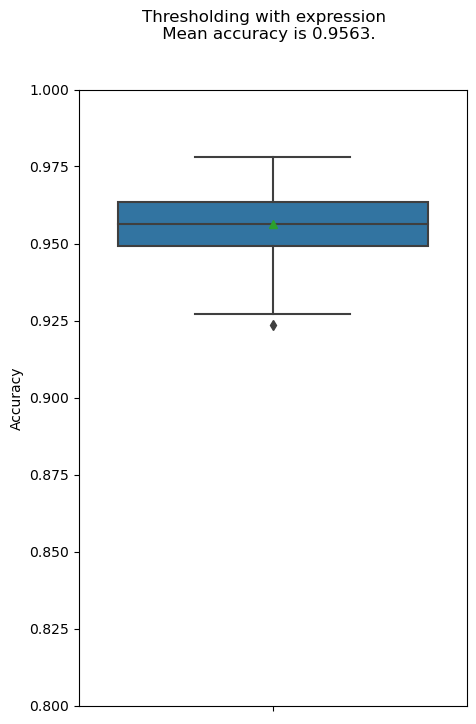

Counter({19200: 432, 15700: 157, 18900: 146, 20100: 85, 15500: 62, 18300: 54, 15400: 29, 18200: 19, 15200: 10, 18000: 2, 15000: 1, 14700: 1, 14900: 1, 14400: 1})


100%|██████████| 1000/1000 [00:12<00:00, 82.39it/s]


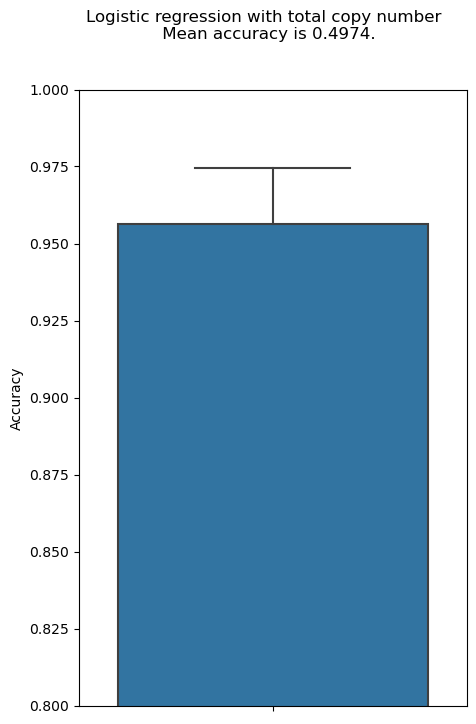

Counter({7: 1000, 8: 1000})


100%|██████████| 1000/1000 [03:51<00:00,  4.33it/s]


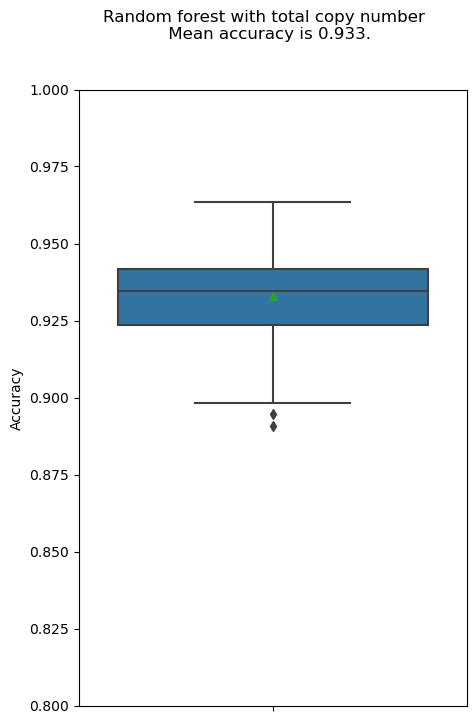

Counter({9: 3000})


In [127]:
df = open_df(processed + 'abs_ihc_for_analysis.csv', sep = ',')
df = ihc_converter(df, 'HER2 Final Status', 'Positive', 'Negative') 
# get arrays
X_total = col_to_array(df, 'ERBB2 exp')

y_total = col_to_array(df, 'HER2 Final Status').ravel()

# iterate a full workflow of data splitting, logistic regression, predictions, assessment and score tracking
#iterate_workflow(X_total, y_total, 'thresholding', n_iterations=1000, print_table=False, print_boxplot=True, 
#                 title='Thresholding with expression')
iterate_workflow(X_total, y_total, 'logistic', n_iterations=1000, print_table=False, print_boxplot=True, 
                 title='Logistic regression with total copy number')
iterate_workflow(X_total, y_total, 'forest', n_iterations=1000, print_table=False, print_boxplot=True, 
                 title='Random forest with total copy number')

In [ ]:
import numpy as np

# Create an example array
arr = np.random.randint(0, 20, size=(12, 1))  # Random array with shape (412, 1)
print("Original array:")
print(arr)

# Set the threshold values
threshold_high = 10
threshold_low = 0

# Apply the thresholds and update the array
arr[arr > threshold_high] = 1
arr[arr < threshold_low] = 0

# Print the modified array
print("Modified array:")
print(arr)


In [ ]:
# logistic regression for total copy number and gene expression together 

df = open_df(processed + 'abs_ihc_for_analysis.csv', sep = ',')

# get arrays
X_total = col_to_array(df, 'Modal_Total_CN', 'ERBB2 exp')

y_total = col_to_array(df, 'HER2 Final Status').ravel()

# iterate a full workflow of data splitting, logistic regression, predictions, assessment and score tracking
iterate_workflow(X_total, y_total, 'logistic', n_iterations=10, print_table=False, print_boxplot=True, 
                 title='Logistic regression with copy number and gene expression')

import math
# p = 1 / (1 + math.exp(-(X * coefficient_a + y * coefficient_b + intercept)))



100%|██████████| 100/100 [00:05<00:00, 17.76it/s]


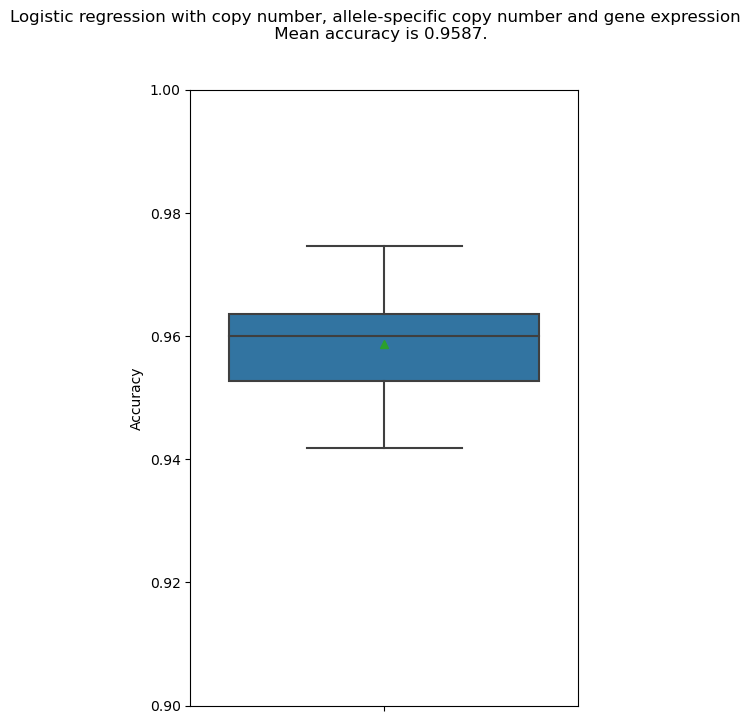

In [45]:
# logistic regression for total copy number, as cn and gene expression together 

df = open_df(processed + 'abs_ihc_for_analysis.csv', sep = ',')

# get arrays
X_total = df[['Modal_Total_CN', 'ERBB2 exp', 'Modal_HSCN_1', 'Modal_HSCN_2']].to_numpy()
y_total = col_to_array(df, 'HER2 Final Status').ravel()

# iterate a full workflow of data splitting, logistic regression, predictions, assessment and score tracking
iterate_workflow(X_total, y_total, 'logistic', n_iterations=100, print_table=False, print_boxplot=True, 
                 title='Logistic regression with copy number, allele-specific copy number and gene expression')

import math
# p = 1 / (1 + math.exp(-(X * coefficient_a + y * coefficient_b + intercept)))



In [ ]:
print(1/(1+math.exp(-(6* 0.64290198837998 + 30000* 7.137955396461078e-05 + -5.6255595))))


100%|██████████| 10/10 [00:02<00:00,  3.69it/s]


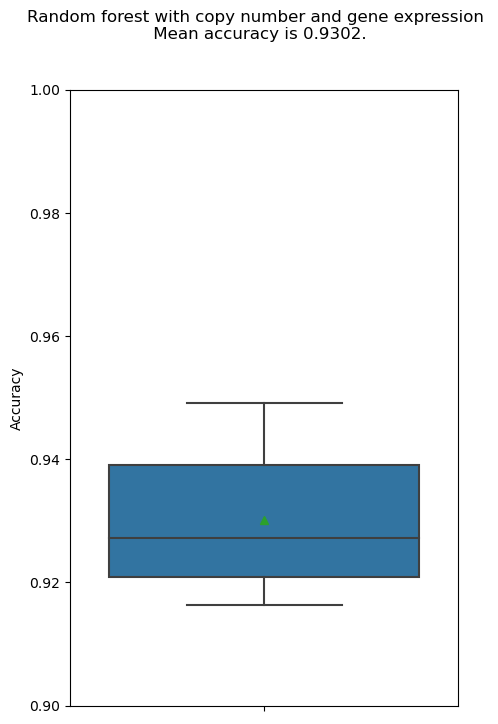

In [46]:
# random forest for cn + gene expression

df = open_df(processed + 'abs_ihc_for_analysis.csv', sep = ',')

# get arrays
X_total = col_to_array(df, 'Modal_Total_CN', 'ERBB2 exp')
y_total = col_to_array(df, 'HER2 Final Status').ravel()

# iterate a full workflow of data splitting, logistic regression, predictions, assessment and score tracking
iterate_workflow(X_total, y_total, 'forest', n_iterations=10, print_table=False, print_boxplot=True, 
                 title='Random forest with copy number and gene expression')

100%|██████████| 100/100 [00:29<00:00,  3.42it/s]


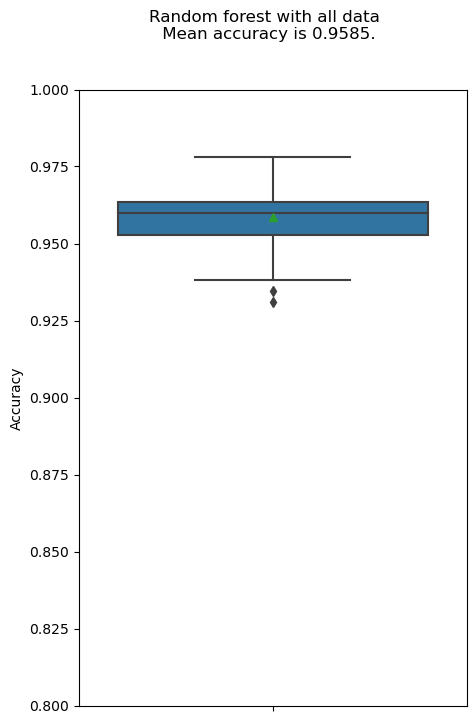

In [165]:
# random forest for all data together

df = open_df(processed + 'abs_ihc_for_analysis.csv', sep = ',')
df = ihc_converter(df, 'HER2 Final Status', 'Positive', 'Negative') 
# get arrays
X_total = df[['Modal_HSCN_1', 'Modal_HSCN_2']].to_numpy()
y_total = col_to_array(df, 'HER2 Final Status').ravel()

# iterate a full workflow of data splitting, logistic regression, predictions, assessment and score tracking
imps = iterate_workflow(X_total, y_total, 'forest', n_iterations=100, print_table=False, print_boxplot=True, 
                        title='Random forest with all data')

In [166]:
cn = np.mean([arr[0] for arr in imps])
cn_1 = np.mean([arr[1] for arr in imps])
#cn_2 = np.mean([arr[2] for arr in imps])
#exp = np.mean([arr[3] for arr in imps])
print(f'the mean for total cn is {round(cn,4)}, for minor cn it is {round(cn_1,4)} and for major cn it is {round(cn_2,4)} and for the exp it is {round(exp, 4)}')

the mean for total cn is 0.152, for minor cn it is 0.848 and for major cn it is 0.4362 and for the exp it is 0.5389


In [139]:
def iterate_workflow(X, y, n_iterations=100, title='Title'):
    '''
    Does n iteration of data splitting, training, predictions 
    with the option to plot confusion tables
    or plots accuracy, precision, recall and F1 as boxplots
    :param X:
    :param y:
    :param n_iterations:
    :return:
    '''
    function_dict = {'logistic':logistic_train_predict, 'forest':random_forest_train_predict}
    a_s_lr = [] 
    f_s_lr = []
    a_s_rf = []
    f_s_rf = []
    for n in tqdm(range(n_iterations)):
        X_train, X_test, y_train, y_test = data_split(X, y)
        predictions = choose_function(function_dict, 'logistic', X_train, y_train, X_test)
        a_val, p_val, r_val, f_val = get_metrics(y_test, predictions)
        a_s_lr.append(a_val)
        f_s_lr.append(f_val)
    for n in tqdm(range(n_iterations)):
        X_train, X_test, y_train, y_test = data_split(X, y)
        predictions = choose_function(function_dict, 'forest', X_train, y_train, X_test)
        a_val, p_val, r_val, f_val = get_metrics(y_test, predictions)
        a_s_rf.append(a_val)
        f_s_rf.append(f_val)
    
    data = pd.DataFrame({'Accuracy_lr':a_s_lr, 'F1-score_lr':f_s_lr, 'Accuracy_rf':a_s_rf, 'F1-score_rf':f_s_rf})
    
    data['Accuracy_lr'] = data['Accuracy_lr']*100
    data['Accuracy_rf'] = data['Accuracy_rf']*100
    
    mean_a_lr = data['Accuracy_lr'].mean()
    mean_f_lr = data['F1-score_lr'].mean()
    mean_a_rf = data['Accuracy_rf'].mean()
    mean_f_rf = data['F1-score_rf'].mean()
    
    fig, axes = plt.subplots(figsize = (12,5), nrows=1, ncols = 4)
    fig.subplots_adjust(wspace=0.5)
    
    sns.boxplot(data=data, y = 'Accuracy_lr', showmeans=True, ax=axes[0], color='red', 
                meanprops={"markerfacecolor":"green", "markeredgecolor":"black"})
    sns.boxplot(data=data, y = 'F1-score_lr', showmeans=True, ax=axes[1], color='green', 
               meanprops={"markerfacecolor":"red", "markeredgecolor":"black"})
    sns.boxplot(data=data, y = 'Accuracy_rf', showmeans=True, ax=axes[2], color='red', 
               meanprops={"markerfacecolor":"green", "markeredgecolor":"black"})
    sns.boxplot(data=data, y = 'F1-score_rf', showmeans=True, ax=axes[3], color='green', 
               meanprops={"markerfacecolor":"red", "markeredgecolor":"black"})
    
    axes[0].set_ylim(80,100)
    axes[1].set_ylim(0.2,1)
    axes[2].set_ylim(80,100)
    axes[3].set_ylim(0.2,1)
    
    axes[0].set_ylabel('Accuracy (%)')
    axes[1].set_ylabel('F1 score')
    axes[2].set_ylabel('Accuracy (%)')
    axes[3].set_ylabel('F1 score')
    
    
    axes[0].text(1.28, 1.1, 'Logistic regression', horizontalalignment='center', verticalalignment='center', 
                 transform=axes[0].transAxes, fontsize=12)
    axes[2].text(4.25, 1.1, 'Random forest', horizontalalignment='center', verticalalignment='center', 
                 transform=axes[0].transAxes, fontsize=12)
    
    axes[0].set_title(f'x\u0304 = {round(mean_a_lr, 2)}%', fontsize=10)
    axes[1].set_title(f'x\u0304 = {round(mean_f_lr, 2)}', fontsize=10)
    axes[2].set_title(f'x\u0304 = {round(mean_a_rf, 2)}%', fontsize=10)
    axes[3].set_title(f'x\u0304 = {round(mean_f_rf, 2)}', fontsize=10)
    
    fig.suptitle(title, y=1.05)
    fig.savefig(pictures+'boxplots.png', dpi=500, bbox_inches='tight')
    plt.show()



100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


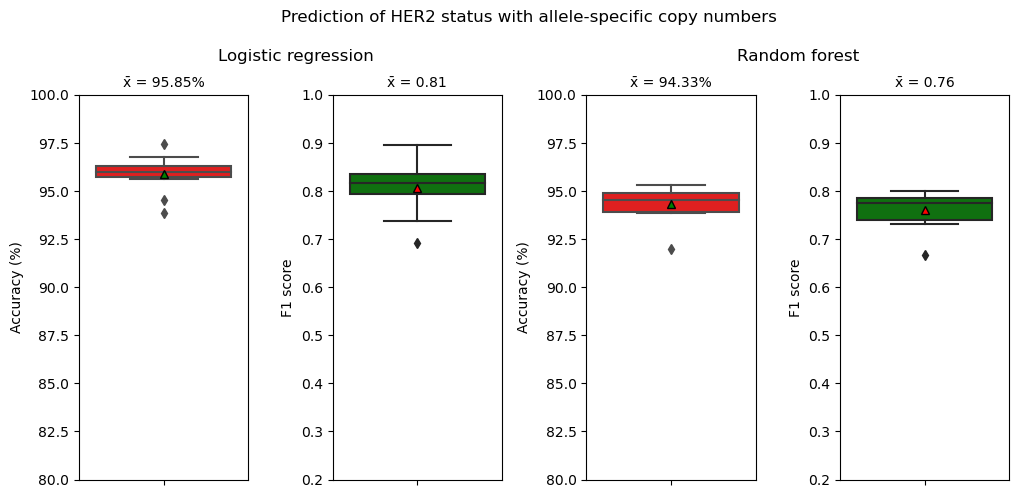

In [50]:
# make a boxplot with logistic regression and random forest

df = open_df(processed + 'abs_ihc_for_analysis.csv', sep = ',')
df['Total_CN'] = df['Modal_HSCN_1'].map(lambda x: x) + df['Modal_HSCN_2'].map(lambda x: x)

# get arrays
X_total = X_total = df[['Modal_Total_CN', 'ERBB2 exp', 'Modal_HSCN_1', 'Modal_HSCN_2']].to_numpy()
y_total = col_to_array(abs_ihc, 'HER2 Final Status').ravel()

# iterate a full workflow of data splitting, logistic regression, predictions, assessment and score tracking
iterate_workflow(X_total, y_total, n_iterations=10,  
                 title='Prediction of HER2 status with allele-specific copy numbers')

## 7.3 PCA and subsequent visualizations <a class="anchor" id="7.3"></a> [↑](#Content)

While presenting these findings and data, it would be nice to show the data in the same way throughout the whole presentation. One idea was to plot the samples with PCA1 and PCA2 and color them accordingly depending on what was presented at the moment.

For this, we need to scale the data, as copy number are very different than gene expression values. 

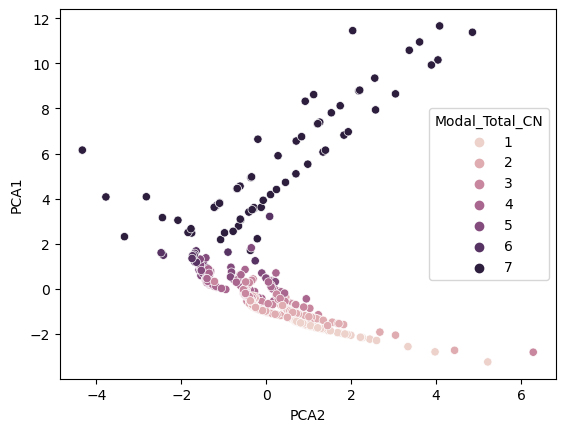

In [51]:
# imports
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# functions

# data 
df = open_df(processed + 'abs_ihc_for_analysis.csv', sep = ',')
# df = ihc_converter(df, 'HER2 Final Status', 'Positive', 'Negative')

# make additional column for the CN total based on the allele-specific CN
df['Total_CN'] = df['Modal_HSCN_1'].map(lambda x: x) + df['Modal_HSCN_2'].map(lambda x: x)

# subset data for PCA
#df['ERBB2 exp'] = df['ERBB2 exp'].transform('log')
#df['ERBB2 percentile'] = df['HER2'].transform('log')
#columns = ['Modal_HSCN_1', 'Modal_HSCN_2', 'ERBB2 exp', 'Modal_Total_CN', 'HER2']
columns = ['Modal_HSCN_1', 'Modal_HSCN_2', 'ERBB2 exp', 'ERBB2 exp', 'ERBB2 exp percentile', 'Modal_Total_CN', 'ERBB2 exp']
# columns = ['ERBB2 exp', 'ERBB2 exp percentile']
X = df.loc[:,columns]

# initiate PCA object
pca = PCA(n_components=2)

# normalize data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# perfomr PCA
X_pca = pca.fit_transform(X_normalized)

# get PCA1 and PCA2 on the df
df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]

# plot PCA

df = df.sort_values('HER2 Final Status')
#sns.scatterplot(data = df, x = 'PCA2', y = 'PCA1',  hue = 'HER2 Final Status')
sns.scatterplot(data = df, x = 'PCA2', y = 'PCA1', hue = 'Modal_Total_CN')
plt.xlabel('PCA2')
plt.ylabel('PCA1')
plt.show()



In [52]:
df = open_df(processed + 'abs_ihc_for_analysis.csv', sep = ',')
df['HER2 Final Status'].value_counts()

Negative    603
Positive     84
Name: HER2 Final Status, dtype: int64

687


C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_18764\2313423464.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator


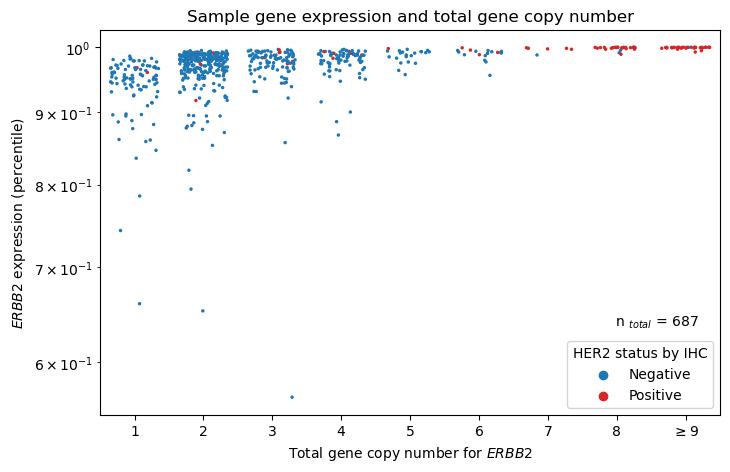

2.0     295
3.0     104
1.0      98
4.0      85
9.0      26
8.0      25
5.0      22
6.0      18
7.0       6
10.0      4
11.0      2
14.0      1
12.0      1
Name: Total_CN, dtype: int64

In [53]:
# plot all sample with gene expression and total copy numbers

np.random.seed(12)


df = open_df(processed + 'abs_ihc_for_analysis.csv', sep = ',')
df['Total_CN'] = df['Modal_HSCN_1'].map(lambda x: x) + df['Modal_HSCN_2'].map(lambda x: x)
df = df.rename(columns={'HER2 Final Status':'HER2 status by IHC'})

d = {1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 8:8, 9:9, 10:9, 11:9, 12:9, 13:9, 14:9}

df['Total_CN_plot'] = df['Total_CN'].apply(lambda x:d.get(x))


fig, ax = plt.subplots(figsize=(8,5))

ax = sns.stripplot(data = df, y = 'ERBB2 exp percentile', x = 'Total_CN_plot', hue = 'HER2 status by IHC', 
                   size = 2.5, palette = ['tab:blue', 'tab:red'], jitter=0.35)



ax.set_yscale('log')
#ax.set_ylim(0.98,1.001)
plt.ylabel('$ERBB2$ expression (percentile)')
plt.xlabel('Total gene copy number for $ERBB2$')
print(len(df['ERBB2 exp']))
num_points_plotted = len(ax.collections)
total_points = len(df['ERBB2 exp'].to_list())
ax.set_title('Sample gene expression and total gene copy number')
ax.legend(loc='lower right', title='HER2 status by IHC')
ax.text(0.83, 0.23, 'n $_{total}$ = '+ str(total_points), transform=ax.transAxes, ha='left', fontsize=10)
ax.set_xticklabels(('1', '2', '3', '4', '5', '6', '7', '8', '$\geq$9'))  # this is usually not done, since the data could move
#plt.axhline(y=19200, color='0.6', linestyle='--')
#plt.axvline(x=5.5, color='0.6', linestyle='--')
fig.patch.set_facecolor('none')
ax.patch.set_facecolor('none')
#fig.savefig(pictures+'overview_percentile.png', dpi=500, bbox_inches='tight', transparent =True, facecolor=None)
plt.show()

df['Total_CN'].value_counts()

In [56]:
fig, ax = plt.subplots(figsize= (4,4))  # creates an empty canvas
    heatmap = ax.imshow(data, cmap='GnBu')  # makes the heatmap with the array and the specified colors 
    for (i, j), val in np.ndenumerate(data):  # goes throught the array and takes the values
        ax.text(j, i, val, ha="center", va="center", color="black")  # print the values in the specific cases
    cbar = fig.colorbar(heatmap)  # adds a colorbar for the heatmap
    cbar.ax.yaxis.label.set_fontfamily('sans-serif')
    ax.set_xticks([0, 1])  # sets a tick
    false = r'$<$'+str(thr)  # math mode + choosen threshold
    true = r'$\geq$'+str(thr)
    ax.set_xticklabels([false, true])
    ax.set_yticks([0, 1])
    ax.set_yticklabels([x_label_true_neg, x_label_true_pos])  # true labels
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_title(f'Correlation of the total gene copy number \n with the status by IHC \n', fontsize=10, loc='center')  #, pad=20)
    ax.text(0.5, 1.03, f'Accuracy = {true_predictions_perc}%, Threshold = {thr}', transform=ax.transAxes, fontsize=8, ha='center')
    fig.savefig(pictures+'confusion_plot_CN.png', dpi=500, bbox_inches='tight')
    plt.show()

IndentationError: unexpected indent (1702633741.py, line 2)

In [ ]:
df['HER2'].value_counts()

# 8 BRCA comparison TCGA new vs TCGA ABSOLUTE <a class="anchor" id="8"></a> [↑](#Content)

We have total and allele-specific copy-numbers from the TCGA, which are based on SNP arrays and processed using ASCAT. On the other hand, we have all that data as well from ABSOLUTE from a publication ([Hoadley *et al.*](https://www.cell.com/cell/fulltext/S0092-8674(18)30302-7?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0092867418303027%3Fshowall%3Dtrue)). 

The copy numbers are very different, ranging up to 60 for the ASCAT data and being at max 7 with the ABSOLUTE data. 

In [58]:
save = True  

# python version
# 3.9.7

# imports

import os 
import pandas as pd 
import numpy as np

# directory for processed files
processed = 'C:\\Users\\User\\Desktop\\Big_files\\DATA\\processed_files\\'

# functions

def open_df(file, sep = '\t', header = 0):
    '''
    Opens a file as pandas dataframe

    :param file: file path and name including extension 
    :return: pd.DataFrame()
    '''
    try:
        df = pd.read_csv(file, sep=sep, low_memory=False, header = header)
        return df
    except:
        print(f'Error opening {file}')

def swarm_plot(df, x, y, x_label, y_label, hue = None, title='Title'):
    '''
    Make a swarm plot with the gene expression data, separated by HER2 status by IHC
    
    :param df: input df, must be clean and tidy for seaborn (long format)
    :param x: x-axis, thought to be the HER2 status by IHC
    :param y: y-axis, thought to be the gene expression
    :param x_label:
    :param y_label: 
    :param title:
    :return: print the plots
    '''
    fig, ax = plt.subplots(dpi=800)
    
    sns.swarmplot(data = df, x = x, y = y, hue = hue, size = 2)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    fig.suptitle(title)
    plt.show()


C:\Users\User\anaconda3\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 24.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
C:\Users\User\anaconda3\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 24.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
C:\Users\User\anaconda3\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 43.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
C:\Users\User\anaconda3\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 44.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
C:\Users\User\anaconda3\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 43.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
C:\Users\User\anaconda3\lib\site-packages\seaborn\categ

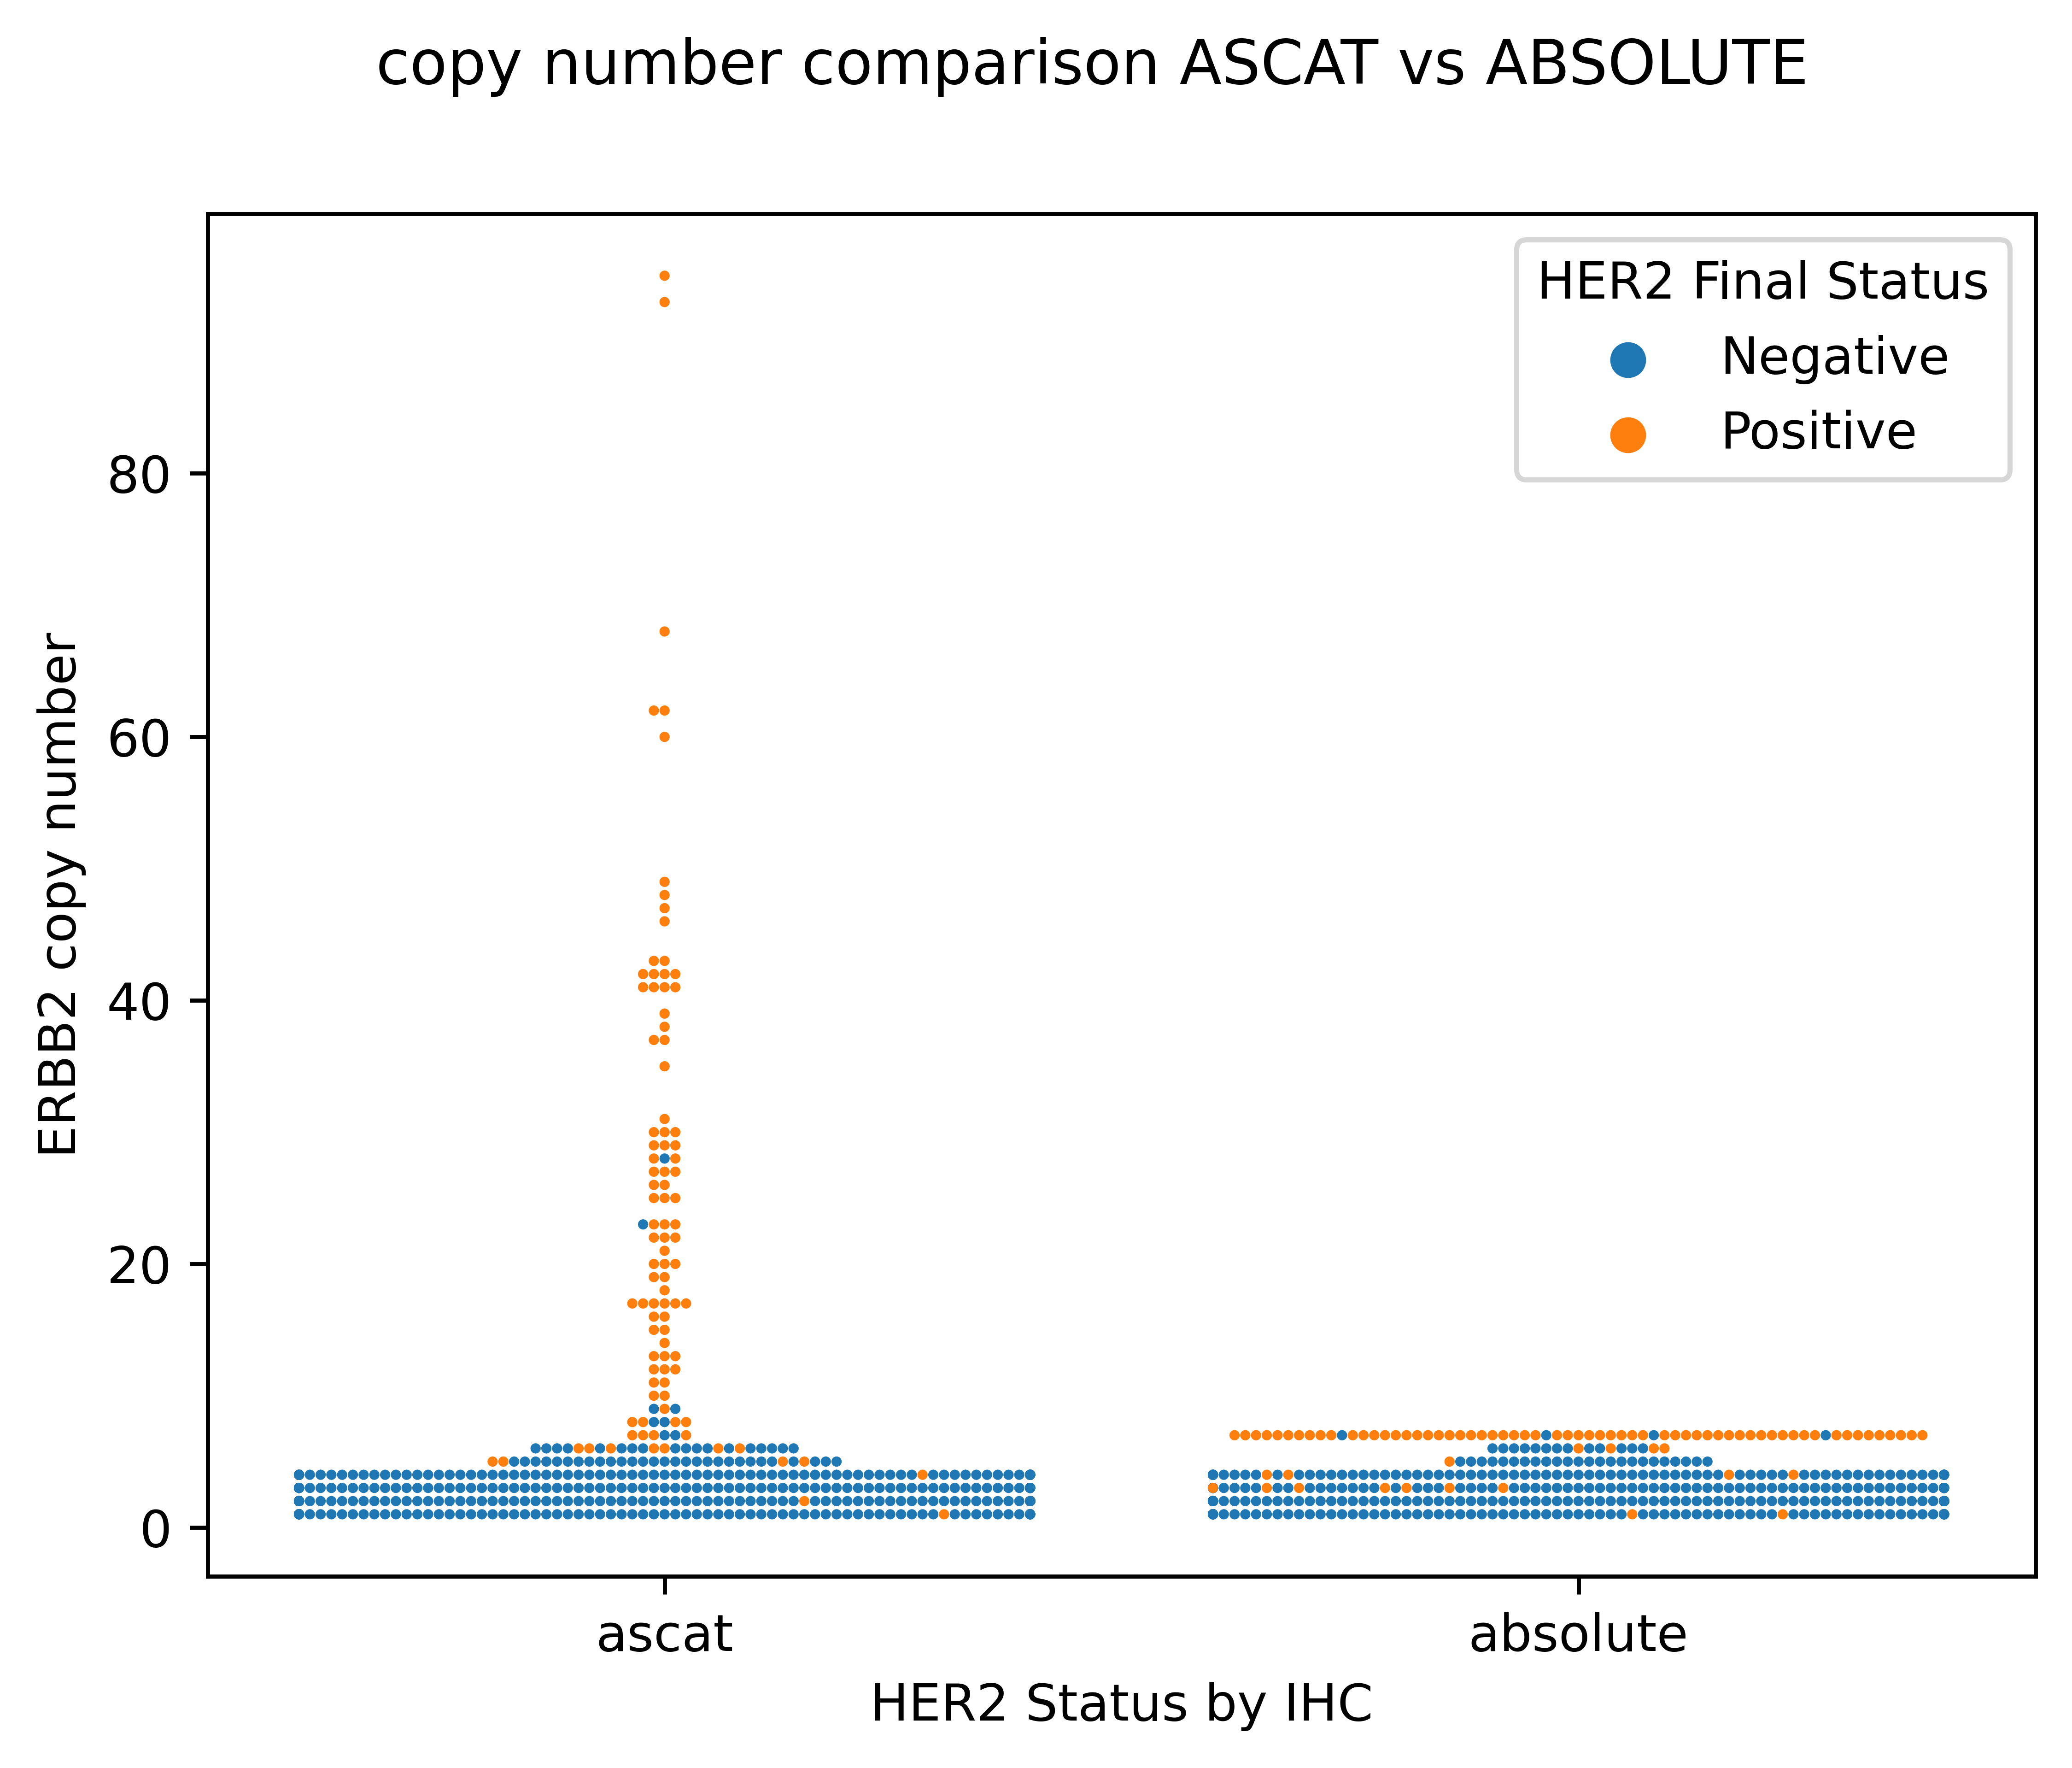

In [59]:
# data for total copy numbers
absolute = open_df(processed + 'abs_ihc_for_analysis.csv', sep = ',').loc[:, ['Modal_Total_CN', 'HER2 Final Status']]
absolute = absolute.rename(columns={'Modal_Total_CN':'copy_number'})
absolute.insert(0, 'data', 'absolute')

ascat = open_df(processed + 'cn_ihc.csv', sep = ',').loc[:, ['HER2 Final Status', 'copy_number']]
ascat.insert(0, 'data', 'ascat')

df = pd.concat([ascat, absolute])

swarm_plot(df, x = 'data', y = 'copy_number', hue = 'HER2 Final Status',
            x_label = 'HER2 Status by IHC', y_label = 'ERBB2 copy number', 
            title='copy number comparison ASCAT vs ABSOLUTE')

# 9 HER2+ esophageal cancer MSK study <a class="anchor" id="9"></a> [↑](#Content)

MSK did a trial with HER2 positive esophageal, gastric or gastro-oesophageal junction cancer, summarized in [this publication](https://synapse.mskcc.org/synapse/works/167378). The data can be downloaded from the [cBioPortal](https://www.cbioportal.org/study/clinicalData?id=egc_trap_msk_2020). 

The file `data_clinical_patient.txt` contains the clinical information, including the HER2 status (which is anyway positive for the vast majority). On the other hand, `data_cna_hg19.seg` contains the segment with the copy numbers. We can extract the copy numbers for HER2 using the function used [above](#2.1). 

According to the `meta_cna.txt`-file, GISTIC was used for calling the copy numbers. For the interpretation, it says: "Putative copy-number from GISTIC 2.0. Values: -2 = homozygous deletion; -1 = hemizygous deletion; 0 = neutral / no change; 1 = gain; 2 = high level amplification."



In [ ]:
save = True  

# python version
# 3.9.7

# imports

import os 
import pandas as pd 
import numpy as np

# paths and files

# cBioPortal downloads

path_patients = 'C:\\Users\\User\\Desktop\\Big_files\\DATA\\TRAP_MSK_2020\\egc_trap_msk_2020\\data_clinical_patient.txt'
path_samples = 'C:\\Users\\User\\Desktop\\Big_files\\DATA\\TRAP_MSK_2020\\egc_trap_msk_2020\\data_clinical_sample.txt'
path_segments = 'C:\\Users\\User\\Desktop\\Big_files\\DATA\\TRAP_MSK_2020\\egc_trap_msk_2020\\data_cna_hg19.seg'
path_cn = 'C:\\Users\\User\\Desktop\\Big_files\\DATA\\TRAP_MSK_2020\\egc_trap_msk_2020\\data_cna.txt'

# directory for processed files
processed = 'C:\\Users\\User\\Desktop\\Big_files\\DATA\\processed_files\\'

# functions  

def open_df(file, sep = '\t', header = 0):
    '''
    Opens a file as pandas dataframe

    :param file: file path and name including extension 
    :return: pd.DataFrame()
    '''
    try:
        df = pd.read_csv(file, sep = sep, low_memory=False, header = header)
        return df
    except:
        print(f'Error opening {file}')

def bubble_plot(df, x, y, x_label, y_label, size, order, title='Title'):
    '''
    Make a bubble plot with the copy numbers data, separated by HER2 status by IHC
    
    :param df: input df, must be clean and tidy for seaborn (long format)
    :param x: x-axis, thought to be the HER2 status by IHC
    :param y: y-axis, thought to be the copy numbers, specify the order 
    :param x_label:
    :param y_label: 
    :param size: columns with counts for size of bubble
    :param order: order of the y-axis as we have cat data
    :param title:
    :return: print the plots
    '''
    fig, ax = plt.subplots()
    df[x] = pd.Categorical(df[x], categories = order, ordered = True)  # this will tell plt the order
    sns.scatterplot(data=df, x=x, y=y, size=size, ax=ax, alpha = 0.5, sizes = (20,2000), legend = False)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    fig.suptitle(title)
    plt.show()
    
def grouper(df, col1, col2, col_sum):
    '''
    Groups rows with identical values for three columns together 
    and indicates how many have been merged by making the sum
    in the column with col_sum
    (the best is to have 1 in all col_sum)
    
    :param df:
    :param col1: group by this column
    :param col2:
    :param col3:
    :param col_sum: values in this col will be summed after merging
    :return: new df
    '''
    functions = {col_sum:'sum'} 
    new_df = df.groupby([col1, col2]).aggregate(functions).reset_index()
    return new_df

In [ ]:
# patients file with the HER2 status by IHC
patients = open_df(path_patients, header = 4)

# samples file 

# segments, not yet sure how to use them
segments = open_df(path_segments)

# copy number from GISTIC, subsetted for ERBB2
cn_gistic = open_df(path_cn)
cn = (
    cn_gistic[cn_gistic['Hugo_Symbol'] == 'ERBB2']
    .drop('Hugo_Symbol', axis=1)
    .T
    .reset_index()
    .rename(columns={'index':'sample_id', 100:'ERBB2_cn'})
)

# ihc from patients
columns = ['BASELINE_INTERNAL_HER2_IHC_FISH', 'PATIENT_ID']
patients = patients.loc[:,columns]

# ihc from samples, reduce column number
columns = ['PATIENT_ID', 'SAMPLE_ID', 'SEQUENCING_TYPE', 'ERBB2_AMP_MSKIMPACT',
       'HER2_IMPACT_FOLD_CHANGE', 'SAMPLE_COVERAGE', 'TUMOR_PURITY',
       'SAMPLE_TYPE', 'TISSUE_SITE',
       'HER2_STATUS', 'IHC_HER2']

samples = open_df(path_samples, header = 4).loc[:,columns]

# merge with copy numbers information
df = pd.merge(cn, samples, how = 'inner', left_on = 'sample_id', right_on = 'SAMPLE_ID')
df = df[df['IHC_HER2'].notna()]

# for plotting, count and merge same copy numbers
df['count'] = 1
df_plot = grouper(df, 'ERBB2_cn', 'IHC_HER2', 'count')

# plot
bubble_plot(df_plot, 
            x = 'IHC_HER2', 
            y = 'ERBB2_cn', 
            x_label = 'HER2 Status by IHC', 
            y_label = 'Copy Number (GISTIC)', 
            size = 'count', 
            order = ['0', '1+', '2+', '3+'], 
            title='Copy numbers and HER2 status from MSK trial \n (mainly esophagus, stomach and liver cancer samples)')


# 10 **IO cohort** data wrangling <a class="anchor" id="10"></a> [↑](#Content)

The IO cohort contains several types of data. 
* For the endpoints, we can look at RECIST and OS in days. After discussing this with Cora, the best would be to take the RECIST data and classify CR (complete response) and PR (partial response) as responders and PD (progressive) as non responders. We would not take SD (stable) into account. 
* We need to subset the data according to treatment type, as the biomarker to look into also differs. 


In [1]:
save = True  

# python version
# 3.9.7

# imports

import os 
import pandas as pd 
import numpy as np

# COSMIC list of cancer-related genes
cosmic_file = 'C:\\Users\\User\\Desktop\\Big_files\\DATA\\COSMIC\\cancer_gene_census.csv'

# directory for processed files
processed = 'C:\\Users\\User\\Desktop\\Big_files\\DATA\\processed_files\\'

# functions  

def open_df(file, sep = '\t', header = 0):
    '''
    Opens a file as pandas dataframe

    :param file: file path and name including extension 
    :return: pd.DataFrame()
    '''
    try:
        df = pd.read_csv(file, sep = sep, low_memory=False, header = header)
        return df
    except:
        print(f'Error opening {file}')

def column_to_list(file_path, column_name):
    '''
    Opens a .csv and puts a specific column in a list
    
    :param file_path: 
    :param column_name: 
    :return: list()
    '''
    df = pd.read_csv(file_path, sep=',', low_memory=False)
    new_list = df[column_name]
    return list(new_list)

def rows_select(df, col, lis):
    ''' 
    Select rows based on a column value being in a list and return new dataframe
    
    :param df: pandas dataframe object from which to select
    :param col: indicates which column of the dataframe should be used to select
    :param lis: list of items that are used to filter
    :return: new dataframe with selection applied
    '''
    df_new = df[df[col].isin(lis)]
    return df_new


def counter(df, col1=None, col2=None):
    '''
    Counts how many rows the df has and what the columns are.
    If a col1 or col2 is specified, return what the values are
    :param df:
    :param col1: 
    :param col2:
    :return: printed statement
    '''
    for i in df:
        j = len(df[i])
        print(f'Column {i} has {j} values')
    if col1 is not None:
        val = df[col1].value_counts()
        print(f'Column {col1} has the following values \n {val}')
    if col2 is not None:
        val = df[col2].value_counts()
        print(f'Column {col2} has the following values \n {val}')
    print('-------------------------------------')
        
def save_csv(df, file_path):
    '''
    saves the df to a .csv file
    if save == True
    
    :param df:
    :param file_path: file name or path (without extension)
    :return: None
    '''
    if save == True:
        df.to_csv(f'{file_path}.csv', header = True, index = False)

**Readme from Brendan: Miao et al 2018 data - absolute copy number and bulk RNA-seq expression**


Absolute copy number and expression data was gathered for 248 and 62 samples of the 249 tumor samples 
characterized in the study. 

- `combat_seq_adjusted_TPM.2018.txt` are transcript per million counts for all genes across 
the 62 samples that had bulk RNA sequencing performed. Processing was performed by using 
[STAR aligner](https://github.com/alexdobin/STAR) to align transcripts to the hg19 
reference genome, [Salmon](https://www.nature.com/articles/nmeth.4197) to perform 
transcript quantification, and then [ComBat](https://academic.oup.com/nargab/article/2/3/lqaa078/5909519) 
to correct transcript counts for batches. 

- `rnaseq_clust_metadata_2018.txt` is a metadata table from Cora. Associated tumor sample 
names from whole-exome sequencing are located under the `case_sample_pretreatment` column, 
though they contain some differences such as a `_1` suffix on many samples. 

- `supplementary-table-2.with_rna.csv` is a manually adjusted version of `supplementary-table-2` 
with an added column of `RNA_sample_id`. Sample names from `combat_seq_adjusted_TPM.2018.txt` 
were manually added to this column in the appropriate row by matching. Most samples directly 
matched the whole-exome sample name after removing the `_1` suffix while a subset needed to 
be compared using substrings within sample names. I also recommend using this file for clinical annotations.

- `supplementary-table-9.with_cgc_genes.txt` contained information on allelic copy number 
calls from ABSOLUTE from supplementary table 9 that have been annotated for genes using the 
[extract_gene_allelic_cn](https://github.com/vanallenlab/terra-methods/tree/main/Miscellaneous/extract_gene_allelic_cn) 
python script using genes appearing in the cancer gene census. 
**You can use the columns `rescaled.cn.a1` and `rescaled.cn.a2` as values for minor and major allele counts, respectively**. 

**Readme from Cora: Supplementary tables for Miao et al 2018**
- Table 1. Sequencing metrics and inclusion/exclusion criteria for whole-exome sequencing from 314 clinically annotated patient tumors
- Table 2. Clinical outcomes and clinical covariates for 249 patients
- Table 9. Allele specific copy number alterations from ABSOLUTE across all tumors

In [ ]:
# Brendan made changes to them, see readme below:
sup_table_2 = 'C:\\Users\\User\\Desktop\\Big_files\\DATA\\IO cohort data for David\\IO cohort data for David\\supplementary-table-2.with_rna.csv'
sup_table_9 = 'C:\\Users\\User\\Desktop\\Big_files\\DATA\\IO cohort data for David\\IO cohort data for David\\supplementary-table-9.with_cgc_genes.txt'
meta_file = 'C:\\Users\\User\\Desktop\\Big_files\\DATA\\IO cohort data for David\\IO cohort data for David\\rnaseq_clust_metadata_2018.txt'
combat_seq = 'C:\\Users\\User\\Desktop\\Big_files\\DATA\\IO cohort data for David\\IO cohort data for David\\combat_seq_adjusted_TPM.2018.txt'

# Suppl. files unchanged:
supp_1 = 'C:\\Users\\User\\Desktop\\Big_files\\DATA\\IO cohort data for David\\IO cohort data for David\\supplementary_tables\\supplementary-table-1.csv'
supp_2 = 'C:\\Users\\User\\Desktop\\Big_files\\DATA\\IO cohort data for David\\IO cohort data for David\\supplementary_tables\\supplementary-table-2.csv'
supp_9 = 'C:\\Users\\User\\Desktop\\Big_files\\DATA\\IO cohort data for David\\IO cohort data for David\\supplementary_tables\\supplementary-table-9.csv'

cn_path = 'C:\\Users\\User\\Desktop\\Big_files\\DATA\\IO cohort data for David\\IO cohort data for David\\IO-cohort.absolute_cn.csv'
cn = open_df(cn_path, sep='\t')

table_2 = open_df(sup_table_2, sep = ',')
table_9 = open_df(sup_table_9, sep = '\t')
meta = open_df(meta_file)
combat = open_df(combat_seq)

supp_1 = open_df(supp_1, sep = ',', header = 28)
supp_2 = open_df(supp_2, sep = ',')
supp_9 = open_df(supp_9, sep = ',', header = 1)

In [ ]:
# look at treatment types 
print('drug types \n', table_2['drug_type'].value_counts())

# look at cancer types 
print('cancer types \n', table_2['cancer_type'].value_counts())

# retrieve gene expression for relevant genes (according to treatment types)
genes = ['CTLA4', 'CD274', 'PDCD1']
print('number patients with RNA seq', len(combat.columns))

df = combat 
df = (
    df
    .set_index('gene')
    .T
    .reset_index()
    .rename_axis(None, axis=1)
    .rename(columns = {'index':'sample'})
    .loc[:,['sample']+genes]
)

exp = df

# used for percentile
#exp = open_df('C:\\Users\\User\\Desktop\\Big_files\\DATA\\IO cohort data for David\\IO cohort data for David\\IO_exp.tsv')

In [ ]:
# retrieve clinical data and add binary column for response
df = table_2 
df['binary_outcome'] = [1 if x == 'CR' else 1 if x == 'PR' else 0 if x == 'PD' else None for x in df['RECIST']]

# merge clinical data with the expression data
df = pd.merge(df, exp, left_on = 'RNA_sample_id', right_on = 'sample', how = 'inner')
clin_exp = df



In [ ]:
# retrieve copy number call and merge with clinical and expression data
df = cn.loc[:, ['gene', 'sample', 'rescaled.cn.a1', 'rescaled.cn.a2']]

# this sample has a duplicated row with NaNs, drop it
# print(df[df['sample']=='DFCI_MM_1-TP-NB-SM-BZRJ8-SM-BZRJC'])
df = df.drop(133)

# select genes (in this case this is anyway given by the file
genes = ['CTLA4', 'CD274', 'PDCD1']
df = df.loc[df['gene'].isin(genes)]

# pivot the table for having separate rows for the different copy numbers
df = pd.pivot_table(df, index = 'sample', columns = 'gene', values = ['rescaled.cn.a1', 'rescaled.cn.a2'])

# rename columns and reset sample as a column
df.columns = [f'{col1}_{col2}' for col1, col2 in df.columns]
df = df.reset_index()

# merge complete dataset
IO_cohort = pd.merge(clin_exp, df, left_on = 'pair_id', right_on = 'sample', how = 'inner')
IO_cohort = IO_cohort.rename(columns={'sample_x':'sample'})

save_csv(IO_cohort, processed + 'IO_cohort')

We therefore used the following files: 
* `combat_seq_adjusted_TPM.2018.txt` which contains the RNA expression data for 62 samples. The expression for the genes *CTLA4*, *CD274* (PD-L1) and *PDCD1* (PD-1) have been kept.
* `supplementary-table-2.with_rna.csv` which contains clinical annotations for 249 samples, including RECIST data. `CR` and `PR` have both been categorized as responder, whereas `PD` has been classified as non-responder. (`SD`is not used in the analysis.)
* `IO-cohort.absolute_cn.csv` which contains all copy numbers for the three relevant genes (mentioned above). Sample `DFCI_MM_1-TP-NB-SM-BZRJ8-SM-BZRJC` has two rows for the gene *CD274*, with one having `NaN`s for the copy number. This rows was excluded. 

The RNA expression data (first file above) has a column `sample` which can be used to merge the data with the clinical metadata (second file above) on the column `RNA_sample_id` (thanks Brendan!). The copy numbers (third file above) have a column `sample`, which matches the column `sample` of the RNA expression data. 

Eventually, we have 62 samples with copy numbers, endpoints, and gene expression. The columns `cancer_type` and `drug_type` are needed to separate the data for the analysis. 

In [2]:
# data wrangling with percentile expression 
path = 'C:\\Users\\User\\Desktop\\Big_files\\DATA\\IO cohort data for David\\IO cohort data for David\\IO_exp.tsv'
df = open_df(path)
df

,sample,ERBB2 TPMs,CD274 TPMs,PDCD1 TPMs,CTLA4 TPMs,ERBB2 percentile,CD274 percentile,PDCD1 percentile,CTLA4 percentile
0,BLADDER-15330_CCPM_0700691-Tumor-SM-AVI13,837.82110,1.195355,0.917997,1.774317,0.991571,0.355438,0.337702,0.386231
1,BLADDER-15330_CCPM_0700692-Tumor-SM-AVI11,325.93590,1.923232,0.962390,1.945960,0.977880,0.367277,0.317531,0.368252
2,BLADDER-15330_CCPM_0700694-Tumor-SM-AVI16,248.54390,3.759870,2.895030,7.666581,0.974177,0.463701,0.438170,0.554473
3,CR6126_T,43.78048,1.194693,0.461506,1.777249,0.834486,0.349201,0.287468,0.376681
4,G145832_SU2C-DFCI-LUAD-1002-TP_v1_RNA_OnPrem,125.26100,31.098890,0.745922,14.977730,0.916585,0.674966,0.261011,0.540879
...,...,...,...,...,...,...,...,...,...
57,MEL-IPI_Pat99-Tumor-SM-4CU6M,33.55333,7.084161,1.385647,0.607406,0.744738,0.515689,0.371126,0.314461
58,NR3549_T,34.62496,0.294810,1.105796,2.079688,0.731875,0.261742,0.334145,0.375414
59,SD1494_T,15.43754,9.670427,16.355290,15.256840,0.637010,0.562902,0.646609,0.634623
60,SD2051_T,29.19115,0.688232,2.183882,3.086998,0.750755,0.326252,0.404258,0.434564


# 11 **IO cohort** analysis <a class="anchor" id="11"></a> [↑](#Content)

Chunk below is for **figure** making purposes

In [62]:
# get data
IO = open_df(processed + 'IO_cohort_plus.csv', sep = ',')
print(IO['patient_id'].value_counts())
# drop rows with unclear outcome (non binary)
IO = IO[IO['binary_outcome'].notna()]
print(len(IO['patient_id']))
# make column with total gene copy number
columns = {'total_cn_CD274':['rescaled.cn.a1_CD274', 'rescaled.cn.a2_CD274'],
           'total_cn_PDCD1':['rescaled.cn.a1_PDCD1', 'rescaled.cn.a2_PDCD1'],
           'total_cn_CTLA4':['rescaled.cn.a1_CTLA4', 'rescaled.cn.a2_CTLA4']}

for col in columns: 
    IO[col] = IO.loc[:,columns[col]].sum(axis=1)

# subset according to treatment
IO_CTLA4 = IO[IO['drug_type']=='anti-CTLA-4']  # 28 samples
IO_PD = IO[IO['drug_type']=='anti-PD-1/anti-PD-L1']  # 10 samples
IO_both = IO[IO['drug_type']=='anti-CTLA-4 + anti-PD-1/PD-L1']  # 6 samples

BLADDER-15330_CCPM_0700691    1
Pat90                         1
Pat39                         1
Pat43                         1
Pat45                         1
                             ..
Pat119                        1
Pat123                        1
Pat126                        1
Pat129                        1
SU2C-1020                     1
Name: patient_id, Length: 62, dtype: int64
44


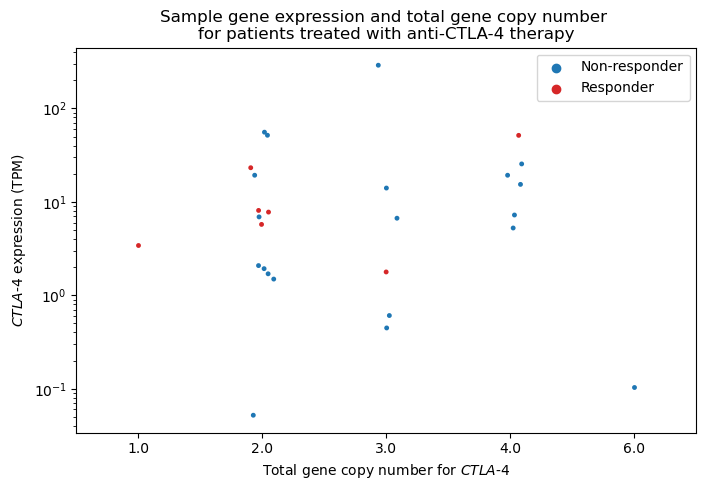

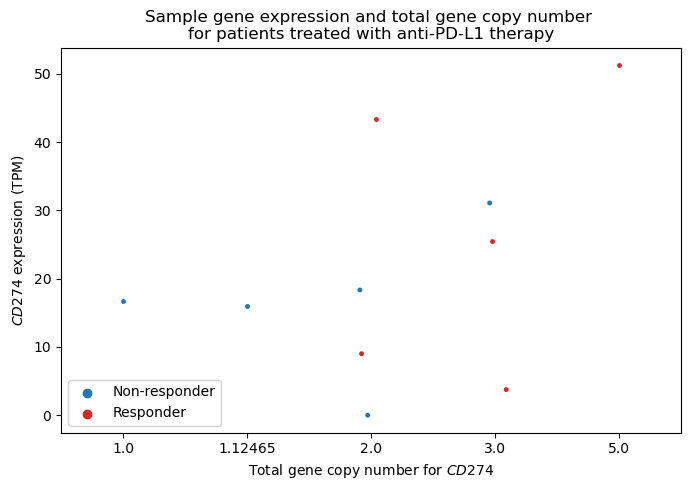

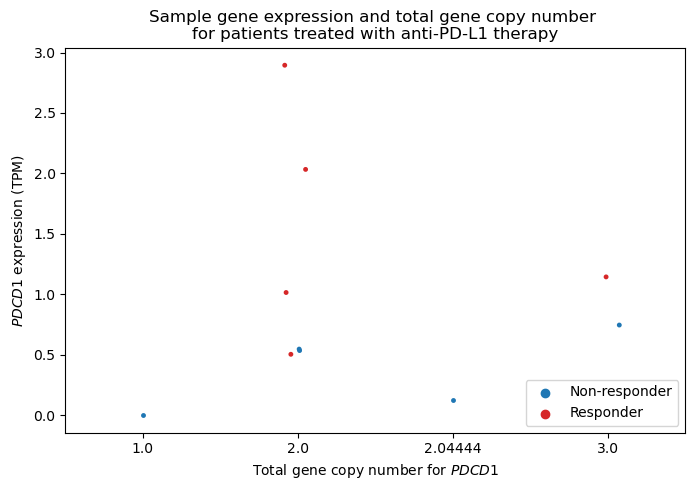

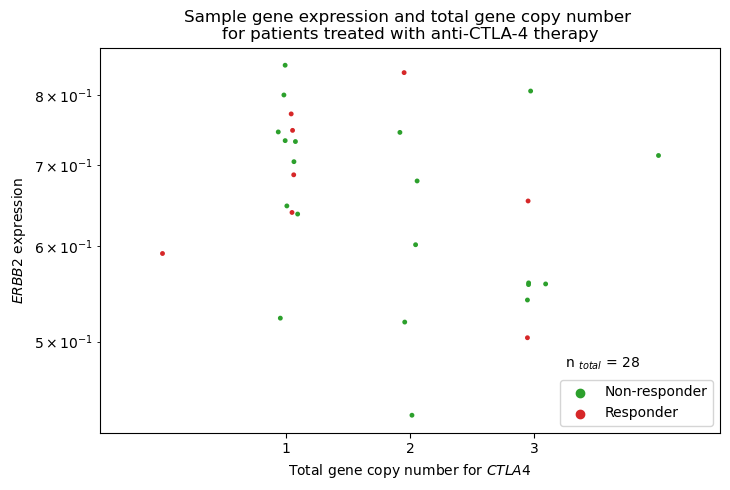

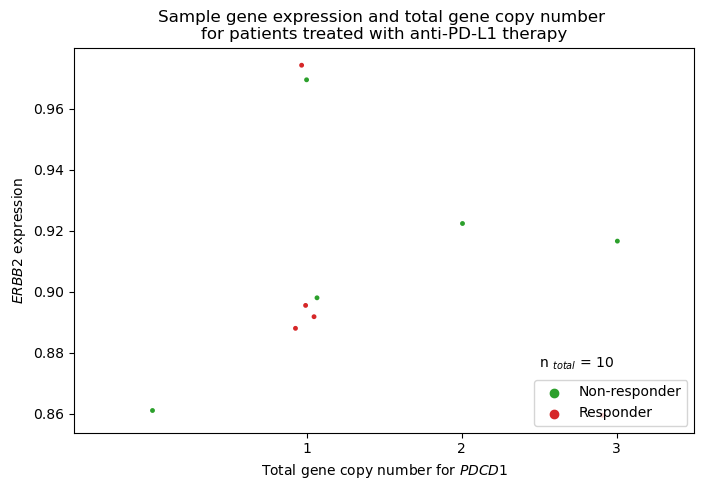

In [63]:


# CTLA4
expression = 'CTLA4 TPMs'
df = IO_CTLA4
total_points = len(df[expression].to_list())

fig, ax = plt.subplots(figsize=(8,5))
ax = sns.stripplot(data = df, y = expression, x = 'total_cn_CTLA4', hue = 'binary_outcome', 
                   size = 3.5, palette = ['tab:blue', 'tab:red'], jitter=0.1)
ax.set_yscale('log')
plt.ylabel('$CTLA$-4 expression (TPM)')
plt.xlabel('Total gene copy number for $CTLA$-4')
ax.set_title('Sample gene expression and total gene copy number \nfor patients treated with anti-CTLA-4 therapy')
ax.legend(loc='upper right', title='')
#ax.set_xticks([0,1,2,3, 4, 5, 6, 7, 8])
#ax.set_xticklabels([0,1,2,3, 4, 5, 6, 7, 8])

labels = {'1.0':'Responder', 
          '0.0':'Non-responder'
         }

for text in plt.gca().get_legend().texts:
    old_label = text.get_text()
    new_label = labels[old_label]
    text.set_text(new_label)

#ax.text(0.75, 0.17, 'n $_{total}$ = '+ str(total_points), transform=ax.transAxes, ha='left', fontsize=10)
#ax.set_xticklabels(('1', '2', '3', '4', '5', '6', '7', '8', '$\geq$9'))  # this is usually not done, since the data could move
#plt.axhline(y=19200, color='b', linestyle='--')
#plt.axvline(x=5.5, color='b', linestyle='--')
fig.patch.set_facecolor('none')
ax.patch.set_facecolor('none')
fig.savefig(pictures+'IO_CTLA4_cn_exp.png', dpi=500, bbox_inches='tight', transparent =True, facecolor=None)
plt.show()

# PD-L1
expression = 'CD274 TPMs'
df = IO_PD
total_points = len(df[expression].to_list())

fig, ax = plt.subplots(figsize=(8,5))
ax = sns.stripplot(data = df, y = expression, x = 'total_cn_CD274', hue = 'binary_outcome', 
                   size = 3.5, palette = ['tab:blue', 'tab:red'], jitter=0.1)
#ax.set_yscale('log')
ax.set_ylabel('$CD274$ expression (TPM)')
ax.set_xlabel('Total gene copy number for $CD274$')
ax.set_title('Sample gene expression and total gene copy number \nfor patients treated with anti-PD-L1 therapy')
ax.legend(loc='lower left', title='')
#ax.set_xticks([0,1,2,3,4])
#ax.set_xticklabels([0,1,2,3,4])

labels = {'1.0':'Responder', 
          '0.0':'Non-responder'
         }

for text in plt.gca().get_legend().texts:
    old_label = text.get_text()
    new_label = labels[old_label]
    text.set_text(new_label)

#ax.text(0.75, 0.17, 'n $_{total}$ = '+ str(total_points), transform=ax.transAxes, ha='left', fontsize=10)
#ax.set_xticklabels(('1', '2', '3', '4', '5', '6', '7', '8', '$\geq$9'))  # this is usually not done, since the data could move
#plt.axhline(y=19200, color='b', linestyle='--')
#plt.axvline(x=5.5, color='b', linestyle='--')
fig.patch.set_facecolor('none')
ax.patch.set_facecolor('none')
fig.savefig(pictures+'IO_CD274_cn_exp.png', dpi=500, bbox_inches='tight', transparent =True, facecolor=None)
plt.show()

# PDCD1
expression = 'PDCD1 TPMs'
df = IO_PD
total_points = len(df[expression].to_list())

fig, ax = plt.subplots(figsize=(8,5))
ax = sns.stripplot(data = df, y = expression, x = 'total_cn_PDCD1', hue = 'binary_outcome', 
                   size = 3.5, palette = ['tab:blue', 'tab:red'], jitter=0.1)
#ax.set_yscale('log')
plt.ylabel('$PDCD1$ expression (TPM)')
plt.xlabel('Total gene copy number for $PDCD1$')
ax.set_title('Sample gene expression and total gene copy number \nfor patients treated with anti-PD-L1 therapy')
ax.legend(loc='lower right', title='')
#ax.set_xticks([1,2,3])
#ax.set_xticklabels([1,2,3])

labels = {'1.0':'Responder', 
          '0.0':'Non-responder'
         }

for text in plt.gca().get_legend().texts:
    old_label = text.get_text()
    new_label = labels[old_label]
    text.set_text(new_label)

#ax.text(0.75, 0.17, 'n $_{total}$ = '+ str(total_points), transform=ax.transAxes, ha='left', fontsize=10)
#ax.set_xticklabels(('1', '2', '3', '4', '5', '6', '7', '8', '$\geq$9'))  # this is usually not done, since the data could move
#plt.axhline(y=19200, color='b', linestyle='--')
#plt.axvline(x=5.5, color='b', linestyle='--')
fig.patch.set_facecolor('none')
ax.patch.set_facecolor('none')

fig.savefig(pictures+'IO_PDCD1_cn_exp.png', dpi=500, bbox_inches='tight', transparent =True, facecolor=None)
plt.show()

# ERBB2 in anti-CTLA-4
expression = 'ERBB2 percentile'
df = IO_CTLA4
total_points = len(df[expression].to_list())

fig, ax = plt.subplots(figsize=(8,5))
ax = sns.stripplot(data = df, y = expression, x = 'total_cn_CTLA4', hue = 'binary_outcome', 
                   size = 3.5, palette = ['tab:green', 'tab:red'], jitter=0.1)
ax.set_yscale('log')
plt.ylabel('$ERBB2$ expression')
plt.xlabel('Total gene copy number for $CTLA4$')
ax.set_title('Sample gene expression and total gene copy number \nfor patients treated with anti-CTLA-4 therapy')
ax.legend(loc='lower right', title='')
ax.set_xticks([1,2,3])
ax.set_xticklabels([1,2,3])

labels = {'1.0':'Responder', 
          '0.0':'Non-responder'
         }

for text in plt.gca().get_legend().texts:
    old_label = text.get_text()
    new_label = labels[old_label]
    text.set_text(new_label)

ax.text(0.75, 0.17, 'n $_{total}$ = '+ str(total_points), transform=ax.transAxes, ha='left', fontsize=10)
#ax.set_xticklabels(('1', '2', '3', '4', '5', '6', '7', '8', '$\geq$9'))  # this is usually not done, since the data could move
#plt.axhline(y=19200, color='b', linestyle='--')
#plt.axvline(x=5.5, color='b', linestyle='--')
fig.patch.set_facecolor('none')
ax.patch.set_facecolor('none')

fig.savefig(pictures+'IO_CTLA4_ERBB2.png', dpi=500, bbox_inches='tight', transparent =True, facecolor=None)
plt.show()

# ERBB2 percentile in anti-PD-L1
expression = 'ERBB2 percentile'
df = IO_PD
total_points = len(df[expression].to_list())

fig, ax = plt.subplots(figsize=(8,5))
ax = sns.stripplot(data = df, y = expression, x = 'total_cn_PDCD1', hue = 'binary_outcome', 
                   size = 3.5, palette = ['tab:green', 'tab:red'], jitter=0.1)
#ax.set_yscale('log')
plt.ylabel('$ERBB2$ expression')
plt.xlabel('Total gene copy number for $PDCD1$')
ax.set_title('Sample gene expression and total gene copy number \nfor patients treated with anti-PD-L1 therapy')
ax.legend(loc='lower right', title='')
ax.set_xticks([1,2,3])
ax.set_xticklabels([1,2,3])

labels = {'1.0':'Responder', 
          '0.0':'Non-responder'
         }

for text in plt.gca().get_legend().texts:
    old_label = text.get_text()
    new_label = labels[old_label]
    text.set_text(new_label)

ax.text(0.75, 0.17, 'n $_{total}$ = '+ str(total_points), transform=ax.transAxes, ha='left', fontsize=10)
#ax.set_xticklabels(('1', '2', '3', '4', '5', '6', '7', '8', '$\geq$9'))  # this is usually not done, since the data could move
#plt.axhline(y=19200, color='b', linestyle='--')
#plt.axvline(x=5.5, color='b', linestyle='--')
fig.patch.set_facecolor('none')
ax.patch.set_facecolor('none')

fig.savefig(pictures+'IO_PDCD1_ERBB2.png', dpi=500, bbox_inches='tight', transparent =True, facecolor=None)
plt.show()

In [ ]:
# get data
IO = open_df(processed + 'IO_cohort.csv', sep = ',')

# drop rows with unclear outcome (non binary)
IO = IO[IO['binary_outcome'].notna()]

# make column with total gene copy number
columns = {'total_cn_CD274':['rescaled.cn.a1_CD274', 'rescaled.cn.a2_CD274'],
           'total_cn_PDCD1':['rescaled.cn.a1_PDCD1', 'rescaled.cn.a2_PDCD1'],
           'total_cn_CTLA4':['rescaled.cn.a1_CTLA4', 'rescaled.cn.a2_CTLA4']}

for col in columns: 
    IO[col] = IO.loc[:,columns[col]].sum(axis=1)
    


In [ ]:
df = IO_PD.copy()

#plt.scatter(y=df['CD274'].to_list(), x=df['total_cn_CD274'].to_list())
#plt.xticks([1,2,3,4,5])
print(df['total_cn_CD274'])

sns.stripplot(data = df, y = 'CTLA4', x = 'total_cn_CTLA4', hue = 'binary_outcome', size = 3.5, palette = ['tab:green', 'tab:red'], jitter=0.1)
plt.xticks([1,2,3,4,5])
plt.xticklabels([1,2,3,4,5])

## 11.1 Total copy number <a class="anchor" id="11.1"></a> [↑](#Content)

In [64]:
save = True  

# python version
# 3.9.7

# imports

import os 
import pandas as pd 
import numpy as np

# directory for processed files
processed = 'C:\\Users\\User\\Desktop\\Big_files\\DATA\\processed_files\\'

# functions

def open_df(file, sep = '\t', header = 0):
    '''
    Opens a file as pandas dataframe

    :param file: file path and name including extension 
    :return: pd.DataFrame()
    '''
    try:
        df = pd.read_csv(file, sep=sep, low_memory=False, header = header)
        return df
    except:
        print(f'Error opening {file}')
        
# imports

import os 
import pandas as pd 
import numpy as np

from sklearn import metrics

from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

from matplotlib.ticker import MaxNLocator

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# functions

def cn_converter(df, col, thr):
    '''
    Transforms the numbers in a choosen col to 1 or 0 
    depending on the choosen threshold. 
    
    :param df:
    :param col: column where threshold is applied
    :param thr: threshold. Note: threshold value and higher is positive
    :return: df with transformed col (rest stays the same)
    '''
    df = df.copy()
    df[col] = np.where(df[col] <= thr, 1, 0)
    return df

def ihc_converter(df, col, pos, neg):
    '''
    Modifies the status by IHC to binary based 
    on the two specified values (everything else = None)
    
    :param df: input df
    :param col: column where the IHC status is
    :param pos: values that are converted to 1
    :param neg: values that are converted to 0
    :return: df with transformed col (rest of df stays the same)
    '''
    rules = {pos:1, neg:0}
    rest = list(df[col].unique())
    rest.remove(pos)
    rest.remove(neg)
    for i in rest:
        rules[str(i)] = None
    return df.replace({col: rules})

def confusion(df, col1, col2):
    '''
    Calculates the confusion table from two specified columns
    
    :param df:
    :param col1: ground-truth
    :param col2: predicted values
    :return:
    '''
    truth = list(df[col1])
    predictions = list(df[col2])
    tn, fp, fn, tp = metrics.confusion_matrix(truth, predictions, normalize=None).ravel() # ravel() used as the functions returns an array
    return tn, fp, fn, tp

def confusion_plot(tn, fp, fn, tp, thr, x, y, x_label_true_neg, x_label_true_pos):
    '''
    Makes a plot with the binary confusion data
    
    :param tn:
    :param fp:
    :param fn:
    :param tp:
    :param thr: threshold used for correct annotation
    :param x: annotation of x-axis (predicted values)
    :param y: annotation of y-axis (true values)
    '''
    true_predictions_perc = round(100* (tp + tn)/(tn + fp + fn + tp), 1)  # used for putting in the title
    data = np.array([[tn, fp], [fn, tp]])  # array for plotting a heatmap 
    fig, ax = plt.subplots()  # creates an empty canvas
    heatmap = ax.imshow(data, cmap='GnBu')  # makes the heatmap with the array and the specified colors 
    for (i, j), val in np.ndenumerate(data):  # goes throught the array and takes the values
        ax.text(j, i, val, ha="center", va="center", color="black")  # print the values in the specific cases
    cbar = fig.colorbar(heatmap)  # adds a colorbar for the heatmap
    ax.set_xticks([0, 1])  # sets a tick
    false = r'$<$'+str(thr)  # math mode + choosen threshold
    true = r'$\geq$'+str(thr)
    ax.set_xticklabels([false, true])
    ax.set_yticks([0, 1])
    ax.set_yticklabels([x_label_true_neg, x_label_true_pos])  # true labels
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_title(f'Confusion Table\n{true_predictions_perc}% were correctly predicted')
    plt.show()
    
def threshold_accuracy(df_in, col1, col2, min_thr, max_thr):
    '''
    Calculates the accuracy of copy numbers predictions for status 
    for several thresholds and returns the accuracy vs the threshold
    
    :param df: df with ground-truth and copy numbers 
    :param col1: gound-truth
    :param col2: copy numbers
    :param min_thr:
    :param max_thr: 
    :return: two lists of threshold and accuracies
    '''
    thresholds = list(range(min_thr, max_thr))
    accuracy_scores = []
    
    for thr in thresholds:

        df = df_in.copy()
        
        df[col2] = np.where(df[col2] <= thr, 1, 0)
        
        truth = list(df[col1])
        predictions = list(df[col2])
        acc = accuracy_score(truth, predictions)
        accuracy_scores.append(acc)
        
    return thresholds, accuracy_scores

def threshold_f1(df_in, col1, col2, min_thr, max_thr):
    '''
    Calculates the f1-scores of copy numbers predictions for status 
    for several thresholds and returns the f1 scores vs the threshold
    
    :param df: df with ground-truth and copy numbers 
    :param col1: gound-truth
    :param col2: copy numbers
    :param min_thr:
    :param max_thr: 
    :return: two lists of threshold and f1 scores
    '''
    thresholds = list(range(min_thr, max_thr))
    f1_scores = []
    
    for thr in thresholds:

        df = df_in.copy()
        
        df[col2] = np.where(df[col2] <= thr, 1, 0)
        
        truth = list(df[col1])
        predictions = list(df[col2])
        f1 = f1_score(truth, predictions)
        f1_scores.append(f1)
        
    return thresholds, f1_scores

def scatter_plot(list1, list2, title='title'): 
    '''
    Plots the two lists in a scatter plot
    
    :param lsit1:
    :param list2:
    :retunr:
    '''
    fig, ax = plt.subplots()
    ax.scatter(list1, list2)
    ax.set_title(title)
    plt.xticks(range(min(list1),max(list1),2))
    ax.set_xlabel('threshold')
    plt.show()
    
def swarm_plot(df, x, y, x_label, y_label, hue = None, title='Title'):
    '''
    Make a swarm plot with the gene expression data, separated by HER2 status by IHC
    
    :param df: input df, must be clean and tidy for seaborn (long format)
    :param x: x-axis, thought to be the HER2 status by IHC
    :param y: y-axis, thought to be the gene expression
    :param x_label:
    :param y_label: 
    :param title:
    :return: print the plots
    '''
    fig, ax = plt.subplots()
    
    sns.swarmplot(data = df, x = x, y = y, hue = hue)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    fig.suptitle(title)
    plt.show()

In [65]:
# get data
IO = open_df(processed + 'IO_cohort.csv', sep = ',')

# drop rows with unclear outcome (non binary)
IO = IO[IO['binary_outcome'].notna()]

# make column with total gene copy number
columns = {'total_cn_CD274':['rescaled.cn.a1_CD274', 'rescaled.cn.a2_CD274'],
           'total_cn_PDCD1':['rescaled.cn.a1_PDCD1', 'rescaled.cn.a2_PDCD1'],
           'total_cn_CTLA4':['rescaled.cn.a1_CTLA4', 'rescaled.cn.a2_CTLA4']}

for col in columns: 
    IO[col] = IO.loc[:,columns[col]].sum(axis=1)

# subset according to treatment
IO_CTLA4 = IO[IO['drug_type']=='anti-CTLA-4']  # 28 samples
IO_PD = IO[IO['drug_type']=='anti-PD-1/anti-PD-L1']  # 10 samples
IO_both = IO[IO['drug_type']=='anti-CTLA-4 + anti-PD-1/PD-L1']  # 6 samples

--------------------------CTLA-4------------------------------


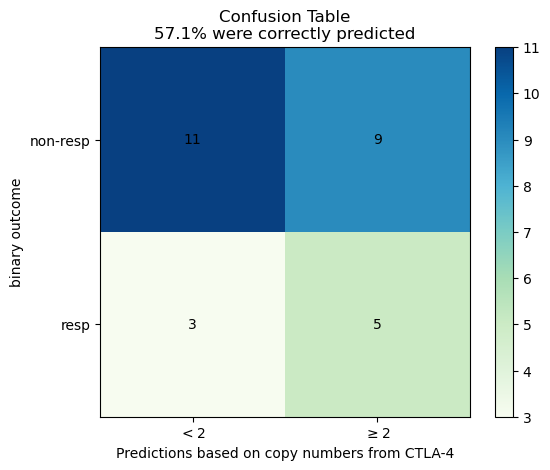

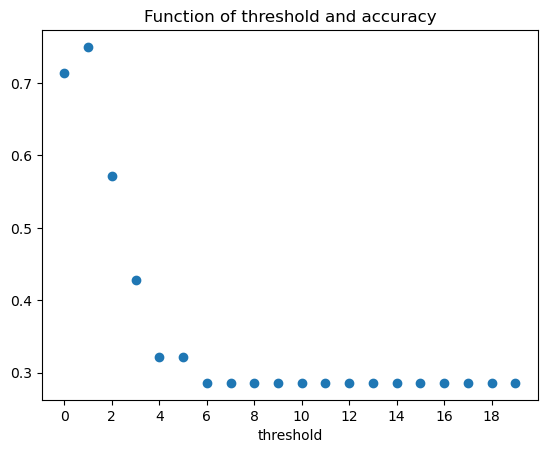

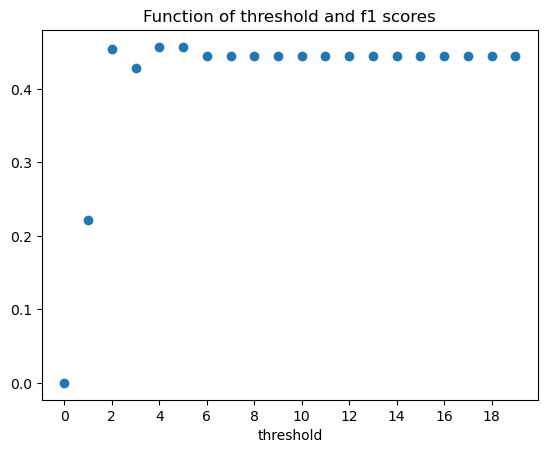

--------------------------PD-L1------------------------------


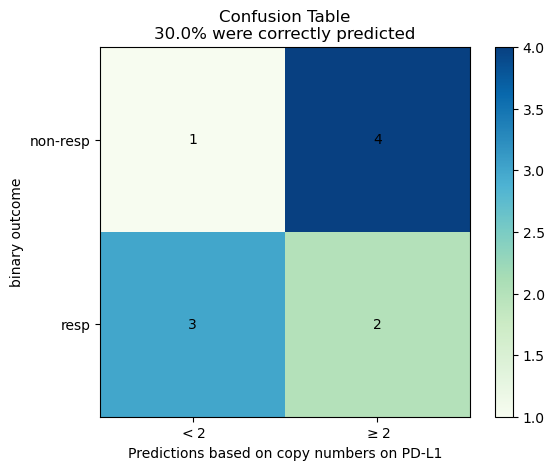

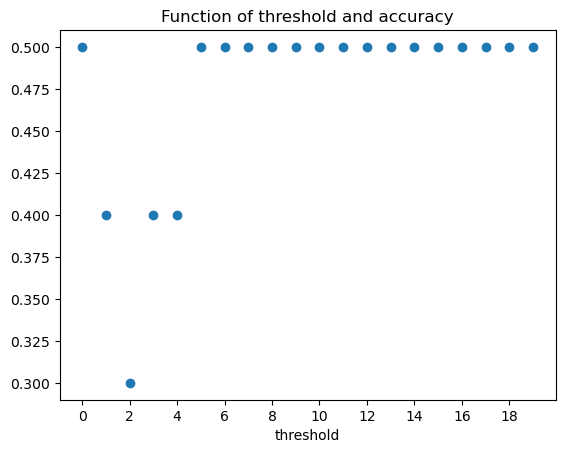

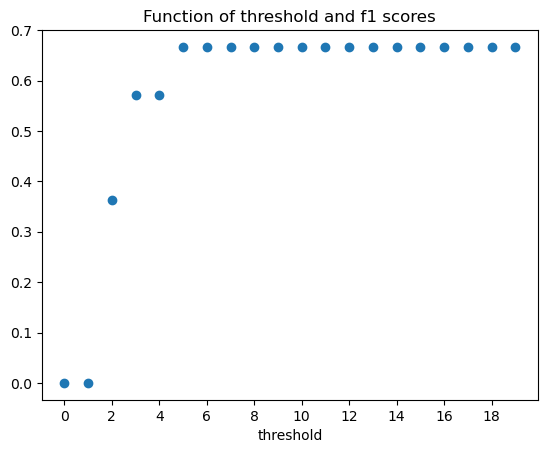

In [66]:
## for CTLA-4 ##

print('--------------------------CTLA-4------------------------------')

# setting the threshold
threshold = 2

# tranforming the copy number to binary
df = cn_converter(IO_CTLA4, 'total_cn_CTLA4', threshold)

# calculating confusion matrix
tn, fp, fn, tp = confusion(df, 'binary_outcome', 'total_cn_CTLA4')

# making a plot
confusion_plot(tn, fp, fn, tp, threshold, 'Predictions based on copy numbers from CTLA-4', 'binary outcome', 'non-resp', 'resp')

# making a function of the threshold and the accuracy 
scatter_plot(*threshold_accuracy(IO_CTLA4, 'binary_outcome', 'total_cn_CTLA4', 0, 20), 
             title = 'Function of threshold and accuracy')
scatter_plot(*threshold_f1(IO_CTLA4, 'binary_outcome', 'total_cn_CTLA4', 0, 20), 
             title = 'Function of threshold and f1 scores')

## for PDL-1 and PD-1 ##

print('--------------------------PD-L1------------------------------')

# setting the threshold
threshold = 2

# tranforming the copy number to binary
df = cn_converter(IO_PD, 'total_cn_CD274', threshold)

# calculating confusion matrix
tn, fp, fn, tp = confusion(df, 'binary_outcome', 'total_cn_CD274')

# making a plot
confusion_plot(tn, fp, fn, tp, threshold, 'Predictions based on copy numbers on PD-L1', 'binary outcome', 'non-resp', 'resp')

# making a function of the threshold and the accuracy 
scatter_plot(*threshold_accuracy(IO_PD, 'binary_outcome', 'total_cn_CD274', 0, 20), 
             title = 'Function of threshold and accuracy')
scatter_plot(*threshold_f1(IO_PD, 'binary_outcome', 'total_cn_CD274',0, 20), 
             title = 'Function of threshold and f1 scores')

In [ ]:
IO_PD[['total_cn_CD274', 'CD274 TPMs', 'binary_outcome']]

In [ ]:
# plot copy numbers
swarm_plot(IO_CTLA4, 'binary_outcome', 'total_cn_CTLA4', 'binary outcome', 'Total copy number', 
         title = 'Distribution of total copy number for CTLA-4')

swarm_plot(IO_PD, 'binary_outcome', 'total_cn_CD274', 'binary outcome', 'Total copy number', 
         title = 'Distribution of total copy number for PD-L1')

swarm_plot(IO_PD, 'binary_outcome', 'total_cn_PDCD1', 'binary outcome', 'Total copy number', 
         title = 'Distribution of total copy number for PD-1')

## 11.2 Allele-specific copy number <a class="anchor" id="11.2"></a> [↑](#Content)

In [3]:
# imports

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from tqdm import tqdm

# functions

def col_to_array(full_df, val1, val2=None, val3=None, mask=None):
    '''
    Returns an array with val1 and val2 (optional) 
    after applying a selection (mask)
    
    :param df: 
    :param val1: column to select
    :param val2: column to select (optional)
    :param mask: mask to subset df (optional)
    :return: np.array with the values
    '''
    if not (mask is None):
        df = full_df[mask]
        df = df.copy()
    else:
        df = full_df
    if val3 != None:
        return df[[val1, val2, val3]].to_numpy()
    elif val2 != None:
        return df[[val1, val2]].to_numpy()
    else:
        return df[[val1]].to_numpy()

def data_split(X, y):
    ''' 
    Splits the data in train and test set
    
    Test size can be change, 0.2 means that 20% is used for testing
    setting random_state results in constant results
    
    :param X: matrix for the x values
    :param y: true labels (list)
    :return: X_train, X_test, y_train, y_test
    '''
    sss = StratifiedShuffleSplit(test_size = 0.2, random_state = None, n_splits = 10)

    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    return X_train, X_test, y_train, y_test

def choose_function(fun_dict, name, *args, **kwargs):
    '''
    Based on the dictionnary and the name provided,
    a values will be returned
    
    :param fun_dict: dict containing the function description (key) and function (value)
    :param name: function to choose
    :return: function
    '''
    function = fun_dict[name]
    return function(*args, **kwargs)

def logistic_train_predict(X, y, test_set):
    '''
    uses the input for training and then predicts the values for the test set
    
    :param X: matrix of values for training
    :param y: true labels for training set
    :param test_set: test set (same structure as X) which will be used for the predictions
    :return: list of prediction based on the test_set
    '''
    model = LogisticRegression(random_state=None).fit(X, y)
    params = model.intercept_
    return model.predict(test_set)    

def confusion_table(truth, prediction):
    '''
    Calculates the confusion table from 2 lists
    
    :param truth: list 
    :param prediction: list
    :return: tn, fp, fn, tp
    '''
    return metrics.confusion_matrix(truth, prediction, normalize=None).ravel()

def confusion_plot(tn, fp, fn, tp, x, y, x_label_true_neg, x_label_true_pos):
    '''
    Makes a plot with the binary confusion data
    
    :param tn:
    :param fp:
    :param fn:
    :param tp:
    :param x: annotation of x-axis (predicted values)
    :param y: annotation of y-axis (true values)
    :param x_label_true_neg: negative label (here applied to truth & predicted)
    :param x_label_true_pos: positive label
    :return: Show graph
    '''
    true_predictions_perc = round(100* (tp + tn)/(tn + fp + fn + tp), 1)
    data = np.array([[tn, fp], [fn, tp]]) 
    fig, ax = plt.subplots() 
    heatmap = ax.imshow(data, cmap='GnBu')  
    for (i, j), val in np.ndenumerate(data):  
        ax.text(j, i, val, ha="center", va="center", color="black")  
    cbar = fig.colorbar(heatmap) 
    ax.set_xticks([0, 1])
    false = x_label_true_neg
    true = x_label_true_pos
    ax.set_xticklabels([false, true])
    ax.set_yticks([0, 1])
    ax.set_yticklabels([x_label_true_neg, x_label_true_pos])  # true labels
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_title(f'Confusion Table\n{true_predictions_perc}% were correctly predicted')
    plt.show()
    
def get_metrics(y_true, y_pred):
    '''
    Calculates accuarcy, precision, recall and F1 score from two lists 
    
    
    :param truth:
    :param prediction:
    :return: accuracy, precision, recall, F1
    '''
    accuracy = accuracy_score(y_true, y_pred, normalize=True) 
    precision = precision_score(y_true, y_pred, average='binary', 
                                zero_division = 0) #, pos_label = 'Positive')  # there are zero division, which will result in 0
    recall = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary') #, pos_label = 'Positive')
    return accuracy, precision, recall, f1
        

def random_forest_train_predict(X, y, test_set):
    '''
    uses the input for training and then predicts the values for the test set
    
    :param X: matrix of values for training
    :param y: true labels for training set
    :param test_set: test set (same structure as X) which will be used for the predictions
    :return: list of prediction based on the test_set
    '''
    model = RandomForestClassifier(random_state=None).fit(X, y)
    return model.predict(test_set) 

def iterate_workflow(X, y, model_type, n_iterations=100, print_table=False, print_boxplot=True, title='Title'):
    '''
    Does n iteration of data splitting, training, predictions 
    with the option to plot confusion tables
    or plots accuracy, precision, recall and F1 as boxplots
    :param X:
    :param y:
    :param model_type:
    :param n_iterations:
    :param print_table:
    :param print_boxplot:
    :return:
    '''
    function_dict = {'logistic':logistic_train_predict,
                     'forest':random_forest_train_predict}
    a_s = []  # lists of scores, accuracy
    p_s = list()  # precision
    r_s = list()  # recall
    f_s = list()  # F1
    for n in tqdm(range(n_iterations)):
        X_train, X_test, y_train, y_test = data_split(X, y)
        predictions = choose_function(function_dict, model_type, X_train, y_train, X_test)
        if print_table == True:
            tn, fp, fn, tp = confusion_table(y_test, predictions)
            confusion_plot(tn, fp, fn, tp, f'Predictions with {model_type}', 'Status by IHC', 'HER2-', 'HER2+')
        if print_boxplot == True:
            a_val, p_val, r_val, f_val = get_metrics(y_test, predictions)
            a_s.append(a_val)
            p_s.append(p_val)
            r_s.append(r_val)
            f_s.append(f_val)
    if print_boxplot == True:
        fig, axes = plt.subplots(figsize = (15,8), nrows=1, ncols = 4)
        data = pd.DataFrame({'Accuracy':a_s, 'Precision':p_s, 'Recall':r_s, 'F1-score':f_s})
        sns.boxplot(data=data, y = 'Accuracy', showmeans=True, ax=axes[0])
        sns.boxplot(data=data, y = 'Precision', palette = 'pastel', showmeans=True, ax=axes[1])
        sns.boxplot(data=data, y = 'Recall', palette = 'pastel', showmeans = True, ax=axes[2])
        sns.boxplot(data=data, y = 'F1-score', palette = 'pastel', showmeans = True, ax=axes[3])
        axes[0].set_ylim(0,1)
        axes[1].set_ylim(0,1)
        axes[2].set_ylim(0,1)
        axes[3].set_ylim(0,1)
        fig.suptitle(title)
        plt.show()

def bubble_scatter(df, x, y, x_label, y_label, hue, size, title='Title', model=None):
    '''
    
    :param df:
    :param x:
    :param y:
    :param x_label:
    :param y_label:
    :param hue:
    :param title:
    :param model:
    :return:
    '''
    
    fig, axes = plt.subplots(figsize = (8,8), nrows=1, ncols = 1)
    
    sns.scatterplot(data=df, x=x, y=y, size=size, hue=hue, ax=axes, alpha = 0.5, sizes = (20,200))
    if model is not None:
        beta_0, beta_1, beta_2 = model_betas(model)
        x_vals = np.arange(0.6, 17.5, 0.1)
        y_vals = list(map(lambda i: (np.log(1)+ beta_0 + beta_1*i)/(-beta_2),x_vals))
        axes.plot(x_vals, y_vals, '-', c="red")
    axes.set_xlabel(x_label)
    axes.set_ylabel(y_label)
    axes.set_xlim(-0.5,6)
    axes.set_ylim(-0.5,5)
    fig.suptitle(title)
    plt.show()
    
def grouper(df, col1, col2, col3, col_sum):
    '''
    Groups rows with identical values for three columns together 
    and indicates how many have been merged by making the sum
    in the column with col_sum
    (the best is to have 1 in all col_sum)
    
    :param df:
    :param col1: group by this column
    :param col2:
    :param col3:
    :param col_sum: values in this col will be summed after merging
    :return: new df
    '''
    functions = {col_sum:'sum'} 
    new_df = df.groupby([col1, col2, col3]).aggregate(functions).reset_index()
    return new_df

def model_betas(model):
    '''
    Calculates the decision formula based on the model coefficients and model intercept
    :param model:
    :return: betas of the model
    '''
    coefficients = model.coef_
    intercept = model.intercept_
    beta_1 = coefficients[0,0]
    beta_2 = coefficients[0,1]
    beta_0 = intercept
    # p = (1/(1+pow(e,-(beta_0+beta_1*x_1+beta_2*x_2))))  # get x_1 and x_2 from X_test
    # y = (0.5-beta_0 - beta_1*x)/(beta_2)  # formula to draw the line at p = 0.5
    return beta_0, beta_1, beta_2

def group_boxplots(df, group, values, allele, status, title='Title'):
    '''
    Make a figure with major and minor cn as whiskers, separated by ihc status and
    for each group a subplot
    
    :param df:
    :param group: col where the group for subplot are
    :param values: col where the values are
    :param allele: col where the category minor / major is
    :param status: col where the status by IHC is
    :param title:
    :return: 
    '''
    groups = list(df[group].unique())
    
    fig, axs = plt.subplots(figsize = (15,8), nrows=1, ncols = len(groups))
    axs = np.atleast_1d(axs)
    for grp in groups:
        index = groups.index(grp)
        sel = (df[group] == grp) # selecting only the group specific data
        data = df[sel]
        data = data.copy()
        n_pos = int(len(data[(data[status]==1)])/2) # division by 2 required as tidy
        n_neg = int(len(data[(data[status]==0)])/2)
        sns.boxplot(data=data, orient='v', y=values, x=allele, 
                    hue=status, ax=axs[index], palette = 'pastel',showmeans=True)
        
        axs[index].set_xlabel(f'{grp}, n = {int(len(data)/2)}, {n_neg} and {n_pos}')
        axs[index].set_ylim(0,5)
        
    fig.suptitle(title)
    plt.show()


def tidy(df, col1, col2, new_col1, new_col2):
    '''
    Tidies up two columns by putting the values in a single column
    and adds a column for the category
    
    :param df:
    :param col1: col 1 to be merged 
    :param col2: col 2 to be merged
    :param new_col1: name of the col with the merged values
    :param new_col2: name of the col with the new category
    :return: modified df
    '''
    untouched = df.columns.values.tolist()
    untouched = [element for element in untouched if element != col1]
    untouched = [element for element in untouched if element != col2]
    return df.melt(value_vars=[col1, col2], var_name=new_col2, value_name=new_col1, id_vars=untouched)

In [28]:
# get data
IO = open_df(processed + 'IO_cohort.csv', sep = ',')

# drop rows with unclear outcome (non binary)
IO = IO[IO['binary_outcome'].notna()]

# make column with total gene copy number
columns = {'total_cn_CD274':['rescaled.cn.a1_CD274', 'rescaled.cn.a2_CD274'],
           'total_cn_PDCD1':['rescaled.cn.a1_PDCD1', 'rescaled.cn.a2_PDCD1'],
           'total_cn_CTLA4':['rescaled.cn.a1_CTLA4', 'rescaled.cn.a2_CTLA4']}

for col in columns: 
    IO[col] = IO.loc[:,columns[col]].sum(axis=1)

# subset according to treatment
IO_CTLA4 = IO[IO['drug_type']=='anti-CTLA-4']  # 28 samples
IO_PD = IO[IO['drug_type']=='anti-PD-1/anti-PD-L1']  # 10 samples
IO_both = IO[IO['drug_type']=='anti-CTLA-4 + anti-PD-1/PD-L1']  # 6 samples

In [33]:
df = IO_PD.copy()

minor = 'rescaled.cn.a1_PDCD1'
major = 'rescaled.cn.a2_PDCD1'

df[minor] = df[minor].astype(int)
df[major] = df[major].astype(int)
df['binary_outcome'].astype(int)
df['binary_outcome'] = df['binary_outcome'].map({1: 'positive', 0: 'negative'})

df.insert(2,'number',1)
df_counted = grouper(df, 'binary_outcome', minor, major, 'number')


from plotnine import *

p = (ggplot(df_counted, aes(x=major, y=minor, size='number', color='binary_outcome')) 
     + geom_point(alpha=0.5) 
     + labs(x='Major copy number (PD-1)', y='Minor copy number (PD-1)', size='number', color='response (RECIST)', 
            title='Allele-specific copy numbers for anti-PD-L1/PD-1 samples')
     + theme_matplotlib()
     + theme(figure_size=(5,5))
     + scale_size_continuous(breaks=[1, 2,5, 10], range = (2, 16), name='number of samples')
     + scale_color_manual(values={'positive': 'red', 'negative': 'blue'})
     + scale_x_continuous(breaks=[0,1,2,3,4,5,6,7], minor_breaks=None, expand=(0.1,0))
     + scale_y_continuous(breaks=[0,1,2,3,4,5,6,7], minor_breaks=None)
     
)\
.save(pictures+"bubbleplot_IO_PDCD1.png", dpi=500)
print(p)
print(df['binary_outcome'].value_counts())

C:\Users\User\anaconda3\lib\site-packages\plotnine\ggplot.py:718: PlotnineWarning: Saving 5 x 5 in image.
C:\Users\User\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Filename: C:\Users\User\Desktop\Big_files\DATA\figures\bubbleplot_IO_PDCD1.png


None
positive    5
negative    5
Name: binary_outcome, dtype: int64


In [7]:
df

,pair_id,Tumor_Sample_Barcode,number,RNA_sample_id,patient_id,cancer_type,age_start_io,sex,RECIST,os_days,...,sample_y,rescaled.cn.a1_CD274,rescaled.cn.a1_CTLA4,rescaled.cn.a1_PDCD1,rescaled.cn.a2_CD274,rescaled.cn.a2_CTLA4,rescaled.cn.a2_PDCD1,total_cn_CD274,total_cn_PDCD1,total_cn_CTLA4
3,CR6126_T_N,CR6126_T,1,CR6126_T,CR6126,Melanoma,NaN,FEMALE,CR,707.0,...,CR6126_T_N,0.0,1.0,1.00000,1.0,2.0,1.00709,1.0,2.00709,3.0
19,MEL-IPI_Pat03-TP-NB-SM-4DJZY-SM-4NFU5,MEL-IPI_Pat03-Tumor-SM-4DJZY,1,MEL-IPI_Pat03-Tumor-SM-4DJZY,Pat03,Melanoma,61.0,FEMALE,PD,100.0,...,MEL-IPI_Pat03-TP-NB-SM-4DJZY-SM-4NFU5,0.0,1.0,1.00000,1.0,1.0,1.00000,1.0,2.00000,2.0
20,MEL-IPI_Pat04-TP-NB-SM-4DJZZ-SM-4NFU6,MEL-IPI_Pat04-Tumor-SM-4DJZZ,1,MEL-IPI_Pat04-Tumor-SM-4DJZZ,Pat04,Melanoma,71.0,MALE,PR,987.0,...,MEL-IPI_Pat04-TP-NB-SM-4DJZZ-SM-4NFU6,0.0,2.0,2.00000,2.0,2.0,2.00000,2.0,4.00000,4.0
21,MEL-IPI_Pat06-TP-NB-SM-4DK12-SM-4NFU8,MEL-IPI_Pat06-Tumor-SM-4DK12,1,MEL-IPI_Pat06-Tumor-SM-4DK12,Pat06,Melanoma,33.0,MALE,PD,161.0,...,MEL-IPI_Pat06-TP-NB-SM-4DK12-SM-4NFU8,1.0,1.0,0.00000,1.0,3.0,1.00000,2.0,1.00000,4.0
22,MEL-IPI_Pat08-TP-NB-SM-4DK14-SM-4NFUA,MEL-IPI_Pat08-Tumor-SM-4DK14,1,MEL-IPI_Pat08-Tumor-SM-4DK14,Pat08,Melanoma,73.0,MALE,PD,140.0,...,MEL-IPI_Pat08-TP-NB-SM-4DK14-SM-4NFUA,0.0,0.0,0.00000,2.0,3.0,2.00000,2.0,2.00000,3.0
23,MEL-IPI_Pat117-TP-NT-SM-5X2QU-SM-5X2RC,MEL-IPI_Pat117-Tumor-SM-5X2QU,1,MEL-IPI_Pat117-Tumor-SM-67QDH,Pat117,Melanoma,74.0,MALE,PR,914.0,...,MEL-IPI_Pat117-TP-NT-SM-5X2QU-SM-5X2RC,0.0,2.0,0.00000,2.0,2.0,2.00000,2.0,2.00000,4.0
24,MEL-IPI_Pat118-TP-NT-SM-5X2QV-SM-5X2RD,MEL-IPI_Pat118-Tumor-SM-5X2QV,1,MEL-IPI_Pat118-Tumor-SM-5X2QV,Pat118,Melanoma,43.0,FEMALE,PD,313.0,...,MEL-IPI_Pat118-TP-NT-SM-5X2QV-SM-5X2RD,0.0,1.0,1.00000,2.0,3.0,5.00000,2.0,6.00000,4.0
25,MEL-IPI_Pat119-TP-NT-SM-7459N-SM-7459Q,MEL-IPI_Pat119-Tumor-SM-7459N,1,MEL-IPI_Pat119-Tumor-SM-7459N,Pat119,Melanoma,61.0,MALE,PD,808.0,...,MEL-IPI_Pat119-TP-NT-SM-7459N-SM-7459Q,0.0,1.0,1.00000,1.0,1.0,1.00000,1.0,2.00000,2.0
27,MEL-IPI_Pat126-TP-NB-SM-5X2R4-SM-5VWHO,MEL-IPI_Pat126-Tumor-SM-5X2R4,1,MEL-IPI_Pat126-Tumor-SM-5X2R4,Pat126,Melanoma,77.0,MALE,PR,641.0,...,MEL-IPI_Pat126-TP-NB-SM-5X2R4-SM-5VWHO,1.0,1.0,1.00000,1.0,1.0,1.00000,2.0,2.00000,2.0
28,MEL-IPI_Pat129-TP-NT-SM-5X2R7-SM-5X2RI,MEL-IPI_Pat129-Tumor-SM-5X2R7,1,MEL-IPI_Pat129-Tumor-SM-67QDT,Pat129,Melanoma,18.0,MALE,PD,539.0,...,MEL-IPI_Pat129-TP-NT-SM-5X2R7-SM-5X2RI,0.0,1.0,0.23981,1.0,1.0,1.03406,1.0,1.27387,2.0


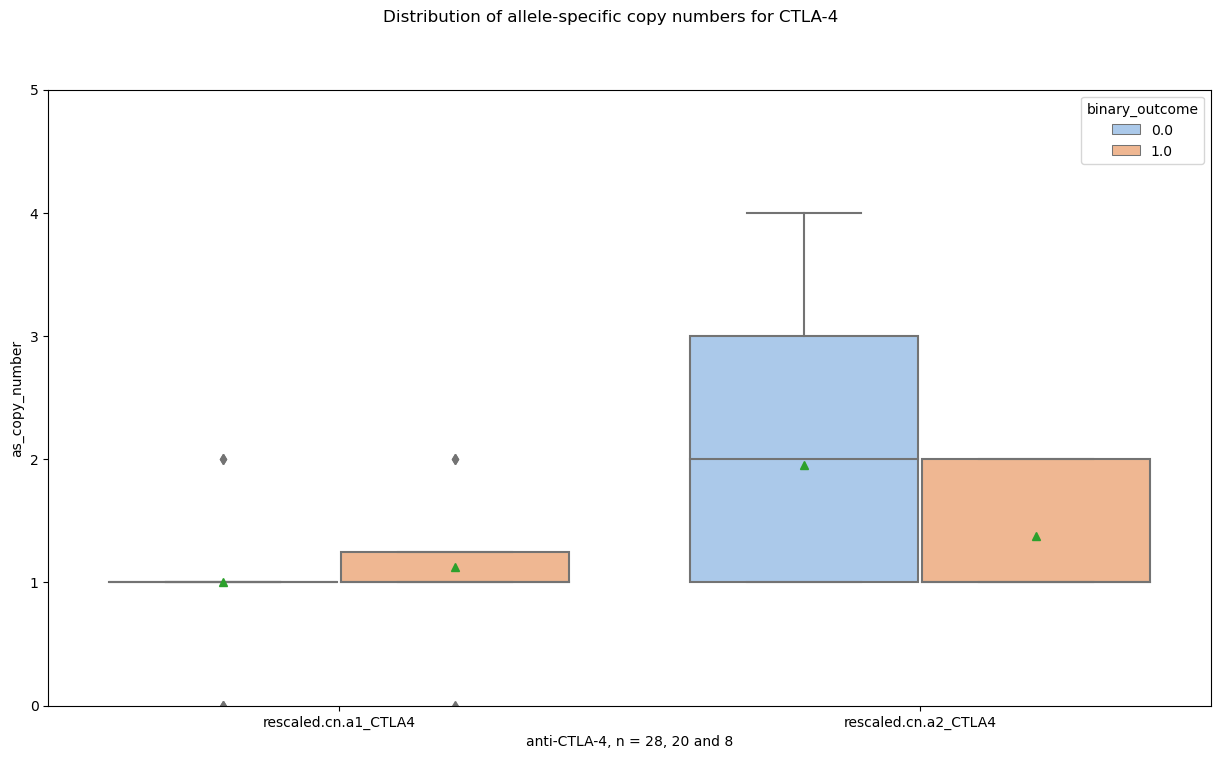

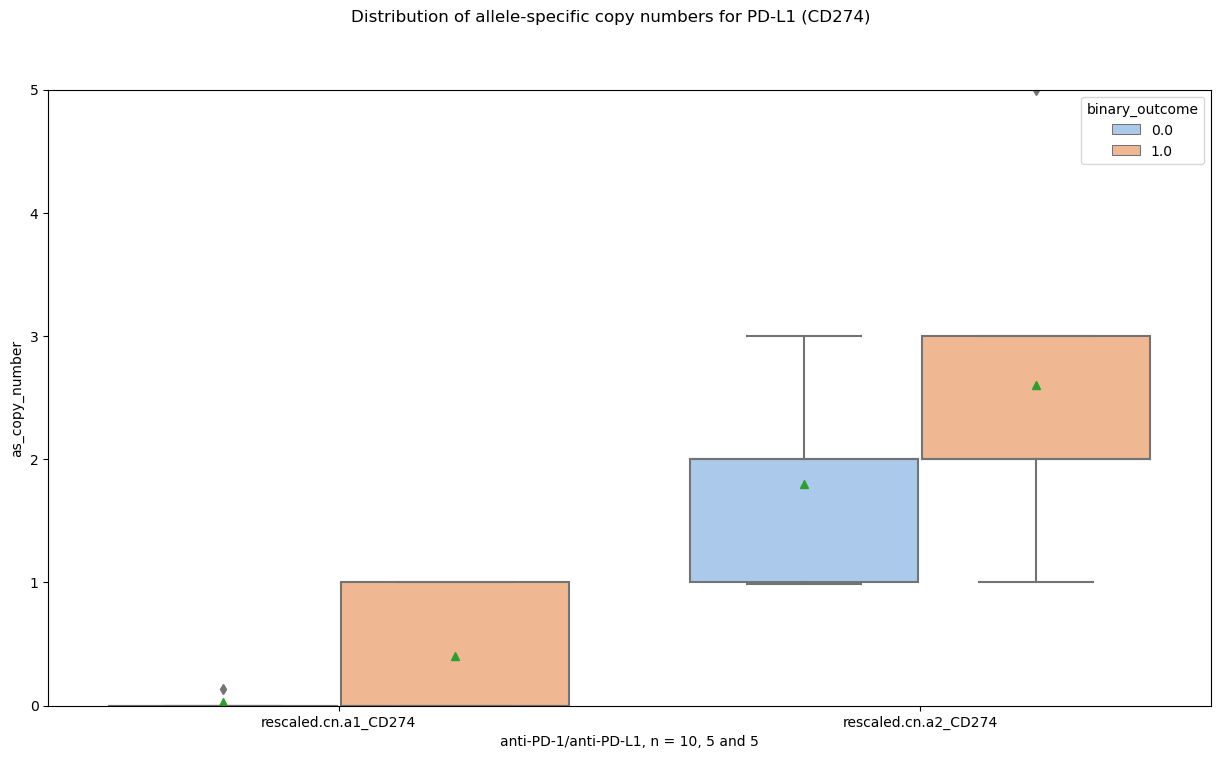

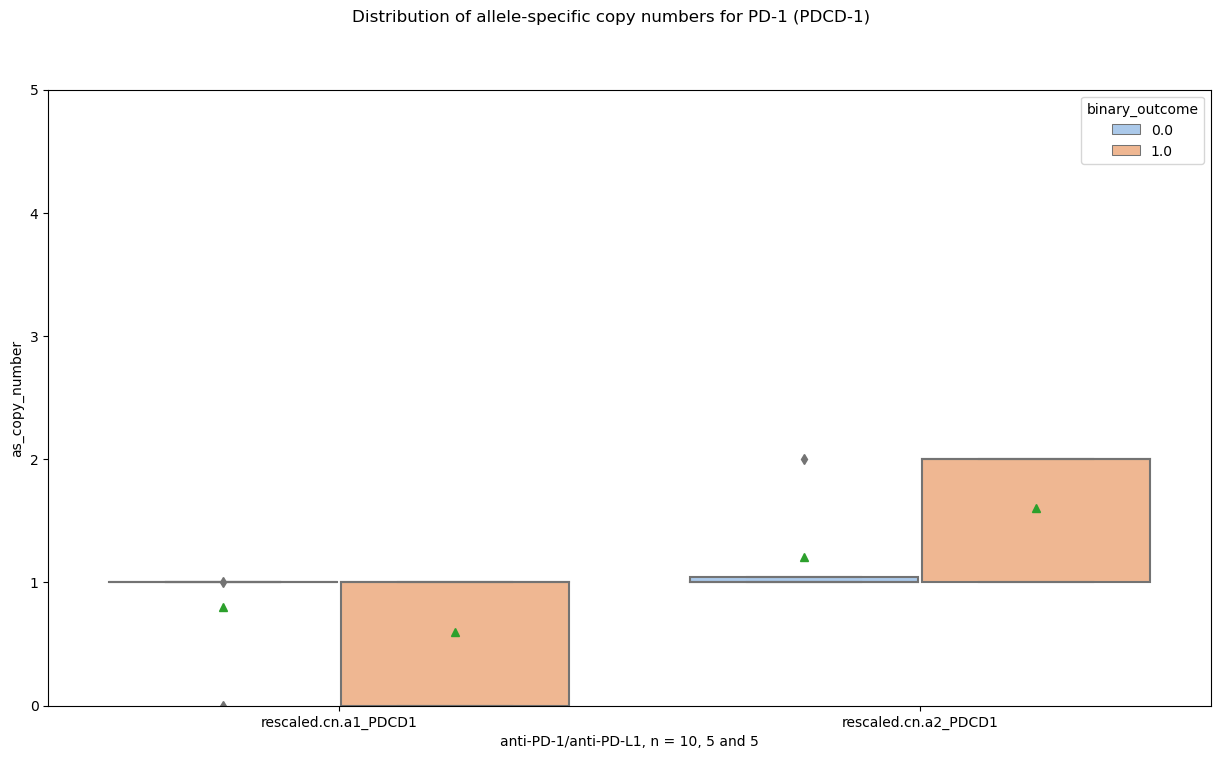

In [69]:
# distribution of allele-specific copy numbers

# CTLA-4
df = tidy(IO_CTLA4, 'rescaled.cn.a1_CTLA4', 'rescaled.cn.a2_CTLA4', 'as_copy_number', 'allele')
group_boxplots(df, 'drug_type', 'as_copy_number', 'allele', 'binary_outcome', 
                 'Distribution of allele-specific copy numbers for CTLA-4')

# PD-l1 (CD274)
df = tidy(IO_PD, 'rescaled.cn.a1_CD274', 'rescaled.cn.a2_CD274', 'as_copy_number', 'allele')
group_boxplots(df, 'drug_type', 'as_copy_number', 'allele', 'binary_outcome', 
                 'Distribution of allele-specific copy numbers for PD-L1 (CD274)')

# PD-1 (PDCD1)
df = tidy(IO_PD, 'rescaled.cn.a1_PDCD1', 'rescaled.cn.a2_PDCD1', 'as_copy_number', 'allele')
group_boxplots(df, 'drug_type', 'as_copy_number', 'allele', 'binary_outcome', 
                 'Distribution of allele-specific copy numbers for PD-1 (PDCD-1)')

100%|██████████| 30/30 [00:00<00:00, 67.14it/s]


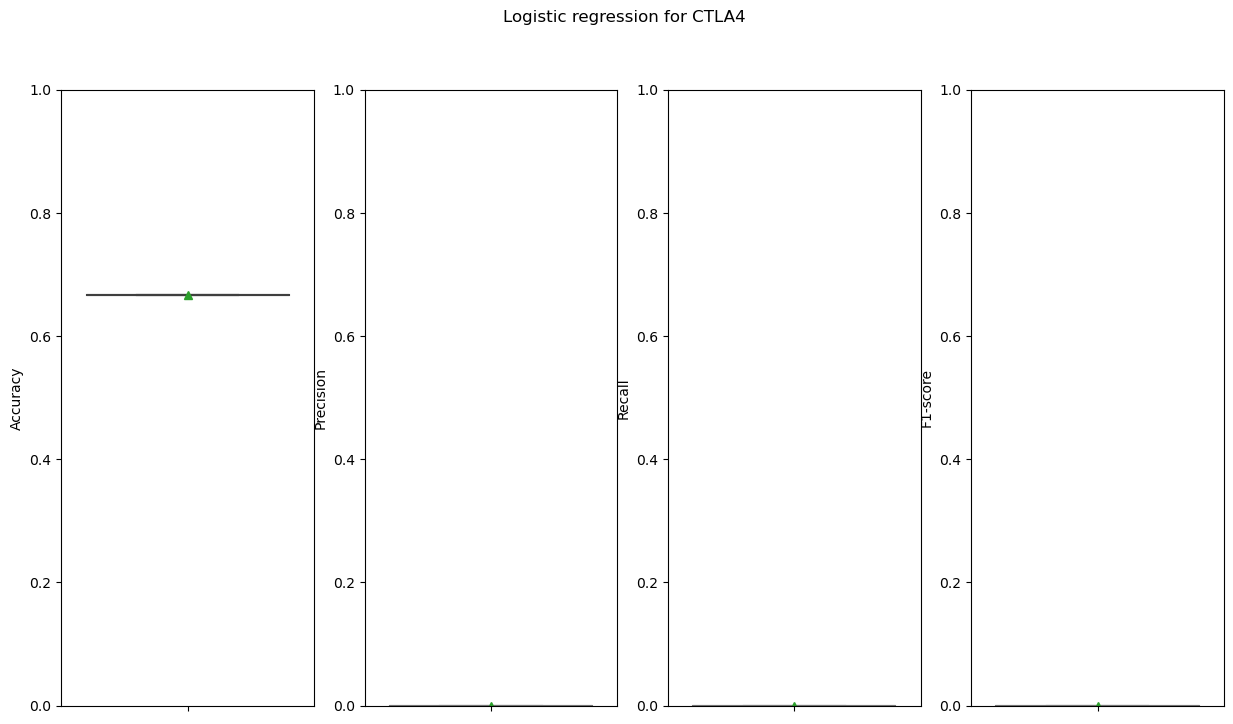

100%|██████████| 30/30 [00:00<00:00, 92.27it/s]


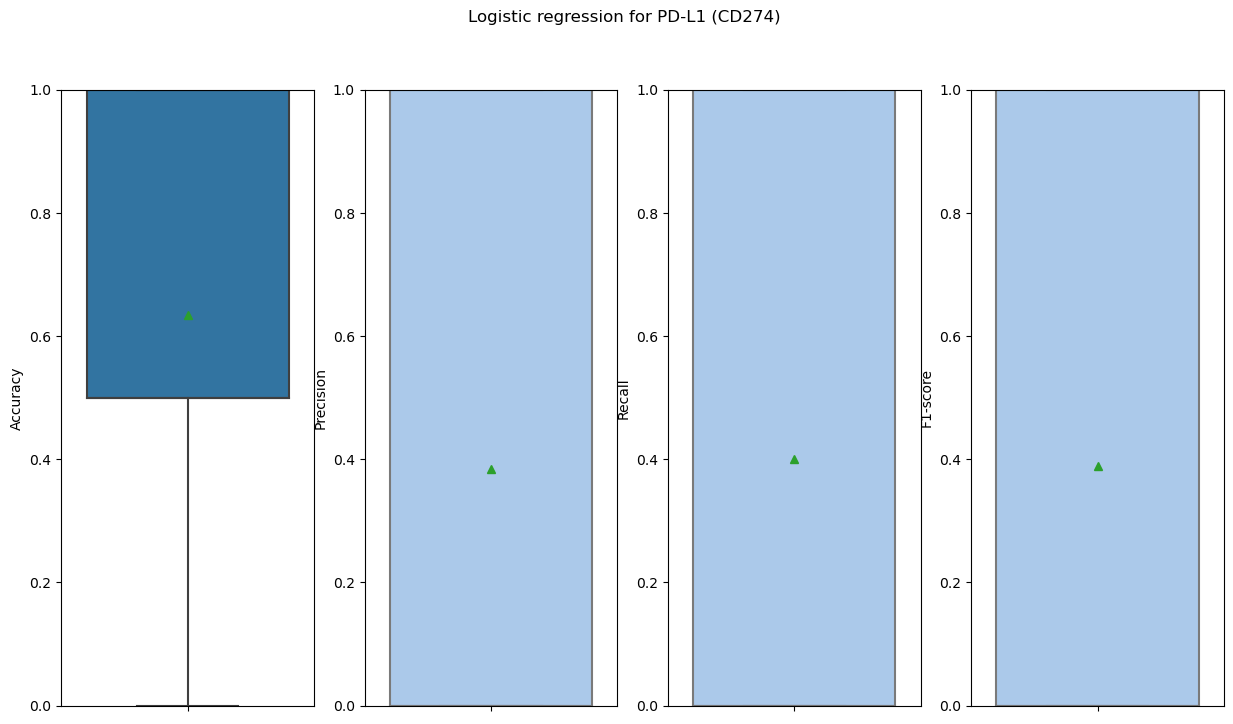

100%|██████████| 30/30 [00:00<00:00, 63.59it/s]


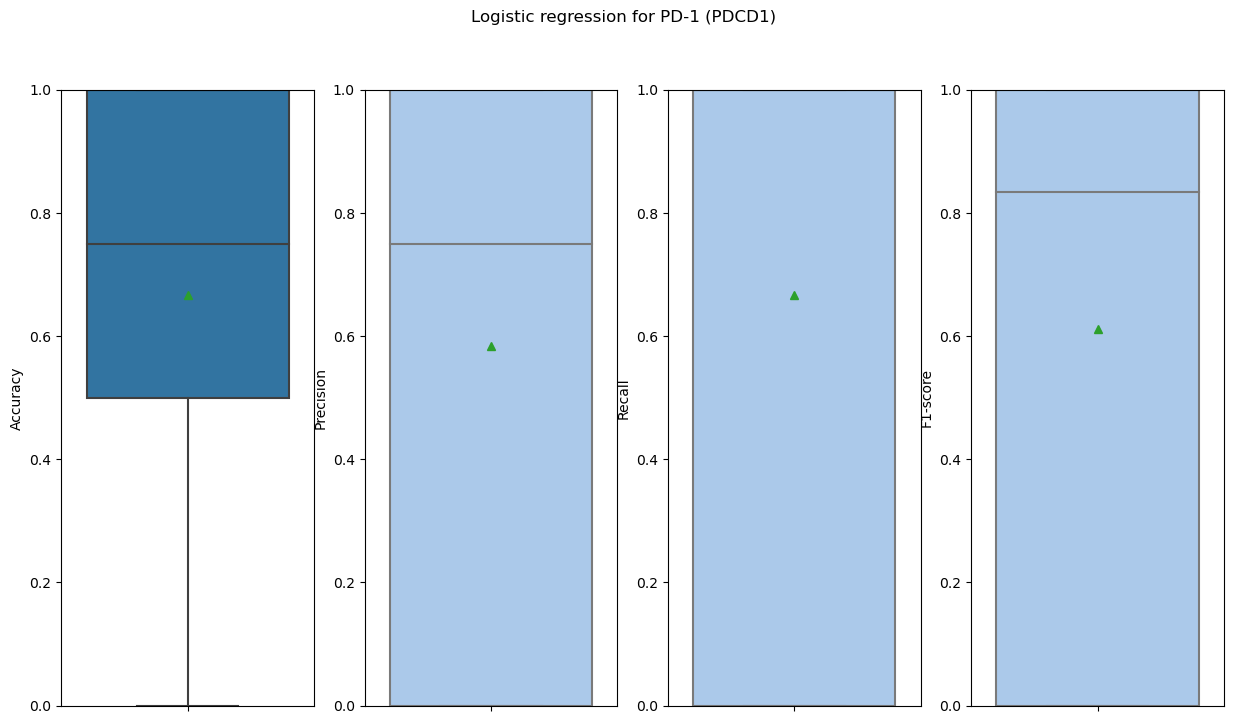

100%|██████████| 30/30 [00:08<00:00,  3.54it/s]


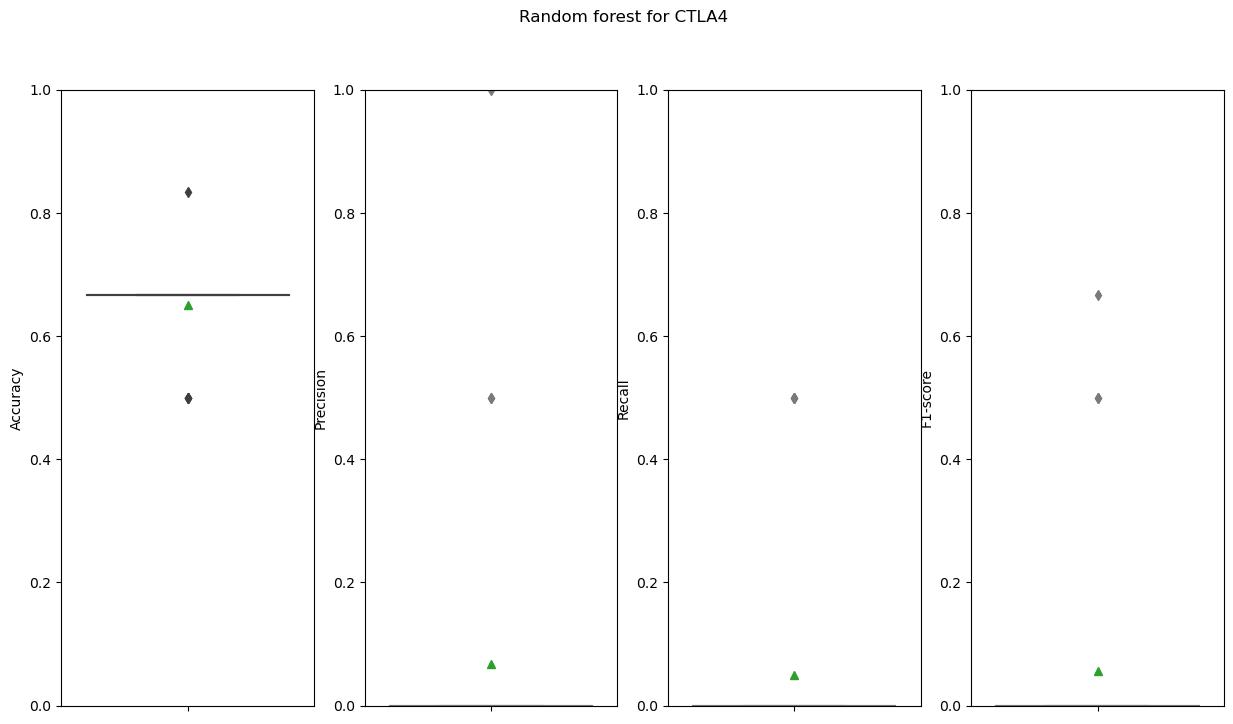

100%|██████████| 30/30 [00:06<00:00,  4.46it/s]


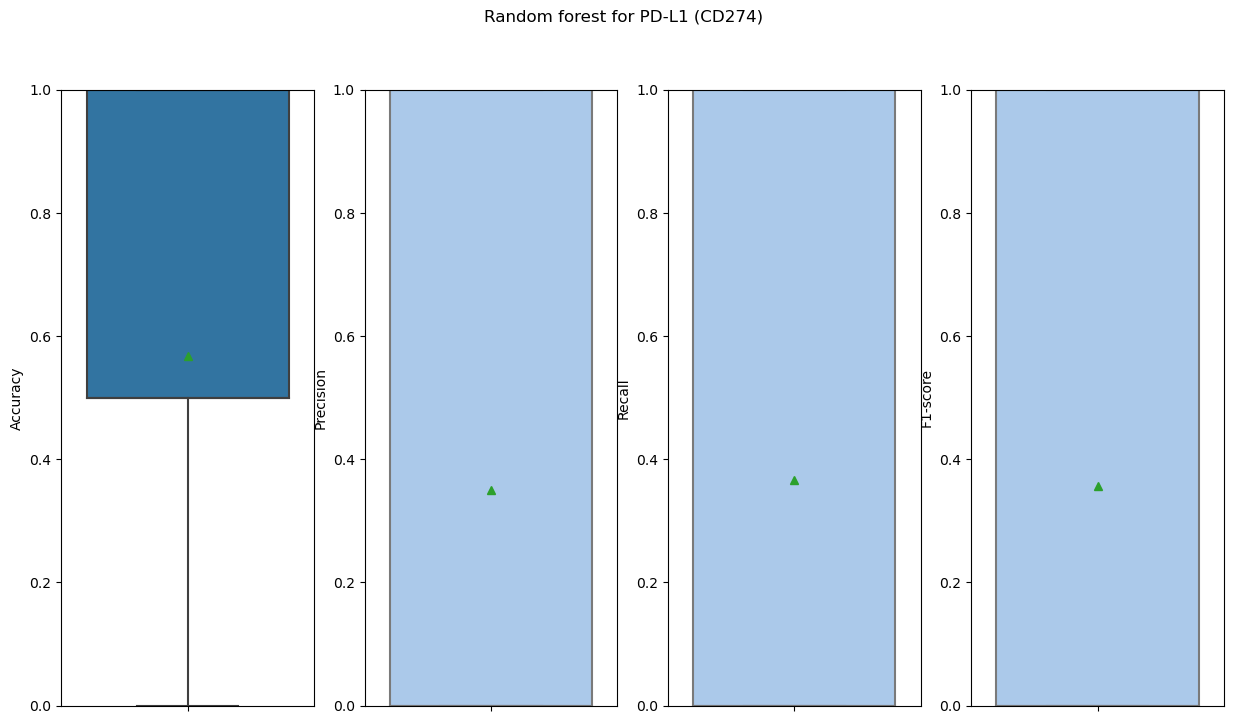

100%|██████████| 30/30 [00:08<00:00,  3.46it/s]


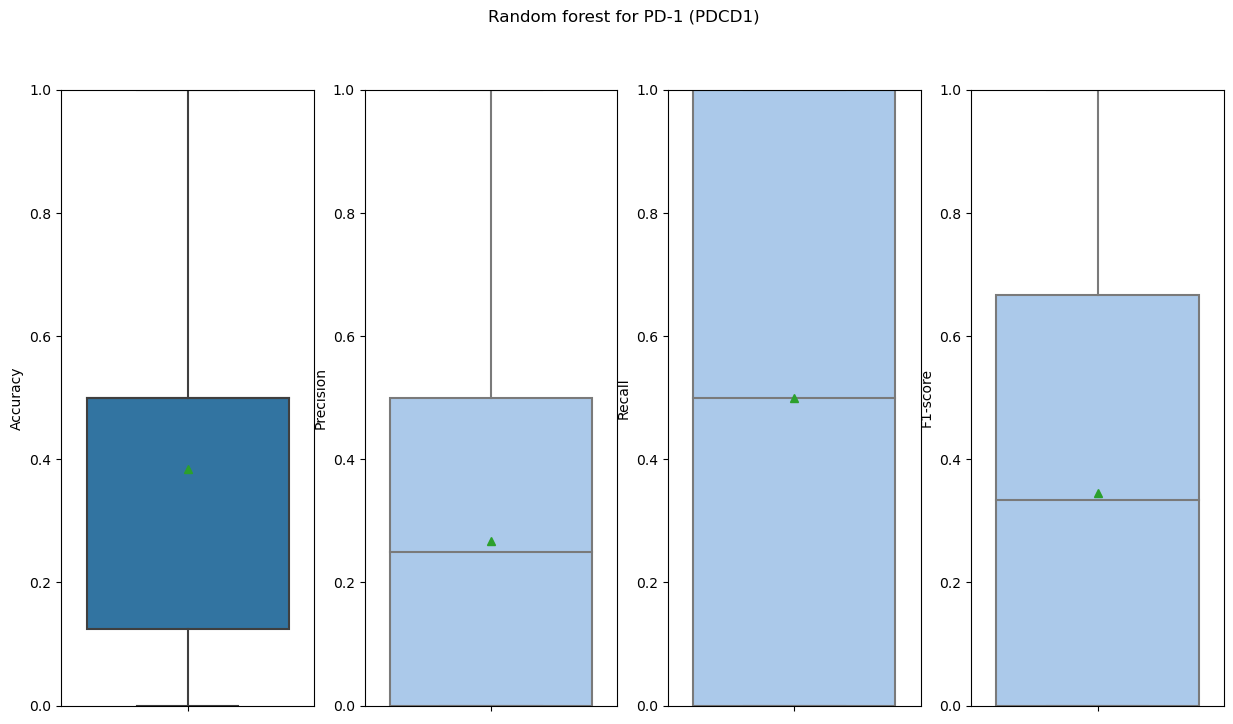

In [70]:
# logistic regression 

# get arrays
X_CTLA4 = col_to_array(IO_CTLA4, 'rescaled.cn.a2_CTLA4', 'rescaled.cn.a1_CTLA4')
y_CTLA4 = col_to_array(IO_CTLA4, 'binary_outcome').ravel()

X_CD274 = col_to_array(IO_PD, 'rescaled.cn.a2_CD274', 'rescaled.cn.a1_CD274')
y_CD274 = col_to_array(IO_PD, 'binary_outcome').ravel()

X_PDCD1 = col_to_array(IO_PD, 'rescaled.cn.a2_PDCD1', 'rescaled.cn.a1_PDCD1')
y_PDCD1 = col_to_array(IO_PD, 'binary_outcome').ravel()


iterate_workflow(X_CTLA4, y_CTLA4, 'logistic', n_iterations=30, print_table=False, print_boxplot=True, 
                 title='Logistic regression for CTLA4')
iterate_workflow(X_CD274, y_CD274, 'logistic', n_iterations=30, print_table=False, print_boxplot=True, 
                 title='Logistic regression for PD-L1 (CD274)')
iterate_workflow(X_PDCD1, y_PDCD1, 'logistic', n_iterations=30, print_table=False, print_boxplot=True, 
                 title='Logistic regression for PD-1 (PDCD1)')


iterate_workflow(X_CTLA4, y_CTLA4, 'forest', n_iterations=30, print_table=False, print_boxplot=True, 
                 title='Random forest for CTLA4')
iterate_workflow(X_CD274, y_CD274, 'forest', n_iterations=30, print_table=False, print_boxplot=True, 
                 title='Random forest for PD-L1 (CD274)')
iterate_workflow(X_PDCD1, y_PDCD1, 'forest', n_iterations=30, print_table=False, print_boxplot=True, 
                 title='Random forest for PD-1 (PDCD1)')


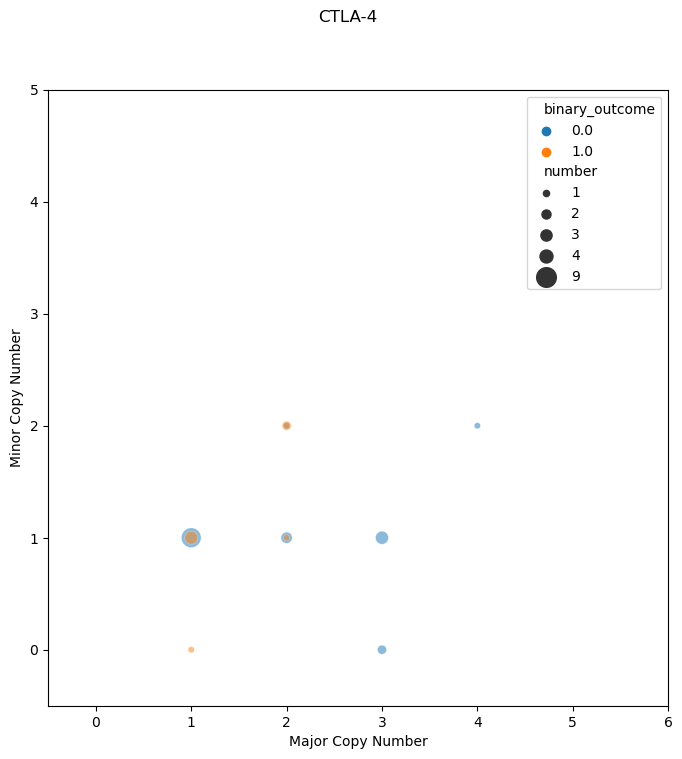

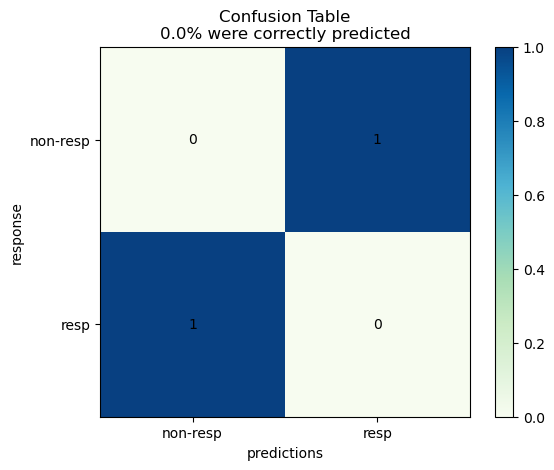

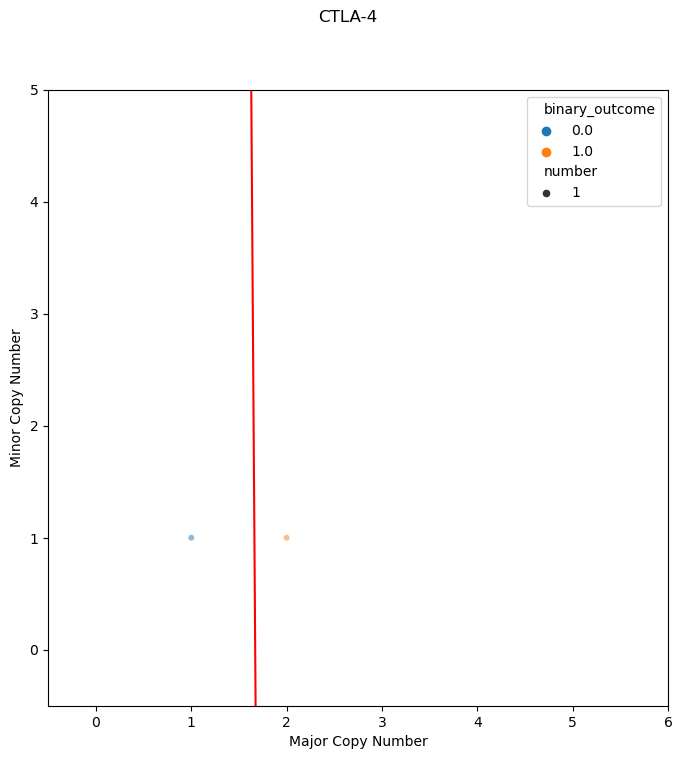

In [71]:
# ------------CTLA-4------------------

# subset 
df = IO_CTLA4.copy()
minor = 'rescaled.cn.a1_CTLA4'
major = 'rescaled.cn.a2_CTLA4'
title = 'CTLA-4'

# for subsequent counting, add a column with 1s
df.insert(3,'number',1)

# group, merge and sum n
df = grouper(df, 'binary_outcome', major, minor, 'number')

# make a bubble plot
bubble_scatter(df, x = major, y = minor, 
               x_label = 'Major Copy Number', y_label = 'Minor Copy Number', hue = 'binary_outcome', 
               size = 'number', title=title, model=None)

# make a logistic regression model
X_total = col_to_array(df, major, minor)
y_total = col_to_array(df, 'binary_outcome').ravel()
X_train, X_test, y_train, y_test = data_split(X_total, y_total)
regression_model = LogisticRegression(random_state=None).fit(X_train, y_train)
y_predict = regression_model.predict(X_test)

# make a confusion plot
tn, fp, fn, tp = confusion_table(y_test, y_predict)
confusion_plot(tn, fp, fn, tp, 'predictions', 'response', 'non-resp', 'resp')

# plot the predictions with a bubble plot (first get the X_test and y_predict into df)
array = np.column_stack((X_test, y_test))
df_predictions = pd.DataFrame(array, columns=[major, minor, 'binary_outcome'])

df_predictions.insert(3,'number',1)
df_predictions_merged = grouper(df_predictions, 'binary_outcome', major, minor, 'number')
bubble_scatter(df_predictions_merged, x = major, y = minor, 
               x_label = 'Major Copy Number', y_label = 'Minor Copy Number', hue = 'binary_outcome', 
               size = 'number', title=title, model=regression_model)



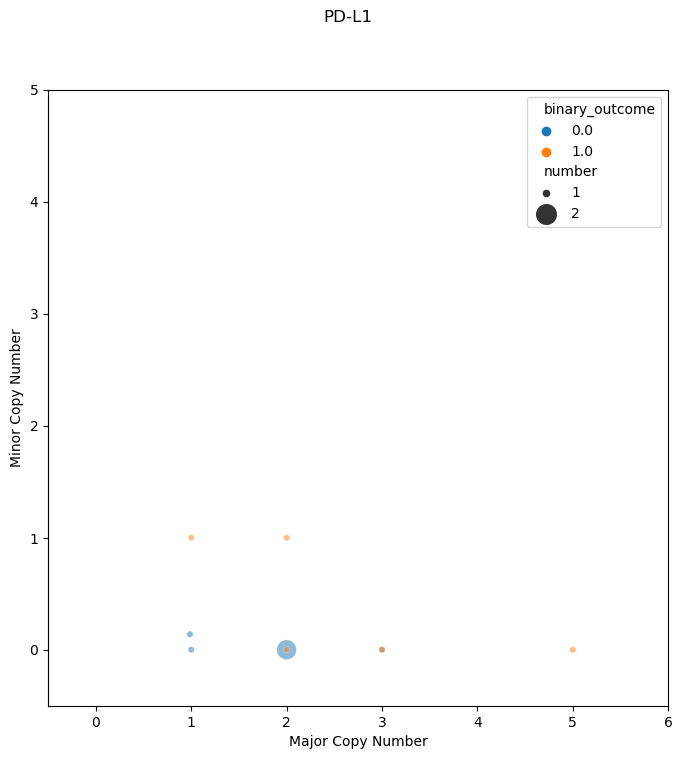

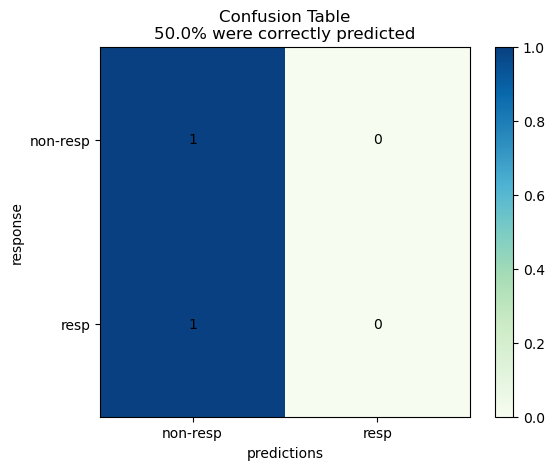

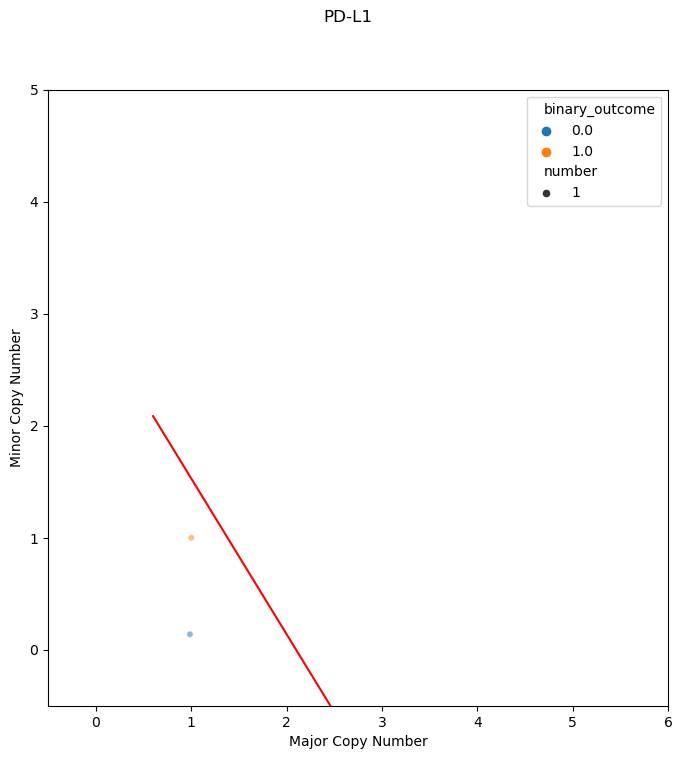

In [73]:
# ------------PD-L1------------------

# subset 
df = IO_PD.copy()
minor = 'rescaled.cn.a1_CD274'
major = 'rescaled.cn.a2_CD274'
title = 'PD-L1'

# for subsequent counting, add a column with 1s
df.insert(3,'number',1)

# group, merge and sum n
df = grouper(df, 'binary_outcome', major, minor, 'number')

# make a bubble plot
bubble_scatter(df, x = major, y = minor, 
               x_label = 'Major Copy Number', y_label = 'Minor Copy Number', hue = 'binary_outcome', 
               size = 'number', title=title, model=None)

# make a logistic regression model
X_total = col_to_array(df, major, minor)
y_total = col_to_array(df, 'binary_outcome').ravel()
X_train, X_test, y_train, y_test = data_split(X_total, y_total)
regression_model = LogisticRegression(random_state=None).fit(X_train, y_train)
y_predict = regression_model.predict(X_test)

# make a confusion plot
tn, fp, fn, tp = confusion_table(y_test, y_predict)
confusion_plot(tn, fp, fn, tp, 'predictions', 'response', 'non-resp', 'resp')

# plot the predictions with a bubble plot (first get the X_test and y_predict into df)
array = np.column_stack((X_test, y_test))
df_predictions = pd.DataFrame(array, columns=[major, minor, 'binary_outcome'])

df_predictions.insert(3,'number',1)
df_predictions_merged = grouper(df_predictions, 'binary_outcome', major, minor, 'number')
bubble_scatter(df_predictions_merged, x = major, y = minor, 
               x_label = 'Major Copy Number', y_label = 'Minor Copy Number', hue = 'binary_outcome', 
               size = 'number', title=title, model=regression_model)



In [ ]:
# ------------PD-1------------------

# subset 
df = IO_PD.copy()
minor = 'rescaled.cn.a1_PDCD1'
major = 'rescaled.cn.a2_PDCD1'
title = 'PD-1'

# for subsequent counting, add a column with 1s
df.insert(3,'number',1)

# group, merge and sum n
df = grouper(df, 'binary_outcome', major, minor, 'number')

# make a bubble plot
bubble_scatter(df, x = major, y = minor, 
               x_label = 'Major Copy Number', y_label = 'Minor Copy Number', hue = 'binary_outcome', 
               size = 'number', title=title, model=None)

# make a logistic regression model
X_total = col_to_array(df, major, minor)
y_total = col_to_array(df, 'binary_outcome').ravel()
X_train, X_test, y_train, y_test = data_split(X_total, y_total)
regression_model = LogisticRegression(random_state=None).fit(X_train, y_train)
y_predict = regression_model.predict(X_test)

# make a confusion plot
tn, fp, fn, tp = confusion_table(y_test, y_predict)
confusion_plot(tn, fp, fn, tp, 'predictions', 'response', 'non-resp', 'resp')

# plot the predictions with a bubble plot (first get the X_test and y_predict into df)
array = np.column_stack((X_test, y_test))
df_predictions = pd.DataFrame(array, columns=[major, minor, 'binary_outcome'])

df_predictions.insert(3,'number',1)
df_predictions_merged = grouper(df_predictions, 'binary_outcome', major, minor, 'number')
bubble_scatter(df_predictions_merged, x = major, y = minor, 
               x_label = 'Major Copy Number', y_label = 'Minor Copy Number', hue = 'binary_outcome', 
               size = 'number', title=title, model=regression_model)



## 11.3 Gene expression  <a class="anchor" id="11.3"></a> [↑](#Content)

In [ ]:
# get data
IO = open_df(processed + 'IO_cohort_plus.csv', sep = ',')

# drop rows with unclear outcome (non binary)
IO = IO[IO['binary_outcome'].notna()]

# make column with total gene copy number
columns = {'total_cn_CD274':['rescaled.cn.a1_CD274', 'rescaled.cn.a2_CD274'],
           'total_cn_PDCD1':['rescaled.cn.a1_PDCD1', 'rescaled.cn.a2_PDCD1'],
           'total_cn_CTLA4':['rescaled.cn.a1_CTLA4', 'rescaled.cn.a2_CTLA4']}

for col in columns: 
    IO[col] = IO.loc[:,columns[col]].sum(axis=1)

# subset according to treatment
IO_CTLA4 = IO[IO['drug_type']=='anti-CTLA-4']  # 28 samples
IO_PD = IO[IO['drug_type']=='anti-PD-1/anti-PD-L1']  # 10 samples
IO_both = IO[IO['drug_type']=='anti-CTLA-4 + anti-PD-1/PD-L1']  # 6 samples

In [ ]:
swarm_plot(IO_CTLA4, 'binary_outcome', 'CTLA4 percentile', 'binary outcome', 'Gene expression', 
         title = 'Distribution of gene expression for CTLA-4')

In [ ]:
swarm_plot(IO_PD, 'binary_outcome', 'CD274 percentile', 'binary outcome', 'Gene expression', 
         title = 'Distribution of gene expression for PD-L1 (CD274)')

In [ ]:
swarm_plot(IO_PD, 'binary_outcome', 'PDCD1 percentile', 'binary outcome', 'Gene expression', 
         title = 'Distribution of gene expression for PD-1 (PDCD1)')

## 11.4 Integration all datatypes <a class="anchor" id="11.4"></a> [↑](#Content)

In [ ]:
# imports

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from tqdm import tqdm

# functions

def heatmap(score, df, cn_col, exp_col, status_col, x_label, y_label, x_min, x_max, y_min, y_max, title='title'):
    ''' 
    Results in a heatmap with the threshold of the copy numbers on the x axis and the one of 
    the gene expression on the y axis and the F1 score as a heatmap. 
    
    :param df:
    :param cn_col: col with the copy numbers
    :param exp_col: col with the gene expression
    :param status_col: col with the HER2 status by IHC
    :param x_label: label x axis on heatmap
    :param y_label:
    :param x_min: lowest threshold for copy numbers (x axis)
    :param x_max: 
    :param y_min: lowest threshold for gene expression (y axis)
    :param y_max:
    :param title:
    :return: prints the heatmap
    '''
    
    range_cn = list(np.linspace(start=x_min, stop=x_max, num=50))
    range_exp = list(np.linspace(start=y_max, stop=y_min, num=50))
    
    list_lists = []
    
    for i in tqdm(range_exp):
        single_list = []
        for j in range_cn:
            if score == 'f1':
                single_list.append(get_f1_score(df, cn_col, exp_col, status_col, j, i))
            if score == 'acc':
                single_list.append(get_acc_score(df, cn_col, exp_col, status_col, j, i))
        list_lists.append(single_list)
    
    scores = np.array(list_lists)
    
    # X, Y = np.meshgrid(range_cn, range_exp)  # creates a grid of all possible values
    # Z = get_f1_score(df, cn_col, exp_col, status_col, X, Y)
    
    # input_combinations = [(x, y) for x in range_cn for y in range_exp]
    # Z = [get_f1_score(df, cn_col, exp_col, status_col, cn, exp) for cn, exp in input_combinations]
    
    # make the heatmap
    fig, ax = plt.subplots()
    im = ax.imshow(scores, cmap='RdBu', interpolation='nearest', 
                   extent=[range_cn[0], range_cn[-1], range_exp[-1], range_exp[0]], 
                   aspect = 'auto')
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_xlim(x_min ,x_max)
    ax.set_ylim(y_min, y_max)
    fig.colorbar(im, ax=ax, label=score)    
    plt.show()
    
def combinator(value1, value2):
    ''' 
    Combines two binary values (0 or 1) to one binary value
    Rule: OR
    
    :param value1:
    :param value2:
    :return:
    '''
    if (value1 + value2) == 2:
    #if value1 == 1 or value2 == 1:
        return 1
    else:
        return 0
    
def get_f1_score(df, cn_col, exp_col, status_col, cn_thr, exp_thr):
    '''
    Transforms the copy number and the gene expression to binary
    based on set threshold. 
    Converts both binary to a single binary value, see combinator()
    Calculate the f1 score for the set thresholds
    
    :param df:
    :param cn_col: col with the copy numbers
    :param exp_col: col with the expression data
    :param cn_thr: threshold for copy number
    :param exp_thr: threshold for expression
    :return: f1 score
    '''
    
    df = df.copy()
    df[cn_col] = np.where(df[cn_col] >= cn_thr, 1, 0)  # make values binary
    df[exp_col] = np.where(df[exp_col] >= exp_thr, 1, 0)
            
    # concatenate the two binary values
    df['combination'] = df.apply(lambda x: combinator(x[cn_col], x[exp_col]), axis=1)  
    score = f1_score(list(df[status_col]), list(df['combination']))
    return score

def get_acc_score(df, cn_col, exp_col, status_col, cn_thr, exp_thr):
    '''
    Transforms the copy number and the gene expression to binary
    based on set threshold. 
    Converts both binary to a single binary value, see combinator()
    Calculate the f1 score for the set thresholds
    
    :param df:
    :param cn_col: col with the copy numbers
    :param exp_col: col with the expression data
    :param cn_thr: threshold for copy number
    :param exp_thr: threshold for expression
    :return: f1 score
    '''
    
    df = df.copy()
    df[cn_col] = np.where(df[cn_col] >= cn_thr, 1, 0)  # make values binary
    df[exp_col] = np.where(df[exp_col] >= exp_thr, 1, 0)
            
    # concatenate the two binary values
    df['combination'] = df.apply(lambda x: combinator(x[cn_col], x[exp_col]), axis=1)  
    score = accuracy_score(list(df[status_col]), list(df['combination']))
    return score

In [ ]:
# get data
IO = open_df(processed + 'IO_cohort.csv', sep = ',')

# drop rows with unclear outcome (non binary)
IO = IO[IO['binary_outcome'].notna()]

# make column with total gene copy number
columns = {'total_cn_CD274':['rescaled.cn.a1_CD274', 'rescaled.cn.a2_CD274'],
           'total_cn_PDCD1':['rescaled.cn.a1_PDCD1', 'rescaled.cn.a2_PDCD1'],
           'total_cn_CTLA4':['rescaled.cn.a1_CTLA4', 'rescaled.cn.a2_CTLA4']}

for col in columns: 
    IO[col] = IO.loc[:,columns[col]].sum(axis=1)

# subset according to treatment
IO_CTLA4 = IO[IO['drug_type']=='anti-CTLA-4']  # 28 samples
IO_PD = IO[IO['drug_type']=='anti-PD-1/anti-PD-L1']  # 10 samples
IO_both = IO[IO['drug_type']=='anti-CTLA-4 + anti-PD-1/PD-L1']  # 6 samples

In [ ]:
# CTLA-4
df = IO_CTLA4
heatmap('f1', df, 'total_cn_CTLA4', 'CTLA4', 'binary_outcome', 'Copy number', 'CTLA-4 expression (TPM)', 0, 5, 0, 350, 
           title='Thresholding of the total copy numbers \n and gene expression for CTLA-4')

In [ ]:
# CTLA-4
df = IO_CTLA4
heatmap('acc', df, 'total_cn_CTLA4', 'CTLA4', 'binary_outcome', 'Copy number', 'CTLA-4 expression (TPM)', 0, 5, 0, 350, 
           title='Thresholding of the total copy numbers \n and gene expression for CTLA-4')

In [ ]:
# CD274
df = IO_PD
heatmap('f1', df, 'total_cn_CD274', 'CD274', 'binary_outcome', 'Copy number', 'CD274 expression (TPM)', 0, 5, 0, 350, 
           title='Thresholding of the total copy numbers \n and gene expression for PD-L1 (CD274)')

In [ ]:
# CD274
df = IO_PD
heatmap('acc', df, 'total_cn_CD274', 'CD274', 'binary_outcome', 'Copy number', 'CD274 expression (TPM)', 0, 5, 0, 350, 
           title='Thresholding of the total copy numbers \n and gene expression for PD-L1 (CD274)')

In [ ]:
# PDCD1
df = IO_PD
heatmap('f1', df, 'total_cn_PDCD1', 'PDCD1', 'binary_outcome', 'Copy number', 'PDCD1 expression (TPM)', 0, 5, 0, 350, 
           title='Thresholding of the total copy numbers \n and gene expression for PD-1 (PDCD1)')

In [ ]:
# PDCD1
df = IO_PD
heatmap('acc', df, 'total_cn_PDCD1', 'PDCD1', 'binary_outcome', 'Copy number', 'PDCD1 expression (TPM)', 0, 5, 0, 350, 
           title='Thresholding of the total copy numbers \n and gene expression for PD-1 (PDCD1)')

In [ ]:
# get data
IO = open_df(processed + 'IO_cohort.csv', sep = ',')

# drop rows with unclear outcome (non binary)
IO = IO[IO['binary_outcome'].notna()]

IO['cancer_type'].value_counts()
